In [1]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [3]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [4]:
num_classes = 5       # 输出的类别总数
patch_size = 16       # 对输入的图像进行切分的大小，表示切分后每个小块的大小
hidden_size = 512     # 隐藏层的维度大小
num_layers = 10       # 编码器中的层数
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # 批次大小
num_epochs = 100    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads,fropout=dropout_prob):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads,dropout=dropout_prob),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        # self.batch_norm = nn.BatchNorm2d(3)

        self.focus = Focus(3, 12)
        self.vit = ViTModule(12, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(12, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SPPSingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        x = self.focus(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [6]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [7]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

Fold 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100


100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


Train Loss: 0.9525053071975708
Train Acc (3077): 66.33084172895677%
------Weighted------
Weighted precision 0.6610037544744024
Weighted recall 0.6633084172895678
Weighted f1-score 0.66101019679879
------Macro------
Macro precision 0.6614555975662469
Macro recall 0.6636674395445232
Macro f1-score 0.6614302281299921


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Val Loss: 1.0160866975784302
Val Acc (162): 59.876543209876544%
------Weighted------
Weighted precision 0.7398185880828281
Weighted recall 0.5987654320987654
Weighted f1-score 0.5912501925573821
------Macro------
Macro precision 0.7404528602506357
Macro recall 0.5947947214076247
Macro f1-score 0.589525507172566
Training Loss: 0.9525, Training Accuracy: 66.33%
Validation Loss: 1.0161, Validation Accuracy: 59.88%
Epoch 2/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.6224581158161163
Train Acc (3077): 80.66298342541437%
------Weighted------
Weighted precision 0.8059613524081053
Weighted recall 0.8066298342541437
Weighted f1-score 0.8050146647763524
------Macro------
Macro precision 0.8063849001427789
Macro recall 0.8072493215789084
Macro f1-score 0.8055579252014008


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 1.0602734684944153
Val Acc (162): 59.876543209876544%
------Weighted------
Weighted precision 0.7450477626948215
Weighted recall 0.5987654320987654
Weighted f1-score 0.5657516373856243
------Macro------
Macro precision 0.7477224736048265
Macro recall 0.5934078690127078
Macro f1-score 0.5618283401812814
Training Loss: 0.6225, Training Accuracy: 80.66%
Validation Loss: 1.0603, Validation Accuracy: 59.88%
Epoch 3/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.3867169934511185
Train Acc (3077): 89.53526161845954%
------Weighted------
Weighted precision 0.8953233598270999
Weighted recall 0.8953526161845954
Weighted f1-score 0.8947051034764706
------Macro------
Macro precision 0.895367574672792
Macro recall 0.8956346802055222
Macro f1-score 0.8948787963804709


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 1.0949938893318176
Val Acc (162): 59.876543209876544%
------Weighted------
Weighted precision 0.7251627165999146
Weighted recall 0.5987654320987654
Weighted f1-score 0.580029849870867
------Macro------
Macro precision 0.7276733556298774
Macro recall 0.5941898826979473
Macro f1-score 0.5767774458095738
Training Loss: 0.3867, Training Accuracy: 89.54%
Validation Loss: 1.0950, Validation Accuracy: 59.88%
Epoch 4/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.23597349643707274
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9550866827807301
Weighted recall 0.9551511212219694
Weighted f1-score 0.9550017845634242
------Macro------
Macro precision 0.955100129071438
Macro recall 0.9552409755531184
Macro f1-score 0.9550554452086344


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


Val Loss: 1.0043661296367645
Val Acc (162): 65.4320987654321%
------Weighted------
Weighted precision 0.7520372688082325
Weighted recall 0.654320987654321
Weighted f1-score 0.6071361258953168
------Macro------
Macro precision 0.7539667008002426
Macro recall 0.6483198924731183
Macro f1-score 0.6017092178258365
Training Loss: 0.2360, Training Accuracy: 95.52%
Validation Loss: 1.0044, Validation Accuracy: 65.43%
Epoch 5/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.1494893553853035
Train Acc (3077): 98.40753981150472%
------Weighted------
Weighted precision 0.9840729481877274
Weighted recall 0.9840753981150471
Weighted f1-score 0.9840472503474237
------Macro------
Macro precision 0.9840637866065307
Macro recall 0.9840896740154592
Macro f1-score 0.9840496653919757


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.9264728724956512
Val Acc (162): 67.28395061728395%
------Weighted------
Weighted precision 0.7445667871525715
Weighted recall 0.6728395061728395
Weighted f1-score 0.6399875916445117
------Macro------
Macro precision 0.7468694295900178
Macro recall 0.6676747311827957
Macro f1-score 0.6360246770773086
Training Loss: 0.1495, Training Accuracy: 98.41%
Validation Loss: 0.9265, Validation Accuracy: 67.28%
Epoch 6/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.11043990075588227
Train Acc (3077): 98.3750406239844%
------Weighted------
Weighted precision 0.9837525433268429
Weighted recall 0.983750406239844
Weighted f1-score 0.9837241066094695
------Macro------
Macro precision 0.9837771789399209
Macro recall 0.9838044155067346
Macro f1-score 0.9837636558034241


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.16719134151935577
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952968085382301
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501440699429912
------Macro------
Macro precision 0.9527314107461166
Macro recall 0.9511363636363637
Macro f1-score 0.9503071770188452
Training Loss: 0.1104, Training Accuracy: 98.38%
Validation Loss: 0.1672, Validation Accuracy: 95.06%
Epoch 27/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.07853874281048774
Train Acc (3077): 99.57751056223594%
------Weighted------
Weighted precision 0.9957793649629769
Weighted recall 0.9957751056223595
Weighted f1-score 0.9957764271470946
------Macro------
Macro precision 0.9957864290223671
Macro recall 0.995770722539052
Macro f1-score 0.9957777501128641


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


Val Loss: 0.22316565364599228
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446623093681917
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439279472446969
------Macro------
Macro precision 0.9447426829969524
Macro recall 0.9448741446725318
Macro f1-score 0.9441891228121367
Training Loss: 0.0785, Training Accuracy: 99.58%
Validation Loss: 0.2232, Validation Accuracy: 94.44%
|0.11043990075588227 - 0.07853874281048774| < 0.07
new rng
Epoch 28/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.177111853659153
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9604446121772483
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603851698974544
------Macro------
Macro precision 0.9605495520161551
Macro recall 0.9604381344356454
Macro f1-score 0.9604812621723579


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.1576732099056244
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9509101131492024
Weighted recall 0.9506172839506173
Weighted f1-score 0.9504126917321362
------Macro------
Macro precision 0.950876890345581
Macro recall 0.9509347507331378
Macro f1-score 0.95055596285435
Training Loss: 0.1771, Training Accuracy: 96.04%
Validation Loss: 0.1577, Validation Accuracy: 95.06%
|0.17416895270347596 - 0.177111853659153| < 0.07
new rng
Epoch 38/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.1355949193239212
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9612755263892103
Weighted recall 0.9613259668508287
Weighted f1-score 0.961281506688627
------Macro------
Macro precision 0.9613807937815947
Macro recall 0.9614916326656783
Macro f1-score 0.9614169879269918


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.20686234533786774
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9447621641249093
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443437221215
------Macro------
Macro precision 0.9448407222126388
Macro recall 0.9448741446725318
Macro f1-score 0.9445973381457252
Training Loss: 0.1356, Training Accuracy: 96.13%
Validation Loss: 0.2069, Validation Accuracy: 94.44%
|0.177111853659153 - 0.1355949193239212| < 0.07
new rng
Epoch 39/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.1261295971274376
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638008332376977
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638217260372631
------Macro------
Macro precision 0.9637667737201285
Macro recall 0.9640301570605375
Macro f1-score 0.9638569869099619


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.15115763992071152
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1261, Training Accuracy: 96.39%
Validation Loss: 0.1512, Validation Accuracy: 95.68%
|0.1355949193239212 - 0.1261295971274376| < 0.07
new rng
Epoch 40/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15759334683418275
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671648361014439
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671602424066228
------Macro------
Macro precision 0.9673354109749674
Macro recall 0.967255434923071
Macro f1-score 0.9672854290022826


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.1456170603632927
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1576, Training Accuracy: 96.72%
Validation Loss: 0.1456, Validation Accuracy: 95.68%
|0.1261295971274376 - 0.15759334683418275| < 0.07
new rng
Epoch 41/100


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Train Loss: 0.14130501180887223
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9659083549968777
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658846585160781
------Macro------
Macro precision 0.9659112564134041
Macro recall 0.9659515284689677
Macro f1-score 0.9659238827857617


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


Val Loss: 0.16790283471345901
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1413, Training Accuracy: 96.59%
Validation Loss: 0.1679, Validation Accuracy: 95.06%
|0.15759334683418275 - 0.14130501180887223| < 0.07
new rng
Epoch 42/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.15869166791439057
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632098421702221
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632304334596882
------Macro------
Macro precision 0.9633198005587159
Macro recall 0.9634226816932305
Macro f1-score 0.9633589407332824


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Val Loss: 0.13992243632674217
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1587, Training Accuracy: 96.33%
Validation Loss: 0.1399, Validation Accuracy: 95.06%
|0.14130501180887223 - 0.15869166791439057| < 0.07
new rng
Epoch 43/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.1341044697165489
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9597121944489957
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596548750146929
------Macro------
Macro precision 0.9597243444370772
Macro recall 0.9597719659688299
Macro f1-score 0.9596965442556117


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.11941616237163544
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1341, Training Accuracy: 95.97%
Validation Loss: 0.1194, Validation Accuracy: 95.06%
|0.15869166791439057 - 0.1341044697165489| < 0.07
new rng
Epoch 44/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1343322390317917
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632871540452828
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632784342257877
------Macro------
Macro precision 0.9634195421936489
Macro recall 0.9634048343605945
Macro f1-score 0.9634090402636722


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Val Loss: 0.15348787605762482
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1343, Training Accuracy: 96.33%
Validation Loss: 0.1535, Validation Accuracy: 95.06%
|0.1341044697165489 - 0.1343322390317917| < 0.07
new rng
Epoch 45/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1295226839184761
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655975070650067
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655687195909994
------Macro------
Macro precision 0.9656693401266478
Macro recall 0.9655737112379018
Macro f1-score 0.965616119230561


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.12098732963204384
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1295, Training Accuracy: 96.56%
Validation Loss: 0.1210, Validation Accuracy: 95.06%
|0.1343322390317917 - 0.1295226839184761| < 0.07
new rng
Epoch 46/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11691646032035351
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688232425719447
Weighted recall 0.9688007799805005
Weighted f1-score 0.9687846743890361
------Macro------
Macro precision 0.9688593741627229
Macro recall 0.9689069437901201
Macro f1-score 0.96885568889364


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


Val Loss: 0.15903858095407486
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1169, Training Accuracy: 96.88%
Validation Loss: 0.1590, Validation Accuracy: 95.06%
|0.1295226839184761 - 0.11691646032035351| < 0.07
new rng
Epoch 47/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.13805683195590973
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.966530345068753
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665039709229298
------Macro------
Macro precision 0.9666119509287185
Macro recall 0.9665454590482636
Macro f1-score 0.9665544435189488


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Val Loss: 0.13227136805653572
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1381, Training Accuracy: 96.65%
Validation Loss: 0.1323, Validation Accuracy: 95.06%
|0.11691646032035351 - 0.13805683195590973| < 0.07
new rng
Epoch 48/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.11296820223331451
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9711549182365503
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710648297548657
------Macro------
Macro precision 0.9711590607696874
Macro recall 0.9712118485117385
Macro f1-score 0.9711344673264841


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.1616325080394745
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9447621641249093
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443437221215
------Macro------
Macro precision 0.9448407222126388
Macro recall 0.9448741446725318
Macro f1-score 0.9445973381457252
Training Loss: 0.1130, Training Accuracy: 97.11%
Validation Loss: 0.1616, Validation Accuracy: 94.44%
|0.13805683195590973 - 0.11296820223331451| < 0.07
new rng
Epoch 49/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12880490839481354
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9695502916714765
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694659022402924
------Macro------
Macro precision 0.9697269857341647
Macro recall 0.9694442694906817
Macro f1-score 0.9695508780980298


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.17308780923485756
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9447621641249093
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443437221215
------Macro------
Macro precision 0.9448407222126388
Macro recall 0.9448741446725318
Macro f1-score 0.9445973381457252
Training Loss: 0.1288, Training Accuracy: 96.95%
Validation Loss: 0.1731, Validation Accuracy: 94.44%
|0.11296820223331451 - 0.12880490839481354| < 0.07
new rng
Epoch 50/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.10713911235332489
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701221209220358
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700837496381847
------Macro------
Macro precision 0.9702308623916911
Macro recall 0.9701955964732154
Macro f1-score 0.9701855369210686


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.17131562903523445
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507984942012719
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506172839506173
------Macro------
Macro precision 0.9509347507331378
Macro recall 0.9509347507331378
Macro f1-score 0.9508444243928116
Training Loss: 0.1071, Training Accuracy: 97.01%
Validation Loss: 0.1713, Validation Accuracy: 95.06%
|0.12880490839481354 - 0.10713911235332489| < 0.07
new rng
Epoch 51/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.112818001806736
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681481306700257
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681311274491332
------Macro------
Macro precision 0.9681457187403264
Macro recall 0.9683018914542639
Macro f1-score 0.968205607209922


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.11651020124554634
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1128, Training Accuracy: 96.82%
Validation Loss: 0.1165, Validation Accuracy: 95.68%
|0.10713911235332489 - 0.112818001806736| < 0.07
new rng
Epoch 52/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.1366526737809181
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.970379589636071
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703756603477491
------Macro------
Macro precision 0.9705205261944064
Macro recall 0.9704953641572824
Macro f1-score 0.9704807350671846


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


Val Loss: 0.14822283387184143
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1367, Training Accuracy: 97.04%
Validation Loss: 0.1482, Validation Accuracy: 95.68%
|0.112818001806736 - 0.1366526737809181| < 0.07
new rng
Epoch 53/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.13975948572158814
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.973018845411735
Weighted recall 0.973025674358141
Weighted f1-score 0.973005869912399
------Macro------
Macro precision 0.9730417288324208
Macro recall 0.9731656693102648
Macro f1-score 0.9730871617585377


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.1528559848666191
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9389864742193172
Weighted recall 0.9382716049382716
Weighted f1-score 0.9385437484939972
------Macro------
Macro precision 0.9393260163302859
Macro recall 0.9386241446725319
Macro f1-score 0.9388913401636078
Training Loss: 0.1398, Training Accuracy: 97.30%
Validation Loss: 0.1529, Validation Accuracy: 93.83%
|0.1366526737809181 - 0.13975948572158814| < 0.07
new rng
Epoch 54/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.14822991102933883
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9669446735203023
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668870145965869
------Macro------
Macro precision 0.9670917318785243
Macro recall 0.9669038954024824
Macro f1-score 0.9669869506905796


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.16384747624397278
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9387935729847493
Weighted recall 0.9382716049382716
Weighted f1-score 0.9384487817323638
------Macro------
Macro precision 0.9393260163302859
Macro recall 0.9388135386119257
Macro f1-score 0.9389874940097617
Training Loss: 0.1482, Training Accuracy: 96.69%
Validation Loss: 0.1638, Validation Accuracy: 93.83%
|0.13975948572158814 - 0.14822991102933883| < 0.07
new rng
Epoch 55/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1690277326107025
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609290748914072
Weighted recall 0.9610009749756256
Weighted f1-score 0.9609503772626795
------Macro------
Macro precision 0.9609598475568258
Macro recall 0.9610595406788465
Macro f1-score 0.9609951625460147


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.15792367607355118
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9444444444444444
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444444444444444
------Macro------
Macro precision 0.9448741446725318
Macro recall 0.9448741446725318
Macro f1-score 0.9448741446725318
Training Loss: 0.1690, Training Accuracy: 96.10%
Validation Loss: 0.1579, Validation Accuracy: 94.44%
|0.14822991102933883 - 0.1690277326107025| < 0.07
new rng
Epoch 56/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.12745483681559563
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651876202313279
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651944064148819
------Macro------
Macro precision 0.9652465977081034
Macro recall 0.9652700182576348
Macro f1-score 0.9652460474986675


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.132179643958807
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9458160877851738
Weighted recall 0.9444444444444444
Weighted f1-score 0.9448812383452907
------Macro------
Macro precision 0.9462147395615137
Macro recall 0.9446847507331378
Macro f1-score 0.9452037905168835
Training Loss: 0.1275, Training Accuracy: 96.52%
Validation Loss: 0.1322, Validation Accuracy: 94.44%
|0.1690277326107025 - 0.12745483681559563| < 0.07
new rng
Epoch 57/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.12354939490556717
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652448414862327
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651589355729184
------Macro------
Macro precision 0.9653201330728548
Macro recall 0.9653171236512714
Macro f1-score 0.9652429676721278


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.14506464451551437
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1235, Training Accuracy: 96.52%
Validation Loss: 0.1451, Validation Accuracy: 95.68%
|0.12745483681559563 - 0.12354939490556717| < 0.07
new rng
Epoch 58/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.12571823269128798
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.970752783877767
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707316559727117
------Macro------
Macro precision 0.9708126351017381
Macro recall 0.9709594277470917
Macro f1-score 0.9708657452109021


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.15722603350877762
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9573347857661584
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569729699082933
------Macro------
Macro precision 0.9573407222126388
Macro recall 0.9568059628543499
Macro f1-score 0.9569854848249169
Training Loss: 0.1257, Training Accuracy: 97.08%
Validation Loss: 0.1572, Validation Accuracy: 95.68%
|0.12354939490556717 - 0.12571823269128798| < 0.07
new rng
Epoch 59/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.14877389162778853
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9691556217894958
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690361204858543
------Macro------
Macro precision 0.9691785308806831
Macro recall 0.9692780901234406
Macro f1-score 0.9691253080400578


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.12346743047237396
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1488, Training Accuracy: 96.91%
Validation Loss: 0.1235, Validation Accuracy: 96.30%
|0.12571823269128798 - 0.14877389162778853| < 0.07
new rng
Epoch 60/100


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.1779983837902546
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9706909126710528
Weighted recall 0.9707507312317192
Weighted f1-score 0.9706737700714776
------Macro------
Macro precision 0.9707536333268647
Macro recall 0.9708457458697277
Macro f1-score 0.9707533752604899


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.10391734167933464
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1780, Training Accuracy: 97.08%
Validation Loss: 0.1039, Validation Accuracy: 96.30%
|0.14877389162778853 - 0.1779983837902546| < 0.07
new rng
Epoch 61/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.11025269165635108
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9704270901580413
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703815965865596
------Macro------
Macro precision 0.9704989307021504
Macro recall 0.9704519130173391
Macro f1-score 0.970430238582928


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Val Loss: 0.1285213902592659
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1103, Training Accuracy: 97.04%
Validation Loss: 0.1285, Validation Accuracy: 96.30%
|0.1779983837902546 - 0.11025269165635108| < 0.07
new rng
Epoch 62/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.11802254408597947
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697743085458455
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697254248113544
------Macro------
Macro precision 0.969915048445622
Macro recall 0.9697663560171002
Macro f1-score 0.9697911662923687


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


Val Loss: 0.13657110184431076
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1180, Training Accuracy: 96.98%
Validation Loss: 0.1366, Validation Accuracy: 96.30%
|0.11025269165635108 - 0.11802254408597947| < 0.07
new rng
Epoch 63/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.13804922133684158
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661991538674954
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661828978400888
------Macro------
Macro precision 0.966354788293302
Macro recall 0.9662405486465495
Macro f1-score 0.9662808176803624


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


Val Loss: 0.1480371505022049
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1380, Training Accuracy: 96.62%
Validation Loss: 0.1480, Validation Accuracy: 96.30%
|0.11802254408597947 - 0.13804922133684158| < 0.07
new rng
Epoch 64/100


100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Train Loss: 0.11242036372423173
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671384794642751
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671517732136631
------Macro------
Macro precision 0.967243905595853
Macro recall 0.9672686815703446
Macro f1-score 0.9672508921810816


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Val Loss: 0.14627772197127342
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1124, Training Accuracy: 96.72%
Validation Loss: 0.1463, Validation Accuracy: 96.30%
|0.13804922133684158 - 0.11242036372423173| < 0.07
new rng
Epoch 65/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.13015205055475235
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.969782102991897
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697677899501473
------Macro------
Macro precision 0.9698831699423434
Macro recall 0.9698310606442302
Macro f1-score 0.9698458680760125


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.12334349751472473
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1302, Training Accuracy: 96.98%
Validation Loss: 0.1233, Validation Accuracy: 96.30%
|0.11242036372423173 - 0.13015205055475235| < 0.07
new rng
Epoch 66/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12174406260251999
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9666662123414238
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665308493156644
------Macro------
Macro precision 0.9667772781986248
Macro recall 0.9664635561331713
Macro f1-score 0.9665553405316448


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Val Loss: 0.15318142250180244
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1217, Training Accuracy: 96.65%
Validation Loss: 0.1532, Validation Accuracy: 96.30%
|0.13015205055475235 - 0.12174406260251999| < 0.07
new rng
Epoch 67/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.14276320040225982
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9696983964588305
Weighted recall 0.9697757556061098
Weighted f1-score 0.9696655076565791
------Macro------
Macro precision 0.96978477016748
Macro recall 0.9698787692221762
Macro f1-score 0.9697611318368796


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.15422188490629196
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1428, Training Accuracy: 96.98%
Validation Loss: 0.1542, Validation Accuracy: 96.30%
|0.12174406260251999 - 0.14276320040225982| < 0.07
new rng
Epoch 68/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.11606051713228226
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9703643104833959
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703757414633819
------Macro------
Macro precision 0.970467804815765
Macro recall 0.9705445569915865
Macro f1-score 0.9704871738970269


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Val Loss: 0.1380840241909027
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1161, Training Accuracy: 97.04%
Validation Loss: 0.1381, Validation Accuracy: 96.30%
|0.14276320040225982 - 0.11606051713228226| < 0.07
new rng
Epoch 69/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.1239410012960434
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697800667925425
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697520179819408
------Macro------
Macro precision 0.9699404740880742
Macro recall 0.9698452793354113
Macro f1-score 0.9698670319968029


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.10842272639274597
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1239, Training Accuracy: 96.98%
Validation Loss: 0.1084, Validation Accuracy: 96.30%
|0.11606051713228226 - 0.1239410012960434| < 0.07
new rng
Epoch 70/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.10643766462802887
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.973409087872215
Weighted recall 0.9733506662333442
Weighted f1-score 0.9733668832422038
------Macro------
Macro precision 0.9735518731894928
Macro recall 0.9733731623088222
Macro f1-score 0.9734493432835738


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.15007447451353073
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1064, Training Accuracy: 97.34%
Validation Loss: 0.1501, Validation Accuracy: 96.30%
|0.1239410012960434 - 0.10643766462802887| < 0.07
new rng
Epoch 71/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.14474406510591506
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684938189642973
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684830012845879
------Macro------
Macro precision 0.9685555465345083
Macro recall 0.9685747102462872
Macro f1-score 0.9685633439098629


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.10773267969489098
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1447, Training Accuracy: 96.85%
Validation Loss: 0.1077, Validation Accuracy: 96.30%
|0.10643766462802887 - 0.14474406510591506| < 0.07
new rng
Epoch 72/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.10897905737161637
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9740359713432678
Weighted recall 0.9740006499837504
Weighted f1-score 0.973996688550802
------Macro------
Macro precision 0.974191576995264
Macro recall 0.9740285369796491
Macro f1-score 0.9740881751653717


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.1255112998187542
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1090, Training Accuracy: 97.40%
Validation Loss: 0.1255, Validation Accuracy: 96.30%
|0.14474406510591506 - 0.10897905737161637| < 0.07
new rng
Epoch 73/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.11763340294361115
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9736405490389046
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736495892738498
------Macro------
Macro precision 0.9737723918188242
Macro recall 0.9737568607353456
Macro f1-score 0.9737563035888932


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.13235022872686386
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1176, Training Accuracy: 97.37%
Validation Loss: 0.1324, Validation Accuracy: 96.30%
|0.10897905737161637 - 0.11763340294361115| < 0.07
new rng
Epoch 74/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.14966705784201623
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9752735426848643
Weighted recall 0.9753006174845629
Weighted f1-score 0.9752820181139903
------Macro------
Macro precision 0.975329048085935
Macro recall 0.9753854376794229
Macro f1-score 0.9753522514439338


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.1444188505411148
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1497, Training Accuracy: 97.53%
Validation Loss: 0.1444, Validation Accuracy: 96.30%
|0.11763340294361115 - 0.14966705784201623| < 0.07
new rng
Epoch 75/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.14230313435196876
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700375078011831
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700539444102871
------Macro------
Macro precision 0.9701984909958912
Macro recall 0.9702199289129961
Macro f1-score 0.9701939792914274


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Val Loss: 0.14908357337117195
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1423, Training Accuracy: 97.01%
Validation Loss: 0.1491, Validation Accuracy: 96.30%
|0.14966705784201623 - 0.14230313435196876| < 0.07
new rng
Epoch 76/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.13880214095115662
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9736832977250467
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736399739046154
------Macro------
Macro precision 0.9737037121133442
Macro recall 0.9738116595413697
Macro f1-score 0.9737183820672793


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.12490960955619812
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1388, Training Accuracy: 97.37%
Validation Loss: 0.1249, Validation Accuracy: 96.30%
|0.14230313435196876 - 0.13880214095115662| < 0.07
new rng
Epoch 77/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12076623827219009
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694222756980341
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694253198771958
------Macro------
Macro precision 0.969468123984681
Macro recall 0.9695564774371379
Macro f1-score 0.9695011097568565


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.12002499401569366
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1208, Training Accuracy: 96.95%
Validation Loss: 0.1200, Validation Accuracy: 96.30%
|0.13880214095115662 - 0.12076623827219009| < 0.07
new rng
Epoch 78/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.16253020226955414
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9713591026216077
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713615368605121
------Macro------
Macro precision 0.9714296429072589
Macro recall 0.9715444398359772
Macro f1-score 0.9714688267908395


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.12954360991716385
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1625, Training Accuracy: 97.14%
Validation Loss: 0.1295, Validation Accuracy: 95.68%
|0.12076623827219009 - 0.16253020226955414| < 0.07
new rng
Epoch 79/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.14719154834747314
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9693650183297047
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693789238915662
------Macro------
Macro precision 0.9694250548562737
Macro recall 0.9695665564309305
Macro f1-score 0.9694671987583033


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.10590164735913277
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1472, Training Accuracy: 96.95%
Validation Loss: 0.1059, Validation Accuracy: 95.68%
|0.16253020226955414 - 0.14719154834747314| < 0.07
new rng
Epoch 80/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.11976417630910874
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9714483265813699
Weighted recall 0.9714007149821254
Weighted f1-score 0.9714114524153912
------Macro------
Macro precision 0.9714957855672003
Macro recall 0.9715018082181552
Macro f1-score 0.971485759767105


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.09930037893354893
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1198, Training Accuracy: 97.14%
Validation Loss: 0.0993, Validation Accuracy: 96.30%
|0.14719154834747314 - 0.11976417630910874| < 0.07
new rng
Epoch 81/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.12971247896552085
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700793916197679
Weighted recall 0.9701007474813129
Weighted f1-score 0.970074748939923
------Macro------
Macro precision 0.9701435792355901
Macro recall 0.970269643128684
Macro f1-score 0.970191438542545


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.1214979775249958
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1297, Training Accuracy: 97.01%
Validation Loss: 0.1215, Validation Accuracy: 95.68%
|0.11976417630910874 - 0.12971247896552085| < 0.07
new rng
Epoch 82/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.15873097211122514
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.972080637695446
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720488855251077
------Macro------
Macro precision 0.9722223769617369
Macro recall 0.9720807831671807
Macro f1-score 0.9721350084512406


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.13400382548570633
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1587, Training Accuracy: 97.21%
Validation Loss: 0.1340, Validation Accuracy: 96.30%
|0.12971247896552085 - 0.15873097211122514| < 0.07
new rng
Epoch 83/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.10924149811267853
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665678308201179
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665410212824554
------Macro------
Macro precision 0.9666392971939116
Macro recall 0.9666214482791903
Macro f1-score 0.9666246054146844


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


Val Loss: 0.10577927157282829
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1092, Training Accuracy: 96.65%
Validation Loss: 0.1058, Validation Accuracy: 95.68%
|0.15873097211122514 - 0.10924149811267853| < 0.07
new rng
Epoch 84/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.11976288840174674
Train Acc (3077): 97.46506337341566%
------Weighted------
Weighted precision 0.9746261954146206
Weighted recall 0.9746506337341566
Weighted f1-score 0.9746143222269362
------Macro------
Macro precision 0.9746428064133422
Macro recall 0.9747527716909217
Macro f1-score 0.9746740049604515


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.10616933181881905
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1198, Training Accuracy: 97.47%
Validation Loss: 0.1062, Validation Accuracy: 95.68%
|0.10924149811267853 - 0.11976288840174674| < 0.07
new rng
Epoch 85/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.15463842451572418
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700611139058865
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700641191161024
------Macro------
Macro precision 0.9701100927362916
Macro recall 0.9701997285140275
Macro f1-score 0.9701383391754069


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.15427559614181519
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1546, Training Accuracy: 97.01%
Validation Loss: 0.1543, Validation Accuracy: 95.68%
|0.11976288840174674 - 0.15463842451572418| < 0.07
new rng
Epoch 86/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.11280396044254302
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684204216431989
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684323423363626
------Macro------
Macro precision 0.968509378785009
Macro recall 0.9685613783471071
Macro f1-score 0.9685196828945101


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.11120637506246567
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1128, Training Accuracy: 96.85%
Validation Loss: 0.1112, Validation Accuracy: 95.68%
|0.15463842451572418 - 0.11280396044254302| < 0.07
new rng
Epoch 87/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11679652214050293
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9714091051343847
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713960013547294
------Macro------
Macro precision 0.9715334460563219
Macro recall 0.9714216315143442
Macro f1-score 0.9714686821850902


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.1409287117421627
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1168, Training Accuracy: 97.14%
Validation Loss: 0.1409, Validation Accuracy: 96.30%
|0.11280396044254302 - 0.11679652214050293| < 0.07
new rng
Epoch 88/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11421334385871887
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9693949748028243
Weighted recall 0.9694507637309068
Weighted f1-score 0.969398278748574
------Macro------
Macro precision 0.9694842579402281
Macro recall 0.9696486500715966
Macro f1-score 0.9695419581514949


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.12252221629023552
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1142, Training Accuracy: 96.95%
Validation Loss: 0.1225, Validation Accuracy: 96.30%
|0.11679652214050293 - 0.11421334385871887| < 0.07
new rng
Epoch 89/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.13811466783285142
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720298603386517
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720263904708032
------Macro------
Macro precision 0.9721233524776048
Macro recall 0.9721538279589081
Macro f1-score 0.9721248884862703


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.15345029532909393
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1381, Training Accuracy: 97.21%
Validation Loss: 0.1535, Validation Accuracy: 96.30%
|0.11421334385871887 - 0.13811466783285142| < 0.07
new rng
Epoch 90/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.10703103870153427
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.9730647149333564
Weighted recall 0.973025674358141
Weighted f1-score 0.9730369990058747
------Macro------
Macro precision 0.973203391614976
Macro recall 0.9730756265014927
Macro f1-score 0.9731312644567245


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.10183158330619335
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1070, Training Accuracy: 97.30%
Validation Loss: 0.1018, Validation Accuracy: 96.30%
|0.13811466783285142 - 0.10703103870153427| < 0.07
new rng
Epoch 91/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.19825610041618347
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651521485592862
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651420234238057
------Macro------
Macro precision 0.9652391337039777
Macro recall 0.9653430477889385
Macro f1-score 0.9652448554126185


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.11808698251843452
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1983, Training Accuracy: 96.52%
Validation Loss: 0.1181, Validation Accuracy: 95.68%
Epoch 92/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.20092266976833342
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632009072951343
Weighted recall 0.9632759181020475
Weighted f1-score 0.9631965558690004
------Macro------
Macro precision 0.9632933593579833
Macro recall 0.9633931988792265
Macro f1-score 0.9633020742743643


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Val Loss: 0.11893840879201889
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.2009, Training Accuracy: 96.33%
Validation Loss: 0.1189, Validation Accuracy: 95.68%
|0.19825610041618347 - 0.20092266976833342| < 0.07
new rng
Epoch 93/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.10869850352406502
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688164630029052
Weighted recall 0.9688007799805005
Weighted f1-score 0.9688068536741962
------Macro------
Macro precision 0.9689517343672487
Macro recall 0.9689341664199093
Macro f1-score 0.9689411916756632


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.11398103833198547
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1087, Training Accuracy: 96.88%
Validation Loss: 0.1140, Validation Accuracy: 96.30%
Epoch 94/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.10836859986186027
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.969504422076042
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694726391968561
------Macro------
Macro precision 0.9696170701005016
Macro recall 0.9695636647549295
Macro f1-score 0.9695854946135107


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.11289449036121368
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1084, Training Accuracy: 96.95%
Validation Loss: 0.1129, Validation Accuracy: 96.30%
|0.10869850352406502 - 0.10836859986186027| < 0.07
new rng
Epoch 95/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.1036949609220028
Train Acc (3077): 97.23756906077348%
------Weighted------
Weighted precision 0.9723466271211152
Weighted recall 0.9723756906077348
Weighted f1-score 0.9723533166449584
------Macro------
Macro precision 0.972494418209479
Macro recall 0.9724887750710824
Macro f1-score 0.9724838532513266


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.12829700484871864
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1037, Training Accuracy: 97.24%
Validation Loss: 0.1283, Validation Accuracy: 96.30%
|0.10836859986186027 - 0.1036949609220028| < 0.07
new rng
Epoch 96/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.09207917153835296
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.974928936779912
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749302931429683
------Macro------
Macro precision 0.9749815757946271
Macro recall 0.9750624310921884
Macro f1-score 0.9750003586553795


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.13984624296426773
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.0921, Training Accuracy: 97.50%
Validation Loss: 0.1398, Validation Accuracy: 96.30%
|0.1036949609220028 - 0.09207917153835296| < 0.07
new rng
Epoch 97/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.10308796897530556
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9710480948563153
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710539367058955
------Macro------
Macro precision 0.9711359289602717
Macro recall 0.9711670885542227
Macro f1-score 0.9711435706505034


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.13212132826447487
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1031, Training Accuracy: 97.11%
Validation Loss: 0.1321, Validation Accuracy: 96.30%
|0.09207917153835296 - 0.10308796897530556| < 0.07
new rng
Epoch 98/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.09753162547945976
Train Acc (3077): 97.72505687357815%
------Weighted------
Weighted precision 0.9772523162835549
Weighted recall 0.9772505687357816
Weighted f1-score 0.9772453911323685
------Macro------
Macro precision 0.9773427637405856
Macro recall 0.9772831596674465
Macro f1-score 0.9773068172085304


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.11042280867695808
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.0975, Training Accuracy: 97.73%
Validation Loss: 0.1104, Validation Accuracy: 96.30%
|0.10308796897530556 - 0.09753162547945976| < 0.07
new rng
Epoch 99/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.1530340328812599
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694304187557028
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694243293942812
------Macro------
Macro precision 0.9694810122836452
Macro recall 0.9694758771953987
Macro f1-score 0.9694618653901481


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.09941990301012993
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1530, Training Accuracy: 96.95%
Validation Loss: 0.0994, Validation Accuracy: 96.30%
|0.09753162547945976 - 0.1530340328812599| < 0.07
new rng
Epoch 100/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.10954815223813057
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.9730667408139172
Weighted recall 0.973025674358141
Weighted f1-score 0.9730398308005979
------Macro------
Macro precision 0.9731579386389921
Macro recall 0.9731102894831892
Macro f1-score 0.9731277903231177


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.15097995102405548
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Training Loss: 0.1095, Training Accuracy: 97.30%
Validation Loss: 0.1510, Validation Accuracy: 96.30%


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.12925127893686295
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633370744481856
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630579297245964
------Macro------
Macro precision 0.9632453567937439
Macro recall 0.96305596285435
Macro f1-score 0.9630588766072637
Fold 1, Test Accuracy: 96.30%, Test Loss: 0.1293
Precision: 0.9632, Recall: 0.9631, F1-score: 0.9631
Fold 2


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 1.0326267671585083
Train Acc (3077): 62.528436789080274%
------Weighted------
Weighted precision 0.6224618489067791
Weighted recall 0.6252843678908028
Weighted f1-score 0.6227879420257644
------Macro------
Macro precision 0.623118375294226
Macro recall 0.6265323512011497
Macro f1-score 0.6237424745993134


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 1.0885587334632874
Val Acc (162): 53.7037037037037%
------Weighted------
Weighted precision 0.6384135124803182
Weighted recall 0.5370370370370371
Weighted f1-score 0.5461950147407665
------Macro------
Macro precision 0.6375306317527445
Macro recall 0.5345796676441837
Macro f1-score 0.5449499846558671
Training Loss: 1.0326, Training Accuracy: 62.53%
Validation Loss: 1.0886, Validation Accuracy: 53.70%
Epoch 2/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.5862720012664795
Train Acc (3077): 82.22294442638935%
------Weighted------
Weighted precision 0.8216936969033557
Weighted recall 0.8222294442638934
Weighted f1-score 0.8201454191382868
------Macro------
Macro precision 0.8222425472274125
Macro recall 0.8231786133020048
Macro f1-score 0.8209247066866787


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 1.1330322623252869
Val Acc (162): 56.17283950617284%
------Weighted------
Weighted precision 0.6364117364117363
Weighted recall 0.5617283950617284
Weighted f1-score 0.554808587936611
------Macro------
Macro precision 0.6367965367965367
Macro recall 0.5582294721407625
Macro f1-score 0.5528671349529477
Training Loss: 0.5863, Training Accuracy: 82.22%
Validation Loss: 1.1330, Validation Accuracy: 56.17%
Epoch 3/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.4062753063440323
Train Acc (3077): 89.47026324341891%
------Weighted------
Weighted precision 0.8945970007119176
Weighted recall 0.8947026324341891
Weighted f1-score 0.8937733441922178
------Macro------
Macro precision 0.8947236999102687
Macro recall 0.8953830607502675
Macro f1-score 0.8941878792750568


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 1.0437434911727905
Val Acc (162): 61.111111111111114%
------Weighted------
Weighted precision 0.709873234941541
Weighted recall 0.6111111111111112
Weighted f1-score 0.5742118859946621
------Macro------
Macro precision 0.7125725094577553
Macro recall 0.6055290811339199
Macro f1-score 0.5697827611908772
Training Loss: 0.4063, Training Accuracy: 89.47%
Validation Loss: 1.0437, Validation Accuracy: 61.11%
Epoch 4/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.2402453175187111
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9630867870307293
Weighted recall 0.9629509262268443
Weighted f1-score 0.9629082151083582
------Macro------
Macro precision 0.9629561864333294
Macro recall 0.9631754684495075
Macro f1-score 0.9629561371582579


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.9578904509544373
Val Acc (162): 69.1358024691358%
------Weighted------
Weighted precision 0.7235591270114838
Weighted recall 0.691358024691358
Weighted f1-score 0.6834174122445178
------Macro------
Macro precision 0.722608576083926
Macro recall 0.6885813782991204
Macro f1-score 0.6809242149328412
Training Loss: 0.2402, Training Accuracy: 96.30%
Validation Loss: 0.9579, Validation Accuracy: 69.14%
Epoch 5/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.1667350073158741
Train Acc (3077): 98.27754306142346%
------Weighted------
Weighted precision 0.9828117774876243
Weighted recall 0.9827754306142347
Weighted f1-score 0.9827639568677918
------Macro------
Macro precision 0.9828084645187769
Macro recall 0.9829016749017747
Macro f1-score 0.9828255547719078


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.9496194422245026
Val Acc (162): 67.90123456790124%
------Weighted------
Weighted precision 0.7157801480937293
Weighted recall 0.6790123456790124
Weighted f1-score 0.6391071414525601
------Macro------
Macro precision 0.7153200761370467
Macro recall 0.6731427174975562
Macro f1-score 0.6337549823203832
Training Loss: 0.1667, Training Accuracy: 98.28%
Validation Loss: 0.9496, Validation Accuracy: 67.90%
Epoch 6/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.12034323275089263
Train Acc (3077): 99.48001299967501%
------Weighted------
Weighted precision 0.9948087125937591
Weighted recall 0.99480012999675
Weighted f1-score 0.9947973327550501
------Macro------
Macro precision 0.9948197975485874
Macro recall 0.9947995637093344
Macro f1-score 0.9948026036253094


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.8869081139564514
Val Acc (162): 66.04938271604938%
------Weighted------
Weighted precision 0.7156601478851842
Weighted recall 0.6604938271604939
Weighted f1-score 0.64791049815594
------Macro------
Macro precision 0.7168106031088205
Macro recall 0.6559567448680352
Macro f1-score 0.6451075800076501
Training Loss: 0.1203, Training Accuracy: 99.48%
Validation Loss: 0.8869, Validation Accuracy: 66.05%
|0.1667350073158741 - 0.12034323275089263| < 0.07
new rng
Epoch 7/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.46513222813606264
Train Acc (3077): 85.21286967825804%
------Weighted------
Weighted precision 0.8511236842346052
Weighted recall 0.8521286967825804
Weighted f1-score 0.8513589142437895
------Macro------
Macro precision 0.8516424480635433
Macro recall 0.8527727801858773
Macro f1-score 0.8519424852708888


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.8161875307559967
Val Acc (162): 67.90123456790124%
------Weighted------
Weighted precision 0.7743147840531561
Weighted recall 0.6790123456790124
Weighted f1-score 0.6484659434281939
------Macro------
Macro precision 0.7763039867109633
Macro recall 0.6747067448680352
Macro f1-score 0.6456666158018013
Training Loss: 0.4651, Training Accuracy: 85.21%
Validation Loss: 0.8162, Validation Accuracy: 67.90%
Epoch 8/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.25313479006290435
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9615868371409987
Weighted recall 0.9616509587260319
Weighted f1-score 0.9615972586402234
------Macro------
Macro precision 0.9616377885815413
Macro recall 0.9617211295641661
Macro f1-score 0.9616582162671907


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.7918274700641632
Val Acc (162): 68.51851851851852%
------Weighted------
Weighted precision 0.8012637817857371
Weighted recall 0.6851851851851852
Weighted f1-score 0.6673287961568533
------Macro------
Macro precision 0.8041498948441783
Macro recall 0.6792399804496578
Macro f1-score 0.6638051118219411
Training Loss: 0.2531, Training Accuracy: 96.17%
Validation Loss: 0.7918, Validation Accuracy: 68.52%
Epoch 9/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.2506899124383926
Train Acc (3077): 95.38511537211569%
------Weighted------
Weighted precision 0.9538209474891748
Weighted recall 0.9538511537211569
Weighted f1-score 0.9538044258094142
------Macro------
Macro precision 0.9538275562001329
Macro recall 0.9539017773191331
Macro f1-score 0.9538323085981103


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.6591522395610809
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.86205997664331
Weighted recall 0.8333333333333334
Weighted f1-score 0.8351720376129224
------Macro------
Macro precision 0.8630937755937756
Macro recall 0.8336510263929618
Macro f1-score 0.8359637921193984
Training Loss: 0.2507, Training Accuracy: 95.39%
Validation Loss: 0.6592, Validation Accuracy: 83.33%
|0.25313479006290435 - 0.2506899124383926| < 0.07
new rng
Epoch 10/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.37491219520568847
Train Acc (3077): 88.30029249268769%
------Weighted------
Weighted precision 0.8828533714066052
Weighted recall 0.8830029249268768
Weighted f1-score 0.8828721889152092
------Macro------
Macro precision 0.8833329956108923
Macro recall 0.8837363806535203
Macro f1-score 0.8834790021098854


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Val Loss: 0.3665660321712494
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9234774045481932
Weighted recall 0.9135802469135802
Weighted f1-score 0.9162016669001729
------Macro------
Macro precision 0.9233147229114971
Macro recall 0.9134103128054741
Macro f1-score 0.9159992517031788
Training Loss: 0.3749, Training Accuracy: 88.30%
Validation Loss: 0.3666, Validation Accuracy: 91.36%
Epoch 11/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.21247330605983733
Train Acc (3077): 95.38511537211569%
------Weighted------
Weighted precision 0.953755880412009
Weighted recall 0.9538511537211569
Weighted f1-score 0.9537373278785999
------Macro------
Macro precision 0.9539253468755865
Macro recall 0.9541063359954061
Macro f1-score 0.9539497384615373


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.3174378424882889
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9466230936819171
Weighted recall 0.9444444444444444
Weighted f1-score 0.9450845751578258
------Macro------
Macro precision 0.9468805704099822
Macro recall 0.9446847507331378
Macro f1-score 0.9453333648449259
Training Loss: 0.2125, Training Accuracy: 95.39%
Validation Loss: 0.3174, Validation Accuracy: 94.44%
Epoch 12/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1269783154129982
Train Acc (3077): 98.50503737406565%
------Weighted------
Weighted precision 0.9850688125551035
Weighted recall 0.9850503737406565
Weighted f1-score 0.9850509489487692
------Macro------
Macro precision 0.985131767013988
Macro recall 0.9850794038922096
Macro f1-score 0.985096878246081


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.3903418034315109
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9028122787818516
Weighted recall 0.9012345679012346
Weighted f1-score 0.9001571541527279
------Macro------
Macro precision 0.9035389707665749
Macro recall 0.9013135386119258
Macro f1-score 0.9005713707699575
Training Loss: 0.1270, Training Accuracy: 98.51%
Validation Loss: 0.3903, Validation Accuracy: 90.12%
Epoch 13/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.07743440538644791
Train Acc (3077): 99.7400064998375%
------Weighted------
Weighted precision 0.9974010785609762
Weighted recall 0.9974000649983751
Weighted f1-score 0.9973997684379852
------Macro------
Macro precision 0.9974054701429675
Macro recall 0.9973945692659129
Macro f1-score 0.9973992037203729


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.32075654715299606
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9226014384905528
Weighted recall 0.9197530864197531
Weighted f1-score 0.9197041452019864
------Macro------
Macro precision 0.923061715366482
Macro recall 0.9198741446725318
Macro f1-score 0.9200183917422784
Training Loss: 0.0774, Training Accuracy: 99.74%
Validation Loss: 0.3208, Validation Accuracy: 91.98%
|0.1269783154129982 - 0.07743440538644791| < 0.07
new rng
Epoch 14/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.3528931212425232
Train Acc (3077): 91.25771855703607%
------Weighted------
Weighted precision 0.9123461021558411
Weighted recall 0.9125771855703607
Weighted f1-score 0.9123955871206301
------Macro------
Macro precision 0.9126614456870763
Macro recall 0.9129660458315719
Macro f1-score 0.9127487809145809


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.2859966307878494
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.912975208547631
Weighted recall 0.9135802469135802
Weighted f1-score 0.9126594848338951
------Macro------
Macro precision 0.9130147777586108
Macro recall 0.9140151515151516
Macro f1-score 0.9128911892152143
Training Loss: 0.3529, Training Accuracy: 91.26%
Validation Loss: 0.2860, Validation Accuracy: 91.36%
Epoch 15/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.24123111069202424
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9594298409585612
Weighted recall 0.95937601559961
Weighted f1-score 0.9593860339381498
------Macro------
Macro precision 0.9596545686130998
Macro recall 0.9595511810878106
Macro f1-score 0.9595860332424715


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.35563597828149796
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8956637121451937
Weighted recall 0.8888888888888888
Weighted f1-score 0.886297810648757
------Macro------
Macro precision 0.8951196581196582
Macro recall 0.8901515151515152
Macro f1-score 0.8867029793560931
Training Loss: 0.2412, Training Accuracy: 95.94%
Validation Loss: 0.3556, Validation Accuracy: 88.89%
Epoch 16/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.13666754186153413
Train Acc (3077): 99.15502112447189%
------Weighted------
Weighted precision 0.9915595079260732
Weighted recall 0.9915502112447189
Weighted f1-score 0.9915527499896011
------Macro------
Macro precision 0.9916132247708026
Macro recall 0.9915881752189037
Macro f1-score 0.9915985744205077


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 0.2958165109157562
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9382716049382716
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381781455855529
------Macro------
Macro precision 0.9384469696969697
Macro recall 0.9388257575757576
Macro f1-score 0.9385415972915974
Training Loss: 0.1367, Training Accuracy: 99.16%
Validation Loss: 0.2958, Validation Accuracy: 93.83%
Epoch 17/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.09959611892700196
Train Acc (3077): 99.87000324991875%
------Weighted------
Weighted precision 0.9987047501231823
Weighted recall 0.9987000324991875
Weighted f1-score 0.9987000457299856
------Macro------
Macro precision 0.9987005831059754
Macro recall 0.9987113872424164
Macro f1-score 0.9987036642720959


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.3003529757261276
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9258249442204743
Weighted recall 0.9259259259259259
Weighted f1-score 0.9254275177609893
------Macro------
Macro precision 0.9258524524179175
Macro recall 0.9265151515151515
Macro f1-score 0.9257311925222373
Training Loss: 0.0996, Training Accuracy: 99.87%
Validation Loss: 0.3004, Validation Accuracy: 92.59%
|0.13666754186153413 - 0.09959611892700196| < 0.07
new rng
Epoch 18/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.2791672247648239
Train Acc (3077): 93.07767305817354%
------Weighted------
Weighted precision 0.9306277930904986
Weighted recall 0.9307767305817355
Weighted f1-score 0.9306579318439467
------Macro------
Macro precision 0.9308174102278339
Macro recall 0.9310313504973793
Macro f1-score 0.9308792760263487


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.2699390947818756
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9469563358452247
Weighted recall 0.9444444444444444
Weighted f1-score 0.9440565642912155
------Macro------
Macro precision 0.9471861471861471
Macro recall 0.9448863636363637
Macro f1-score 0.9444210370150582
Training Loss: 0.2792, Training Accuracy: 93.08%
Validation Loss: 0.2699, Validation Accuracy: 94.44%
Epoch 19/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.22410305589437485
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577500660918221
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576775904866428
------Macro------
Macro precision 0.9577732717592136
Macro recall 0.9579750881635307
Macro f1-score 0.9578010406107687


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.35442890226840973
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8942240391432531
Weighted recall 0.8950617283950617
Weighted f1-score 0.8936461854971427
------Macro------
Macro precision 0.894932504889238
Macro recall 0.8956439393939395
Macro f1-score 0.894294594848113
Training Loss: 0.2241, Training Accuracy: 95.78%
Validation Loss: 0.3544, Validation Accuracy: 89.51%
|0.2791672247648239 - 0.22410305589437485| < 0.07
new rng
Epoch 20/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.295366330742836
Train Acc (3077): 91.94020149496262%
------Weighted------
Weighted precision 0.9190908661102576
Weighted recall 0.9194020149496263
Weighted f1-score 0.9191879283908192
------Macro------
Macro precision 0.9194536293019226
Macro recall 0.9198157688133145
Macro f1-score 0.9195765693562441


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.254849411547184
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9181522699169757
Weighted recall 0.9135802469135802
Weighted f1-score 0.9122618704986157
------Macro------
Macro precision 0.9193979862215157
Macro recall 0.913245356793744
Macro f1-score 0.9127014630223499
Training Loss: 0.2954, Training Accuracy: 91.94%
Validation Loss: 0.2548, Validation Accuracy: 91.36%
Epoch 21/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.23223114520311355
Train Acc (3077): 94.83262918427039%
------Weighted------
Weighted precision 0.9483260356694952
Weighted recall 0.9483262918427039
Weighted f1-score 0.9483130470692644
------Macro------
Macro precision 0.9484334682987805
Macro recall 0.9483195010388604
Macro f1-score 0.9483632576171402


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.20138678699731827
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9406431554103124
Weighted recall 0.9382716049382716
Weighted f1-score 0.9384105211776889
------Macro------
Macro precision 0.9404523172905526
Macro recall 0.9388257575757576
Macro f1-score 0.9386033107747119
Training Loss: 0.2322, Training Accuracy: 94.83%
Validation Loss: 0.2014, Validation Accuracy: 93.83%
|0.295366330742836 - 0.23223114520311355| < 0.07
new rng
Epoch 22/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.2860274136066437
Train Acc (3077): 92.72018199545012%
------Weighted------
Weighted precision 0.9268707987267626
Weighted recall 0.9272018199545011
Weighted f1-score 0.9269606694247807
------Macro------
Macro precision 0.927070025362372
Macro recall 0.9274678809630105
Macro f1-score 0.9271940053770404


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.2182280272245407
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9227101227890049
Weighted recall 0.9197530864197531
Weighted f1-score 0.9197922611916196
------Macro------
Macro precision 0.9231052922736493
Macro recall 0.9204423264907137
Macro f1-score 0.9203388628422603
Training Loss: 0.2860, Training Accuracy: 92.72%
Validation Loss: 0.2182, Validation Accuracy: 91.98%
|0.23223114520311355 - 0.2860274136066437| < 0.07
new rng
Epoch 23/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.31762685894966125
Train Acc (3077): 89.92525186870328%
------Weighted------
Weighted precision 0.9009173461792392
Weighted recall 0.8992525186870328
Weighted f1-score 0.8995404244816697
------Macro------
Macro precision 0.9015528425843271
Macro recall 0.8993608058322768
Macro f1-score 0.8999212863372957


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.2582353949546814
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9140597442680777
Weighted recall 0.9012345679012346
Weighted f1-score 0.9019242171789492
------Macro------
Macro precision 0.9141071428571429
Macro recall 0.9022605083088955
Macro f1-score 0.9024986038247104
Training Loss: 0.3176, Training Accuracy: 89.93%
Validation Loss: 0.2582, Validation Accuracy: 90.12%
|0.2860274136066437 - 0.31762685894966125| < 0.07
new rng
Epoch 24/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.2588317048549652
Train Acc (3077): 92.6876828079298%
------Weighted------
Weighted precision 0.9270221029735258
Weighted recall 0.926876828079298
Weighted f1-score 0.9268007716409131
------Macro------
Macro precision 0.9270590161911321
Macro recall 0.9273606833819439
Macro f1-score 0.9270604204716392


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.1894972026348114
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9356763013013012
Weighted recall 0.9320987654320988
Weighted f1-score 0.9324424868972268
------Macro------
Macro precision 0.9358630221130222
Macro recall 0.9327529325513197
Macro f1-score 0.9328572528287425
Training Loss: 0.2588, Training Accuracy: 92.69%
Validation Loss: 0.1895, Validation Accuracy: 93.21%
|0.31762685894966125 - 0.2588317048549652| < 0.07
new rng
Epoch 25/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.2754396259784698
Train Acc (3077): 92.49268768280793%
------Weighted------
Weighted precision 0.9246426533931521
Weighted recall 0.9249268768280793
Weighted f1-score 0.9247092227658009
------Macro------
Macro precision 0.9248689289838637
Macro recall 0.9250393837335478
Macro f1-score 0.9248790205895994


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.12952449917793274
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9512927696059418
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505080023462377
------Macro------
Macro precision 0.9512363845831586
Macro recall 0.950745356793744
Macro f1-score 0.9505506495402131
Training Loss: 0.2754, Training Accuracy: 92.49%
Validation Loss: 0.1295, Validation Accuracy: 95.06%
|0.2588317048549652 - 0.2754396259784698| < 0.07
new rng
Epoch 26/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.27934813559055327
Train Acc (3077): 91.16022099447514%
------Weighted------
Weighted precision 0.9115689106439827
Weighted recall 0.9116022099447514
Weighted f1-score 0.9114375115418765
------Macro------
Macro precision 0.9116501484117296
Macro recall 0.9118804255244326
Macro f1-score 0.9116184102310152


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.20069996267557144
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9407480397063731
Weighted recall 0.9382716049382716
Weighted f1-score 0.9379921507759021
------Macro------
Macro precision 0.9408783783783784
Macro recall 0.9388257575757576
Macro f1-score 0.9383589842057584
Training Loss: 0.2793, Training Accuracy: 91.16%
Validation Loss: 0.2007, Validation Accuracy: 93.83%
|0.2754396259784698 - 0.27934813559055327| < 0.07
new rng
Epoch 27/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.23230254113674165
Train Acc (3077): 92.91517712057198%
------Weighted------
Weighted precision 0.9292022528732389
Weighted recall 0.9291517712057199
Weighted f1-score 0.9289408343740057
------Macro------
Macro precision 0.9296123816719316
Macro recall 0.9293075906069376
Macro f1-score 0.9292278927712656


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.14111201092600822
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9280319535221496
Weighted recall 0.9259259259259259
Weighted f1-score 0.9262544258602221
------Macro------
Macro precision 0.9286274509803922
Macro recall 0.9265029325513197
Macro f1-score 0.9268455818981878
Training Loss: 0.2323, Training Accuracy: 92.92%
Validation Loss: 0.1411, Validation Accuracy: 92.59%
|0.27934813559055327 - 0.23230254113674165| < 0.07
new rng
Epoch 28/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.22943115949630738
Train Acc (3077): 93.79265518362041%
------Weighted------
Weighted precision 0.9379288604709168
Weighted recall 0.9379265518362041
Weighted f1-score 0.937864719771681
------Macro------
Macro precision 0.9381406408497414
Macro recall 0.9379575296945696
Macro f1-score 0.9379862751931201


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Val Loss: 0.2085750252008438
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9216350892208736
Weighted recall 0.9197530864197531
Weighted f1-score 0.9186696666145467
------Macro------
Macro precision 0.9210434173669467
Macro recall 0.9202651515151515
Macro f1-score 0.9186419896924173
Training Loss: 0.2294, Training Accuracy: 93.79%
Validation Loss: 0.2086, Validation Accuracy: 91.98%
|0.23230254113674165 - 0.22943115949630738| < 0.07
new rng
Epoch 29/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.2600060585141182
Train Acc (3077): 93.85765355866103%
------Weighted------
Weighted precision 0.9389114591555432
Weighted recall 0.9385765355866104
Weighted f1-score 0.9386476943229632
------Macro------
Macro precision 0.9389682336155458
Macro recall 0.9388773695376967
Macro f1-score 0.938825346237835


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.20436659455299377
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9450972025608332
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443204916171986
------Macro------
Macro precision 0.9451179181349959
Macro recall 0.94430596285435
Macro f1-score 0.9442684387990472
Training Loss: 0.2600, Training Accuracy: 93.86%
Validation Loss: 0.2044, Validation Accuracy: 94.44%
|0.22943115949630738 - 0.2600060585141182| < 0.07
new rng
Epoch 30/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.23749648720026018
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.9522319894687516
Weighted recall 0.9522261943451413
Weighted f1-score 0.9521311276205214
------Macro------
Macro precision 0.9523901326326627
Macro recall 0.9523686736903979
Macro f1-score 0.9522814934009014


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.12253505736589432
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9464427970963918
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446971978928878
------Macro------
Macro precision 0.9466819455054749
Macro recall 0.944495356793744
Macro f1-score 0.944851314337634
Training Loss: 0.2375, Training Accuracy: 95.22%
Validation Loss: 0.1225, Validation Accuracy: 94.44%
|0.2600060585141182 - 0.23749648720026018| < 0.07
new rng
Epoch 31/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.18907902210950853
Train Acc (3077): 95.28761780955476%
------Weighted------
Weighted precision 0.9529500373004786
Weighted recall 0.9528761780955476
Weighted f1-score 0.9528723695305957
------Macro------
Macro precision 0.9531338634294982
Macro recall 0.953075873738914
Macro f1-score 0.9530645360492812


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Val Loss: 0.12020355835556984
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9590880796763149
Weighted recall 0.9567901234567902
Weighted f1-score 0.9570356647674975
------Macro------
Macro precision 0.9591392920804687
Macro recall 0.9569953567937439
Macro f1-score 0.9571658420691941
Training Loss: 0.1891, Training Accuracy: 95.29%
Validation Loss: 0.1202, Validation Accuracy: 95.68%
|0.23749648720026018 - 0.18907902210950853| < 0.07
new rng
Epoch 32/100


100%|██████████| 25/25 [00:11<00:00,  2.25it/s]


Train Loss: 0.1577025306224823
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9571408245632179
Weighted recall 0.9571010724731882
Weighted f1-score 0.9571128387357476
------Macro------
Macro precision 0.9573011266284255
Macro recall 0.9573208861981157
Macro f1-score 0.957302783383508


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


Val Loss: 0.140770822763443
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9523354383569438
Weighted recall 0.9506172839506173
Weighted f1-score 0.9508718739333085
------Macro------
Macro precision 0.9525094260578133
Macro recall 0.9509347507331378
Macro f1-score 0.9511141201592632
Training Loss: 0.1577, Training Accuracy: 95.71%
Validation Loss: 0.1408, Validation Accuracy: 95.06%
|0.18907902210950853 - 0.1577025306224823| < 0.07
new rng
Epoch 33/100


100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Train Loss: 0.16055429995059967
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9558545276223583
Weighted recall 0.9558011049723757
Weighted f1-score 0.955809389478815
------Macro------
Macro precision 0.9558571895229709
Macro recall 0.955913427125276
Macro f1-score 0.9558669742928803


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.1314685046672821
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95279593318809
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509633328245188
------Macro------
Macro precision 0.9529411764705882
Macro recall 0.950745356793744
Macro f1-score 0.9511052360085882
Training Loss: 0.1606, Training Accuracy: 95.58%
Validation Loss: 0.1315, Validation Accuracy: 95.06%
|0.1577025306224823 - 0.16055429995059967| < 0.07
new rng
Epoch 34/100


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Train Loss: 0.15405325025320052
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596324164459691
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596424822164309
------Macro------
Macro precision 0.9597656539113517
Macro recall 0.9597819032142336
Macro f1-score 0.959749662179824


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.12533333152532578
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95279593318809
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509633328245188
------Macro------
Macro precision 0.9529411764705882
Macro recall 0.950745356793744
Macro f1-score 0.9511052360085882
Training Loss: 0.1541, Training Accuracy: 95.97%
Validation Loss: 0.1253, Validation Accuracy: 95.06%
|0.16055429995059967 - 0.15405325025320052| < 0.07
new rng
Epoch 35/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.15969797044992448
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9587081713473081
Weighted recall 0.9587260318492038
Weighted f1-score 0.9587130832670924
------Macro------
Macro precision 0.9588869248408347
Macro recall 0.9588500707631331
Macro f1-score 0.9588645155731188


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.1397683471441269
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9460432918687187
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447995419903299
------Macro------
Macro precision 0.9463113104479328
Macro recall 0.9446847507331378
Macro f1-score 0.9450535140986573
Training Loss: 0.1597, Training Accuracy: 95.87%
Validation Loss: 0.1398, Validation Accuracy: 94.44%
|0.15405325025320052 - 0.15969797044992448| < 0.07
new rng
Epoch 36/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.12898697383701802
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658009972484761
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658080840330485
------Macro------
Macro precision 0.9659135859380659
Macro recall 0.966090406939346
Macro f1-score 0.9659719138740946


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.158288836479187
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95279593318809
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509633328245188
------Macro------
Macro precision 0.9529411764705882
Macro recall 0.950745356793744
Macro f1-score 0.9511052360085882
Training Loss: 0.1290, Training Accuracy: 96.59%
Validation Loss: 0.1583, Validation Accuracy: 95.06%
|0.15969797044992448 - 0.12898697383701802| < 0.07
new rng
Epoch 37/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.1620415249466896
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9653186417010376
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652624753549028
------Macro------
Macro precision 0.9654886264487683
Macro recall 0.965334829218197
Macro f1-score 0.9654020466286177


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.1184912845492363
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9517399622587531
Weighted recall 0.9506172839506173
Weighted f1-score 0.950603807264946
------Macro------
Macro precision 0.9515040106951872
Macro recall 0.9509469696969697
Macro f1-score 0.950656839015048
Training Loss: 0.1620, Training Accuracy: 96.52%
Validation Loss: 0.1185, Validation Accuracy: 95.06%
|0.12898697383701802 - 0.1620415249466896| < 0.07
new rng
Epoch 38/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16716716796159745
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9631850260346989
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632093723057588
------Macro------
Macro precision 0.963297131942358
Macro recall 0.9634507997365072
Macro f1-score 0.9633530364170116


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.1255360282957554
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9449873209393819
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444400164307573
------Macro------
Macro precision 0.9448741446725318
Macro recall 0.9448863636363637
Macro f1-score 0.9446051171051171
Training Loss: 0.1672, Training Accuracy: 96.33%
Validation Loss: 0.1255, Validation Accuracy: 94.44%
|0.1620415249466896 - 0.16716716796159745| < 0.07
new rng
Epoch 39/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.14592637449502946
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.961599631958904
Weighted recall 0.9616509587260319
Weighted f1-score 0.9615766190765312
------Macro------
Macro precision 0.9618046957771986
Macro recall 0.96171401748489
Macro f1-score 0.9617115881941807


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.13363617658615112
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9650680179479199
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631166511763527
------Macro------
Macro precision 0.9650105042016808
Macro recall 0.9634469696969697
Macro f1-score 0.9633349734842271
Training Loss: 0.1459, Training Accuracy: 96.17%
Validation Loss: 0.1336, Validation Accuracy: 96.30%
|0.16716716796159745 - 0.14592637449502946| < 0.07
new rng
Epoch 40/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1709706649184227
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596823032192211
Weighted recall 0.9597010074748131
Weighted f1-score 0.9595720998863645
------Macro------
Macro precision 0.9599015057919204
Macro recall 0.9599373606517506
Macro f1-score 0.9598020215817045


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.15107352659106255
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9467851562622804
Weighted recall 0.9444444444444444
Weighted f1-score 0.9448760422332773
------Macro------
Macro precision 0.9470180799592566
Macro recall 0.944495356793744
Macro f1-score 0.9450269069627437
Training Loss: 0.1710, Training Accuracy: 95.97%
Validation Loss: 0.1511, Validation Accuracy: 94.44%
|0.14592637449502946 - 0.1709706649184227| < 0.07
new rng
Epoch 41/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.15513138443231583
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9603907524887538
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603450341912478
------Macro------
Macro precision 0.9605240763642483
Macro recall 0.9604658182542227
Macro f1-score 0.9604689297581739


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.11376447603106499
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9523354383569438
Weighted recall 0.9506172839506173
Weighted f1-score 0.9508718739333085
------Macro------
Macro precision 0.9525094260578133
Macro recall 0.9509347507331378
Macro f1-score 0.9511141201592632
Training Loss: 0.1551, Training Accuracy: 96.04%
Validation Loss: 0.1138, Validation Accuracy: 95.06%
|0.1709706649184227 - 0.15513138443231583| < 0.07
new rng
Epoch 42/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.1572184208035469
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9634995046347432
Weighted recall 0.9636009099772506
Weighted f1-score 0.9634913808070038
------Macro------
Macro precision 0.9635545187885942
Macro recall 0.9638213589512711
Macro f1-score 0.9636297377209528


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.13189922273159027
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9594190917107583
Weighted recall 0.9567901234567902
Weighted f1-score 0.956723721494271
------Macro------
Macro precision 0.9594642857142857
Macro recall 0.9573863636363636
Macro f1-score 0.9570582788872743
Training Loss: 0.1572, Training Accuracy: 96.36%
Validation Loss: 0.1319, Validation Accuracy: 95.68%
|0.15513138443231583 - 0.1572184208035469| < 0.07
new rng
Epoch 43/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.13666292548179626
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9641755778464207
Weighted recall 0.9642508937276568
Weighted f1-score 0.9641803211259847
------Macro------
Macro precision 0.9642500917471285
Macro recall 0.9643755760439848
Macro f1-score 0.9642803376105855


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.15168263018131256
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9460432918687187
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447995419903299
------Macro------
Macro precision 0.9463113104479328
Macro recall 0.9446847507331378
Macro f1-score 0.9450535140986573
Training Loss: 0.1367, Training Accuracy: 96.43%
Validation Loss: 0.1517, Validation Accuracy: 94.44%
|0.1572184208035469 - 0.13666292548179626| < 0.07
new rng
Epoch 44/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.15442119240760804
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9650065811628021
Weighted recall 0.9649008774780631
Weighted f1-score 0.9649401236713461
------Macro------
Macro precision 0.9651152317076189
Macro recall 0.9649261821225205
Macro f1-score 0.9650071237739605


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.11621536687016487
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95279593318809
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509633328245188
------Macro------
Macro precision 0.9529411764705882
Macro recall 0.950745356793744
Macro f1-score 0.9511052360085882
Training Loss: 0.1544, Training Accuracy: 96.49%
Validation Loss: 0.1162, Validation Accuracy: 95.06%
|0.13666292548179626 - 0.15442119240760804| < 0.07
new rng
Epoch 45/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1455798080563545
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632593079624941
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632432818125082
------Macro------
Macro precision 0.9634679917662996
Macro recall 0.9633596179395992
Macro f1-score 0.9633893797125473


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Val Loss: 0.15746736899018288
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9472075249853027
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444498668981717
------Macro------
Macro precision 0.9475992063492065
Macro recall 0.944495356793744
Macro f1-score 0.9446929791045934
Training Loss: 0.1456, Training Accuracy: 96.33%
Validation Loss: 0.1575, Validation Accuracy: 94.44%
|0.15442119240760804 - 0.1455798080563545| < 0.07
new rng
Epoch 46/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.14393862158060075
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9653985796832417
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652834496056926
------Macro------
Macro precision 0.965593089145987
Macro recall 0.9653334507054414
Macro f1-score 0.9654346439407734


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.1440712809562683
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958948023653906
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566368944792435
------Macro------
Macro precision 0.9591596638655462
Macro recall 0.9569953567937439
Macro f1-score 0.9568592967259727
Training Loss: 0.1439, Training Accuracy: 96.52%
Validation Loss: 0.1441, Validation Accuracy: 95.68%
|0.1455798080563545 - 0.14393862158060075| < 0.07
new rng
Epoch 47/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1747499716281891
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9605849084601307
Weighted recall 0.9606759831004225
Weighted f1-score 0.9605620840214102
------Macro------
Macro precision 0.9607618211619539
Macro recall 0.9608230437036951
Macro f1-score 0.9607250552991939


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.12670942768454552
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9594190917107583
Weighted recall 0.9567901234567902
Weighted f1-score 0.956723721494271
------Macro------
Macro precision 0.9594642857142857
Macro recall 0.9573863636363636
Macro f1-score 0.9570582788872743
Training Loss: 0.1747, Training Accuracy: 96.07%
Validation Loss: 0.1267, Validation Accuracy: 95.68%
|0.14393862158060075 - 0.1747499716281891| < 0.07
new rng
Epoch 48/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.14284313678741456
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9641388000470821
Weighted recall 0.9639259018524536
Weighted f1-score 0.9639957582141769
------Macro------
Macro precision 0.964289907150253
Macro recall 0.96409339506243
Macro f1-score 0.9641548566255652


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.11949093267321587
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527751841477332
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505635098614226
------Macro------
Macro precision 0.9529208046855105
Macro recall 0.9511363636363637
Macro f1-score 0.9509113909493415
Training Loss: 0.1428, Training Accuracy: 96.39%
Validation Loss: 0.1195, Validation Accuracy: 95.06%
|0.1747499716281891 - 0.14284313678741456| < 0.07
new rng
Epoch 49/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.136919809281826
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9628192835058972
Weighted recall 0.9629509262268443
Weighted f1-score 0.9628460718061481
------Macro------
Macro precision 0.9629298278139393
Macro recall 0.9631406868196042
Macro f1-score 0.9629967346497743


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.13078872859477997
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9584241103848946
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569564395435043
------Macro------
Macro precision 0.9584670231729057
Macro recall 0.9571969696969698
Macro f1-score 0.9571880855462945
Training Loss: 0.1369, Training Accuracy: 96.30%
Validation Loss: 0.1308, Validation Accuracy: 95.68%
|0.14284313678741456 - 0.136919809281826| < 0.07
new rng
Epoch 50/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1473000380396843
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9626197700835546
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625984126826544
------Macro------
Macro precision 0.9626608438440378
Macro recall 0.9628490013464708
Macro f1-score 0.9627306068313419


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Val Loss: 0.09768489375710487
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9584241103848946
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569564395435043
------Macro------
Macro precision 0.9584670231729057
Macro recall 0.9571969696969698
Macro f1-score 0.9571880855462945
Training Loss: 0.1473, Training Accuracy: 96.26%
Validation Loss: 0.0977, Validation Accuracy: 95.68%
|0.136919809281826 - 0.1473000380396843| < 0.07
new rng
Epoch 51/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.15559262812137603
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684070548009585
Weighted recall 0.9684757881052973
Weighted f1-score 0.9683873600315488
------Macro------
Macro precision 0.9684570915844677
Macro recall 0.968530282531724
Macro f1-score 0.9684400513403129


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.11737396940588951
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1556, Training Accuracy: 96.85%
Validation Loss: 0.1174, Validation Accuracy: 94.44%
|0.1473000380396843 - 0.15559262812137603| < 0.07
new rng
Epoch 52/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.177487812936306
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9604777356599344
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603731753059129
------Macro------
Macro precision 0.9603927380075883
Macro recall 0.96050105428734
Macro f1-score 0.9604058074401488


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.1408189721405506
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9648626714724121
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631213147226829
------Macro------
Macro precision 0.9648088912984548
Macro recall 0.9634469696969697
Macro f1-score 0.963339552238806
Training Loss: 0.1775, Training Accuracy: 96.04%
Validation Loss: 0.1408, Validation Accuracy: 96.30%
|0.15559262812137603 - 0.177487812936306| < 0.07
new rng
Epoch 53/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.1452298292517662
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690653447355322
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690862063325241
------Macro------
Macro precision 0.9691535195531543
Macro recall 0.9693103808440929
Macro f1-score 0.9692226243024693


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.11026686057448387
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1452, Training Accuracy: 96.91%
Validation Loss: 0.1103, Validation Accuracy: 95.68%
|0.177487812936306 - 0.1452298292517662| < 0.07
new rng
Epoch 54/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13156051635742189
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.963262060436829
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632170163945816
------Macro------
Macro precision 0.9632867683031364
Macro recall 0.9633972395377957
Macro f1-score 0.9632902670336992


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.1400432325899601
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9459696976162031
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446071813298182
------Macro------
Macro precision 0.9462594260578132
Macro recall 0.9452651515151516
Macro f1-score 0.9451620394530842
Training Loss: 0.1316, Training Accuracy: 96.33%
Validation Loss: 0.1400, Validation Accuracy: 94.44%
|0.1452298292517662 - 0.13156051635742189| < 0.07
new rng
Epoch 55/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.17338133454322815
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651044171260654
Weighted recall 0.9652258693532662
Weighted f1-score 0.965137153371348
------Macro------
Macro precision 0.9651693203467996
Macro recall 0.9653082030554521
Macro f1-score 0.9652104904408736


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.11791357398033142
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1734, Training Accuracy: 96.52%
Validation Loss: 0.1179, Validation Accuracy: 95.68%
|0.13156051635742189 - 0.17338133454322815| < 0.07
new rng
Epoch 56/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12197901993989944
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678289630539209
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677757120978336
------Macro------
Macro precision 0.9678425044662106
Macro recall 0.9680595234618261
Macro f1-score 0.9678994264964432


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.1039048321545124
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9460432918687187
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447995419903299
------Macro------
Macro precision 0.9463113104479328
Macro recall 0.9446847507331378
Macro f1-score 0.9450535140986573
Training Loss: 0.1220, Training Accuracy: 96.78%
Validation Loss: 0.1039, Validation Accuracy: 94.44%
|0.17338133454322815 - 0.12197901993989944| < 0.07
new rng
Epoch 57/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11938672453165054
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697712108212593
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697473193484347
------Macro------
Macro precision 0.9697924915750933
Macro recall 0.9699634359371745
Macro f1-score 0.9698514782004528


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.11717341095209122
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9516714690655236
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507926487093153
------Macro------
Macro precision 0.9518371571502502
Macro recall 0.9511363636363637
Macro f1-score 0.9511363636363637
Training Loss: 0.1194, Training Accuracy: 96.98%
Validation Loss: 0.1172, Validation Accuracy: 95.06%
|0.12197901993989944 - 0.11938672453165054| < 0.07
new rng
Epoch 58/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.14449964284896852
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655821373863374
Weighted recall 0.9655508612284693
Weighted f1-score 0.965555289917388
------Macro------
Macro precision 0.9656608896414903
Macro recall 0.9655844891272569
Macro f1-score 0.9656114564687437


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.10761605948209763
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9516714690655236
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507926487093153
------Macro------
Macro precision 0.9518371571502502
Macro recall 0.9511363636363637
Macro f1-score 0.9511363636363637
Training Loss: 0.1445, Training Accuracy: 96.56%
Validation Loss: 0.1076, Validation Accuracy: 95.06%
|0.11938672453165054 - 0.14449964284896852| < 0.07
new rng
Epoch 59/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.16238373637199402
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9662000990748761
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661933081541817
------Macro------
Macro precision 0.9662713335767839
Macro recall 0.9663679411703978
Macro f1-score 0.9663124094635434


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.14206073060631752
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9653081994778531
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631104756717502
------Macro------
Macro precision 0.965265558813946
Macro recall 0.9636363636363636
Macro f1-score 0.9634246880570411
Training Loss: 0.1624, Training Accuracy: 96.62%
Validation Loss: 0.1421, Validation Accuracy: 96.30%
|0.14449964284896852 - 0.16238373637199402| < 0.07
new rng
Epoch 60/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.14521789222955703
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655141891793818
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655166411683052
------Macro------
Macro precision 0.9656490142717791
Macro recall 0.9656105024772934
Macro f1-score 0.9656138298868502


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.1137336976826191
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1452, Training Accuracy: 96.56%
Validation Loss: 0.1137, Validation Accuracy: 95.68%
|0.16238373637199402 - 0.14521789222955703| < 0.07
new rng
Epoch 61/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.11409057289361954
Train Acc (3077): 97.23756906077348%
------Weighted------
Weighted precision 0.972355499595042
Weighted recall 0.9723756906077348
Weighted f1-score 0.9723512932093514
------Macro------
Macro precision 0.9724804907390352
Macro recall 0.9724541349308634
Macro f1-score 0.9724532573359144


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.13780325651168823
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1141, Training Accuracy: 97.24%
Validation Loss: 0.1378, Validation Accuracy: 95.68%
|0.14521789222955703 - 0.11409057289361954| < 0.07
new rng
Epoch 62/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1136743301153183
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665508433401766
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665059052090907
------Macro------
Macro precision 0.9666048855955353
Macro recall 0.966696503574125
Macro f1-score 0.9666179902785341


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.154506865888834
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9653081994778531
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631104756717502
------Macro------
Macro precision 0.965265558813946
Macro recall 0.9636363636363636
Macro f1-score 0.9634246880570411
Training Loss: 0.1137, Training Accuracy: 96.65%
Validation Loss: 0.1545, Validation Accuracy: 96.30%
|0.11409057289361954 - 0.1136743301153183| < 0.07
new rng
Epoch 63/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1635148346424103
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658154515937641
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658203959014633
------Macro------
Macro precision 0.9659641289927599
Macro recall 0.9660189812061993
Macro f1-score 0.9659665919337164


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.12892578169703484
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1635, Training Accuracy: 96.59%
Validation Loss: 0.1289, Validation Accuracy: 95.68%
|0.1136743301153183 - 0.1635148346424103| < 0.07
new rng
Epoch 64/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13506588757038115
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9736242531148035
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736411702088983
------Macro------
Macro precision 0.9737236282232775
Macro recall 0.9737999154777255
Macro f1-score 0.9737531369154402


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.11739103496074677
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1351, Training Accuracy: 97.37%
Validation Loss: 0.1174, Validation Accuracy: 95.68%
|0.1635148346424103 - 0.13506588757038115| < 0.07
new rng
Epoch 65/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.1262565977871418
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9708103042992512
Weighted recall 0.9707507312317192
Weighted f1-score 0.970719398837999
------Macro------
Macro precision 0.9708269299774077
Macro recall 0.9709718639636641
Macro f1-score 0.9708382921438915


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.10687972232699394
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1263, Training Accuracy: 97.08%
Validation Loss: 0.1069, Validation Accuracy: 95.68%
|0.13506588757038115 - 0.1262565977871418| < 0.07
new rng
Epoch 66/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.13369654655456542
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9643563358322467
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642180378215913
------Macro------
Macro precision 0.9643426261503876
Macro recall 0.9644047959667853
Macro f1-score 0.9642879212062647


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.1304362341761589
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1337, Training Accuracy: 96.43%
Validation Loss: 0.1304, Validation Accuracy: 95.68%
|0.1262565977871418 - 0.13369654655456542| < 0.07
new rng
Epoch 67/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12276921063661575
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655012674359075
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654777735571293
------Macro------
Macro precision 0.965489464904745
Macro recall 0.965724726498102
Macro f1-score 0.9655592222480985


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Val Loss: 0.10561895370483398
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636540398716238
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629512719790497
------Macro------
Macro precision 0.9637801161520325
Macro recall 0.9634469696969697
Macro f1-score 0.9632575757575758
Training Loss: 0.1228, Training Accuracy: 96.56%
Validation Loss: 0.1056, Validation Accuracy: 96.30%
|0.13369654655456542 - 0.12276921063661575| < 0.07
new rng
Epoch 68/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.17217520117759705
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668535943535194
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668315808217229
------Macro------
Macro precision 0.9669877247505863
Macro recall 0.9668729707269976
Macro f1-score 0.9669100917094522


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.11848116666078568
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9653081994778531
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631104756717502
------Macro------
Macro precision 0.965265558813946
Macro recall 0.9636363636363636
Macro f1-score 0.9634246880570411
Training Loss: 0.1722, Training Accuracy: 96.69%
Validation Loss: 0.1185, Validation Accuracy: 96.30%
|0.12276921063661575 - 0.17217520117759705| < 0.07
new rng
Epoch 69/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.16915113478899002
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678980856681858
Weighted recall 0.9678258043548911
Weighted f1-score 0.9678064419420683
------Macro------
Macro precision 0.9679101883704428
Macro recall 0.9679751075441523
Macro f1-score 0.9678868103221767


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.10360957682132721
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1692, Training Accuracy: 96.78%
Validation Loss: 0.1036, Validation Accuracy: 95.68%
|0.17217520117759705 - 0.16915113478899002| < 0.07
new rng
Epoch 70/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.17055593192577362
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9619469685144639
Weighted recall 0.961975950601235
Weighted f1-score 0.9619582302972137
------Macro------
Macro precision 0.9620767686157279
Macro recall 0.9621465988063956
Macro f1-score 0.9621084670233511


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.12589186429977417
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1706, Training Accuracy: 96.20%
Validation Loss: 0.1259, Validation Accuracy: 95.68%
|0.16915113478899002 - 0.17055593192577362| < 0.07
new rng
Epoch 71/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.1368628290295601
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690935626484359
Weighted recall 0.9691257718557036
Weighted f1-score 0.9691022591740771
------Macro------
Macro precision 0.9691957247981655
Macro recall 0.9692925601701425
Macro f1-score 0.9692367352277621


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.15114427357912064
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9653081994778531
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631104756717502
------Macro------
Macro precision 0.965265558813946
Macro recall 0.9636363636363636
Macro f1-score 0.9634246880570411
Training Loss: 0.1369, Training Accuracy: 96.91%
Validation Loss: 0.1511, Validation Accuracy: 96.30%
|0.17055593192577362 - 0.1368628290295601| < 0.07
new rng
Epoch 72/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.14258295446634292
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.960945643641407
Weighted recall 0.9610009749756256
Weighted f1-score 0.9608845798377051
------Macro------
Macro precision 0.9610266053679972
Macro recall 0.961202520034037
Macro f1-score 0.9610271122360444


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.09461439587175846
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1426, Training Accuracy: 96.10%
Validation Loss: 0.0946, Validation Accuracy: 95.68%
|0.1368628290295601 - 0.14258295446634292| < 0.07
new rng
Epoch 73/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.12635573983192444
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.970361503545882
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703446479370649
------Macro------
Macro precision 0.9704265241425496
Macro recall 0.9706684356609163
Macro f1-score 0.97049892836793


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.11704231426119804
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1264, Training Accuracy: 97.04%
Validation Loss: 0.1170, Validation Accuracy: 95.68%
|0.14258295446634292 - 0.12635573983192444| < 0.07
new rng
Epoch 74/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14518369406461715
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684547172616066
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684595050452268
------Macro------
Macro precision 0.9686029928014068
Macro recall 0.9685858221763974
Macro f1-score 0.968588762652949


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.12145541608333588
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1452, Training Accuracy: 96.85%
Validation Loss: 0.1215, Validation Accuracy: 95.68%
|0.12635573983192444 - 0.14518369406461715| < 0.07
new rng
Epoch 75/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12641827166080474
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700766505035372
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700811454131042
------Macro------
Macro precision 0.9702187436700139
Macro recall 0.9701930376385819
Macro f1-score 0.970198430246127


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.12809697538614273
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1264, Training Accuracy: 97.01%
Validation Loss: 0.1281, Validation Accuracy: 95.68%
|0.14518369406461715 - 0.12641827166080474| < 0.07
new rng
Epoch 76/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.20026131153106688
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638497491768434
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638529633885381
------Macro------
Macro precision 0.9639439624603442
Macro recall 0.9641019972812452
Macro f1-score 0.9639885584558379


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.08961006999015808
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.2003, Training Accuracy: 96.39%
Validation Loss: 0.0896, Validation Accuracy: 95.68%
Epoch 77/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.18570379972457884
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632334207387655
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632339857316715
------Macro------
Macro precision 0.9632995743416599
Macro recall 0.9634587462043556
Macro f1-score 0.963358627315329


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.08896132186055183
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636540398716238
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629512719790497
------Macro------
Macro precision 0.9637801161520325
Macro recall 0.9634469696969697
Macro f1-score 0.9632575757575758
Training Loss: 0.1857, Training Accuracy: 96.33%
Validation Loss: 0.0890, Validation Accuracy: 96.30%
|0.20026131153106688 - 0.18570379972457884| < 0.07
new rng
Epoch 78/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.11387066304683685
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9703801547667154
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703837575778088
------Macro------
Macro precision 0.9704856001620753
Macro recall 0.9706353991482395
Macro f1-score 0.9705415054601245


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.11054935306310654
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1139, Training Accuracy: 97.04%
Validation Loss: 0.1105, Validation Accuracy: 95.68%
Epoch 79/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.11322790905833244
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700644479464122
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700621284204477
------Macro------
Macro precision 0.9701851513326053
Macro recall 0.970301118550141
Macro f1-score 0.9702228709884164


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.1112079918384552
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1132, Training Accuracy: 97.01%
Validation Loss: 0.1112, Validation Accuracy: 95.68%
|0.11387066304683685 - 0.11322790905833244| < 0.07
new rng
Epoch 80/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11951370507478715
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690690454696743
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690847845990276
------Macro------
Macro precision 0.9691674997164451
Macro recall 0.9691807699985093
Macro f1-score 0.969161475752658


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.09919246286153793
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1195, Training Accuracy: 96.91%
Validation Loss: 0.0992, Validation Accuracy: 95.68%
|0.11322790905833244 - 0.11951370507478715| < 0.07
new rng
Epoch 81/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12314777076244354
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9711426160862113
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710921374043966
------Macro------
Macro precision 0.9711846093121815
Macro recall 0.9712064721728225
Macro f1-score 0.9711782885762972


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.12043003365397453
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1231, Training Accuracy: 97.11%
Validation Loss: 0.1204, Validation Accuracy: 95.68%
|0.11951370507478715 - 0.12314777076244354| < 0.07
new rng
Epoch 82/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.16240348815917968
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9713793337948998
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713537085507143
------Macro------
Macro precision 0.9713946156721525
Macro recall 0.9715813634176449
Macro f1-score 0.9714519355247612


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Val Loss: 0.13644513115286827
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1624, Training Accuracy: 97.14%
Validation Loss: 0.1364, Validation Accuracy: 95.68%
|0.12314777076244354 - 0.16240348815917968| < 0.07
new rng
Epoch 83/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.18775629192590715
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9685828330099988
Weighted recall 0.9684757881052973
Weighted f1-score 0.968508578851481
------Macro------
Macro precision 0.968743012028155
Macro recall 0.9684880928288253
Macro f1-score 0.968594950210975


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.10524411872029305
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519620811287479
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507859562585931
------Macro------
Macro precision 0.9521428571428572
Macro recall 0.9513257575757577
Macro f1-score 0.9512284730195179
Training Loss: 0.1878, Training Accuracy: 96.85%
Validation Loss: 0.1052, Validation Accuracy: 95.06%
|0.16240348815917968 - 0.18775629192590715| < 0.07
new rng
Epoch 84/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15950707629323005
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671093341144774
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671195231901145
------Macro------
Macro precision 0.9671878847605967
Macro recall 0.9673895235202394
Macro f1-score 0.9672658475369589


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.10645093768835068
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9653081994778531
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631104756717502
------Macro------
Macro precision 0.965265558813946
Macro recall 0.9636363636363636
Macro f1-score 0.9634246880570411
Training Loss: 0.1595, Training Accuracy: 96.72%
Validation Loss: 0.1065, Validation Accuracy: 96.30%
|0.18775629192590715 - 0.15950707629323005| < 0.07
new rng
Epoch 85/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.15157747238874436
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9649101336363732
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648861600865444
------Macro------
Macro precision 0.9650778075922588
Macro recall 0.9649235316224779
Macro f1-score 0.9649815006459862


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.13094675913453102
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519620811287479
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507859562585931
------Macro------
Macro precision 0.9521428571428572
Macro recall 0.9513257575757577
Macro f1-score 0.9512284730195179
Training Loss: 0.1516, Training Accuracy: 96.49%
Validation Loss: 0.1309, Validation Accuracy: 95.06%
|0.15950707629323005 - 0.15157747238874436| < 0.07
new rng
Epoch 86/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1335237056016922
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.973384494875777
Weighted recall 0.9733506662333442
Weighted f1-score 0.9733585085901411
------Macro------
Macro precision 0.9734969346233042
Macro recall 0.9734722857084662
Macro f1-score 0.9734755275373814


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.12411800026893616
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1335, Training Accuracy: 97.34%
Validation Loss: 0.1241, Validation Accuracy: 94.44%
|0.15157747238874436 - 0.1335237056016922| < 0.07
new rng
Epoch 87/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.15293759524822234
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9670806969689564
Weighted recall 0.9671758206044849
Weighted f1-score 0.9670939231205935
------Macro------
Macro precision 0.967181028954219
Macro recall 0.9673763657732758
Macro f1-score 0.9672448026284315


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.12025721371173859
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1529, Training Accuracy: 96.72%
Validation Loss: 0.1203, Validation Accuracy: 94.44%
|0.1335237056016922 - 0.15293759524822234| < 0.07
new rng
Epoch 88/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.14786946326494216
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684248455108369
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684390969727633
------Macro------
Macro precision 0.9685216191016668
Macro recall 0.9686033525859591
Macro f1-score 0.9685514417188001


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.12578165903687477
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636540398716238
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629512719790497
------Macro------
Macro precision 0.9637801161520325
Macro recall 0.9634469696969697
Macro f1-score 0.9632575757575758
Training Loss: 0.1479, Training Accuracy: 96.85%
Validation Loss: 0.1258, Validation Accuracy: 96.30%
|0.15293759524822234 - 0.14786946326494216| < 0.07
new rng
Epoch 89/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.15711741089820863
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9727609501208656
Weighted recall 0.972700682482938
Weighted f1-score 0.9726461598414632
------Macro------
Macro precision 0.9728364680946125
Macro recall 0.972841762500418
Macro f1-score 0.9727551947764775


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.10377979651093483
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636540398716238
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629512719790497
------Macro------
Macro precision 0.9637801161520325
Macro recall 0.9634469696969697
Macro f1-score 0.9632575757575758
Training Loss: 0.1571, Training Accuracy: 97.27%
Validation Loss: 0.1038, Validation Accuracy: 96.30%
|0.14786946326494216 - 0.15711741089820863| < 0.07
new rng
Epoch 90/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.11056992322206498
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678064550951924
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677889252467434
------Macro------
Macro precision 0.9678576316979038
Macro recall 0.9679147374100555
Macro f1-score 0.9678593204997176


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.0943058542907238
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1106, Training Accuracy: 96.78%
Validation Loss: 0.0943, Validation Accuracy: 95.68%
|0.15711741089820863 - 0.11056992322206498| < 0.07
new rng
Epoch 91/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.15292805701494216
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9594603818086274
Weighted recall 0.95937601559961
Weighted f1-score 0.959384895024533
------Macro------
Macro precision 0.959538305644195
Macro recall 0.9596098240270725
Macro f1-score 0.9595405789756135


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.10495926067233086
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1529, Training Accuracy: 95.94%
Validation Loss: 0.1050, Validation Accuracy: 95.68%
|0.11056992322206498 - 0.15292805701494216| < 0.07
new rng
Epoch 92/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.1513957893848419
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645429206446742
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645434361129605
------Macro------
Macro precision 0.964678011060584
Macro recall 0.9647477761562253
Macro f1-score 0.9646970622344476


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.10528138279914856
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519620811287479
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507859562585931
------Macro------
Macro precision 0.9521428571428572
Macro recall 0.9513257575757577
Macro f1-score 0.9512284730195179
Training Loss: 0.1514, Training Accuracy: 96.46%
Validation Loss: 0.1053, Validation Accuracy: 95.06%
|0.15292805701494216 - 0.1513957893848419| < 0.07
new rng
Epoch 93/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.1291318020224571
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9689136161809654
Weighted recall 0.9688007799805005
Weighted f1-score 0.9688001984983466
------Macro------
Macro precision 0.9688875758402086
Macro recall 0.9689294397036374
Macro f1-score 0.9688510468474438


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.1278993785381317
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9509628556809929
Weighted recall 0.9506172839506173
Weighted f1-score 0.950613031707559
------Macro------
Macro precision 0.951303475935829
Macro recall 0.9511363636363637
Macro f1-score 0.951044776119403
Training Loss: 0.1291, Training Accuracy: 96.88%
Validation Loss: 0.1279, Validation Accuracy: 95.06%
|0.1513957893848419 - 0.1291318020224571| < 0.07
new rng
Epoch 94/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1245355811715126
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9687892223673623
Weighted recall 0.9688007799805005
Weighted f1-score 0.9687813225459332
------Macro------
Macro precision 0.9689109696996656
Macro recall 0.9689626107977688
Macro f1-score 0.9689231303237502


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.10135243088006973
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519620811287479
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507859562585931
------Macro------
Macro precision 0.9521428571428572
Macro recall 0.9513257575757577
Macro f1-score 0.9512284730195179
Training Loss: 0.1245, Training Accuracy: 96.88%
Validation Loss: 0.1014, Validation Accuracy: 95.06%
|0.1291318020224571 - 0.1245355811715126| < 0.07
new rng
Epoch 95/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.17997236013412476
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707569782651864
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707479074039128
------Macro------
Macro precision 0.9709144738599541
Macro recall 0.9708597869512537
Macro f1-score 0.9708811399881914


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.1403413973748684
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1800, Training Accuracy: 97.08%
Validation Loss: 0.1403, Validation Accuracy: 95.68%
|0.1245355811715126 - 0.17997236013412476| < 0.07
new rng
Epoch 96/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.14225355297327041
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701019572238896
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700932467798716
------Macro------
Macro precision 0.9701790769710696
Macro recall 0.9701956432781398
Macro f1-score 0.9701792601689256


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.1090230755507946
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1423, Training Accuracy: 97.01%
Validation Loss: 0.1090, Validation Accuracy: 94.44%
|0.17997236013412476 - 0.14225355297327041| < 0.07
new rng
Epoch 97/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.12393227070569993
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9675800153269631
Weighted recall 0.967500812479688
Weighted f1-score 0.9675130204504098
------Macro------
Macro precision 0.9677337960346908
Macro recall 0.9675385090893507
Macro f1-score 0.9676090039174602


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.12201298028230667
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1239, Training Accuracy: 96.75%
Validation Loss: 0.1220, Validation Accuracy: 94.44%
|0.14225355297327041 - 0.12393227070569993| < 0.07
new rng
Epoch 98/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12799348890781403
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9675778930263447
Weighted recall 0.967500812479688
Weighted f1-score 0.9675305755126267
------Macro------
Macro precision 0.9677021686182904
Macro recall 0.9675823549928401
Macro f1-score 0.9676334446791811


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.10606537386775017
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1280, Training Accuracy: 96.75%
Validation Loss: 0.1061, Validation Accuracy: 94.44%
|0.12393227070569993 - 0.12799348890781403| < 0.07
new rng
Epoch 99/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.15013661742210388
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694003417293703
Weighted recall 0.9694507637309068
Weighted f1-score 0.969415996580547
------Macro------
Macro precision 0.9695208230769999
Macro recall 0.9695156794094816
Macro f1-score 0.9695086043323874


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.09145844914019108
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453181735657227
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446257446257448
------Macro------
Macro precision 0.9455993761140821
Macro recall 0.9450757575757576
Macro f1-score 0.945081585081585
Training Loss: 0.1501, Training Accuracy: 96.95%
Validation Loss: 0.0915, Validation Accuracy: 94.44%
|0.12799348890781403 - 0.15013661742210388| < 0.07
new rng
Epoch 100/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.16653556227684022
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661751727906134
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661750909362152
------Macro------
Macro precision 0.9663103514124659
Macro recall 0.9662583386397025
Macro f1-score 0.9662714793114429


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.10111584141850471
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Training Loss: 0.1665, Training Accuracy: 96.62%
Validation Loss: 0.1011, Validation Accuracy: 95.68%


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.12286992743611336
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583153766285487
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569528603421639
------Macro------
Macro precision 0.9583806381790254
Macro recall 0.9573863636363636
Macro f1-score 0.9572832515742963
Fold 2, Test Accuracy: 95.68%, Test Loss: 0.1229
Precision: 0.9584, Recall: 0.9574, F1-score: 0.9573
Fold 3


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.9746599793434143
Train Acc (3077): 65.25836854078648%
------Weighted------
Weighted precision 0.644604163741284
Weighted recall 0.6525836854078648
Weighted f1-score 0.6461173425634547
------Macro------
Macro precision 0.645648225215106
Macro recall 0.6549804096167678
Macro f1-score 0.6478499648879869


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


Val Loss: 0.8539534211158752
Val Acc (162): 61.111111111111114%
------Weighted------
Weighted precision 0.6944059444059444
Weighted recall 0.6111111111111112
Weighted f1-score 0.5865384968797437
------Macro------
Macro precision 0.6939015939015938
Macro recall 0.6057062561094819
Macro f1-score 0.5826930887710778
Training Loss: 0.9747, Training Accuracy: 65.26%
Validation Loss: 0.8540, Validation Accuracy: 61.11%
Epoch 2/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.5240987300872803
Train Acc (3077): 85.31036724081898%
------Weighted------
Weighted precision 0.8513240534833455
Weighted recall 0.8531036724081899
Weighted f1-score 0.8515527985604044
------Macro------
Macro precision 0.8522231530188924
Macro recall 0.8544731817510195
Macro f1-score 0.8526950675009031


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.0806330740451813
Val Acc (162): 60.49382716049383%
------Weighted------
Weighted precision 0.5874644973796209
Weighted recall 0.6049382716049383
Weighted f1-score 0.5642501540716908
------Macro------
Macro precision 0.582377730294397
Macro recall 0.5984848484848485
Macro f1-score 0.5590067343424876
Training Loss: 0.5241, Training Accuracy: 85.31%
Validation Loss: 1.0806, Validation Accuracy: 60.49%
Epoch 3/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.3161492371559143
Train Acc (3077): 93.98765030874227%
------Weighted------
Weighted precision 0.9396862017078994
Weighted recall 0.9398765030874228
Weighted f1-score 0.9396618420956913
------Macro------
Macro precision 0.9399816002813152
Macro recall 0.9404254010372195
Macro f1-score 0.9400848967015418


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 1.0546729564666748
Val Acc (162): 66.66666666666667%
------Weighted------
Weighted precision 0.8030987457463019
Weighted recall 0.6666666666666666
Weighted f1-score 0.625176128928973
------Macro------
Macro precision 0.8064543016597809
Macro recall 0.6598607038123168
Macro f1-score 0.6199084170830121
Training Loss: 0.3161, Training Accuracy: 93.99%
Validation Loss: 1.0547, Validation Accuracy: 66.67%
Epoch 4/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.3227554625272751
Train Acc (3077): 93.46766330841729%
------Weighted------
Weighted precision 0.9347008549969705
Weighted recall 0.9346766330841729
Weighted f1-score 0.9345458063545726
------Macro------
Macro precision 0.9347291842545598
Macro recall 0.9349667385417668
Macro f1-score 0.9347058482681625


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 1.0075977444648743
Val Acc (162): 66.04938271604938%
------Weighted------
Weighted precision 0.7580333109127146
Weighted recall 0.6604938271604939
Weighted f1-score 0.6202618999123368
------Macro------
Macro precision 0.7609634674268821
Macro recall 0.6540017106549364
Macro f1-score 0.6151156533179005
Training Loss: 0.3228, Training Accuracy: 93.47%
Validation Loss: 1.0076, Validation Accuracy: 66.05%
|0.3161492371559143 - 0.3227554625272751| < 0.07
new rng
Epoch 5/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.42128408908843995
Train Acc (3077): 86.31784205394865%
------Weighted------
Weighted precision 0.8615531939088357
Weighted recall 0.8631784205394866
Weighted f1-score 0.8614984475268835
------Macro------
Macro precision 0.8623501063003147
Macro recall 0.864451502026512
Macro f1-score 0.8625424656202532


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.843124270439148
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.5582892188385161
Weighted recall 0.6481481481481481
Weighted f1-score 0.5900574400905285
------Macro------
Macro precision 0.5522774562491388
Macro recall 0.6416666666666667
Macro f1-score 0.5839783550444658
Training Loss: 0.4213, Training Accuracy: 86.32%
Validation Loss: 0.8431, Validation Accuracy: 64.81%
Epoch 6/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.2633540749549866
Train Acc (3077): 93.95515112122197%
------Weighted------
Weighted precision 0.9396464873507853
Weighted recall 0.9395515112122197
Weighted f1-score 0.9389968850863776
------Macro------
Macro precision 0.9400728012185298
Macro recall 0.9402213379472413
Macro f1-score 0.9395538056305164


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.8563061058521271
Val Acc (162): 66.66666666666667%
------Weighted------
Weighted precision 0.571198654126117
Weighted recall 0.6666666666666666
Weighted f1-score 0.6062377769362659
------Macro------
Macro precision 0.5651644284023011
Macro recall 0.6598484848484849
Macro f1-score 0.5999954682305532
Training Loss: 0.2634, Training Accuracy: 93.96%
Validation Loss: 0.8563, Validation Accuracy: 66.67%
Epoch 7/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.19190835773944856
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9690340058137027
Weighted recall 0.9688007799805005
Weighted f1-score 0.9686164430765095
------Macro------
Macro precision 0.9692728015048493
Macro recall 0.9692194534575209
Macro f1-score 0.968949459073996


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.0134412050247192
Val Acc (162): 58.641975308641975%
------Weighted------
Weighted precision 0.5452839642104443
Weighted recall 0.5864197530864198
Weighted f1-score 0.5453942534936921
------Macro------
Macro precision 0.5409641159101147
Macro recall 0.5803030303030303
Macro f1-score 0.5404936683204525
Training Loss: 0.1919, Training Accuracy: 96.88%
Validation Loss: 1.0134, Validation Accuracy: 58.64%
Epoch 8/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.10858355224132538
Train Acc (3077): 99.02502437439064%
------Weighted------
Weighted precision 0.9902539616532223
Weighted recall 0.9902502437439064
Weighted f1-score 0.990246108829836
------Macro------
Macro precision 0.9903133124630206
Macro recall 0.9903405496697907
Macro f1-score 0.9903209412520342


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.8482584357261658
Val Acc (162): 61.72839506172839%
------Weighted------
Weighted precision 0.5340623748439964
Weighted recall 0.6172839506172839
Weighted f1-score 0.5633703926952873
------Macro------
Macro precision 0.528339390676179
Macro recall 0.6107954545454546
Macro f1-score 0.5574562989752864
Training Loss: 0.1086, Training Accuracy: 99.03%
Validation Loss: 0.8483, Validation Accuracy: 61.73%
Epoch 9/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.07490035653114319
Train Acc (3077): 99.54501137471563%
------Weighted------
Weighted precision 0.995459169805534
Weighted recall 0.9954501137471563
Weighted f1-score 0.9954474457558038
------Macro------
Macro precision 0.9955375888030613
Macro recall 0.9954983095704126
Macro f1-score 0.9955108908703906


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


Val Loss: 0.5548596084117889
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8739754549137312
Weighted recall 0.8580246913580247
Weighted f1-score 0.8614826110813802
------Macro------
Macro precision 0.8754847965936966
Macro recall 0.859268084066471
Macro f1-score 0.8629365998004881
Training Loss: 0.0749, Training Accuracy: 99.55%
Validation Loss: 0.5549, Validation Accuracy: 85.80%
|0.10858355224132538 - 0.07490035653114319| < 0.07
new rng
Epoch 10/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.3023006194829941
Train Acc (3077): 90.5427364315892%
------Weighted------
Weighted precision 0.9049854357265323
Weighted recall 0.9054273643158921
Weighted f1-score 0.9048166377684846
------Macro------
Macro precision 0.9055855704153467
Macro recall 0.9062774161585129
Macro f1-score 0.9055472219586058


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.3602231740951538
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9155437230034005
Weighted recall 0.9074074074074074
Weighted f1-score 0.9087971696976704
------Macro------
Macro precision 0.9159429280397022
Macro recall 0.9083211143695016
Macro f1-score 0.9094994145199063
Training Loss: 0.3023, Training Accuracy: 90.54%
Validation Loss: 0.3602, Validation Accuracy: 90.74%
Epoch 11/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.17775803685188293
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9612920702891877
Weighted recall 0.9613259668508287
Weighted f1-score 0.9611905960112014
------Macro------
Macro precision 0.9613208679016726
Macro recall 0.9616972790761835
Macro f1-score 0.9613913897547114


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.2857852876186371
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9343949123855038
Weighted recall 0.9320987654320988
Weighted f1-score 0.9325852939480153
------Macro------
Macro precision 0.9350134408602152
Macro recall 0.9329545454545455
Macro f1-score 0.9333300153952327
Training Loss: 0.1778, Training Accuracy: 96.13%
Validation Loss: 0.2858, Validation Accuracy: 93.21%
Epoch 12/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.09619047462940217
Train Acc (3077): 99.05752356191095%
------Weighted------
Weighted precision 0.9905917994777871
Weighted recall 0.9905752356191095
Weighted f1-score 0.99056218568877
------Macro------
Macro precision 0.9905470427045753
Macro recall 0.9906978690681782
Macro f1-score 0.99060128451565


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.2144164815545082
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9455313288198594
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444935990829709
------Macro------
Macro precision 0.9463261648745519
Macro recall 0.9450757575757576
Macro f1-score 0.9452142060837712
Training Loss: 0.0962, Training Accuracy: 99.06%
Validation Loss: 0.2144, Validation Accuracy: 94.44%
Epoch 13/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.058236237168312076
Train Acc (3077): 99.77250568735782%
------Weighted------
Weighted precision 0.9977272030294805
Weighted recall 0.9977250568735782
Weighted f1-score 0.9977248241844056
------Macro------
Macro precision 0.9977231822081631
Macro recall 0.9977465512596213
Macro f1-score 0.9977335725401828


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.193107508122921
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9332769149077392
Weighted recall 0.9320987654320988
Weighted f1-score 0.9320260739141576
------Macro------
Macro precision 0.933915770609319
Macro recall 0.9329545454545455
Macro f1-score 0.9327809629983544
Training Loss: 0.0582, Training Accuracy: 99.77%
Validation Loss: 0.1931, Validation Accuracy: 93.21%
|0.09619047462940217 - 0.058236237168312076| < 0.07
new rng
Epoch 14/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.2675545424222946
Train Acc (3077): 92.07019824504387%
------Weighted------
Weighted precision 0.9204950359680918
Weighted recall 0.9207019824504388
Weighted f1-score 0.9205348159018103
------Macro------
Macro precision 0.9210393691315037
Macro recall 0.9212049289809496
Macro f1-score 0.9210593478843723


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.2422197163105011
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9395965906382573
Weighted recall 0.9382716049382716
Weighted f1-score 0.9371019297552388
------Macro------
Macro precision 0.9401266526266527
Macro recall 0.9392045454545455
Macro f1-score 0.9378637369006221
Training Loss: 0.2676, Training Accuracy: 92.07%
Validation Loss: 0.2422, Validation Accuracy: 93.83%
Epoch 15/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.11273795664310456
Train Acc (3077): 99.05752356191095%
------Weighted------
Weighted precision 0.9905901279400819
Weighted recall 0.9905752356191095
Weighted f1-score 0.9905670912555611
------Macro------
Macro precision 0.9906144900550092
Macro recall 0.9906496877110188
Macro f1-score 0.9906166040317498


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


Val Loss: 0.23274706304073334
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9456800886908414
Weighted recall 0.9444444444444444
Weighted f1-score 0.9438806735103031
------Macro------
Macro precision 0.9460934321418193
Macro recall 0.9450757575757576
Macro f1-score 0.9444200244200245
Training Loss: 0.1127, Training Accuracy: 99.06%
Validation Loss: 0.2327, Validation Accuracy: 94.44%
Epoch 16/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.16278160125017166
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9711003815163908
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710821884285927
------Macro------
Macro precision 0.9711459060137442
Macro recall 0.9712128978258685
Macro f1-score 0.9711735658810922


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.300723597407341
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8946896279522808
Weighted recall 0.8950617283950617
Weighted f1-score 0.8934030715088431
------Macro------
Macro precision 0.8955329334180837
Macro recall 0.8967803030303031
Macro f1-score 0.8946965132546358
Training Loss: 0.1628, Training Accuracy: 97.11%
Validation Loss: 0.3007, Validation Accuracy: 89.51%
|0.11273795664310456 - 0.16278160125017166| < 0.07
new rng
Epoch 17/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.2720260763168335
Train Acc (3077): 92.29769255768606%
------Weighted------
Weighted precision 0.922729299927613
Weighted recall 0.9229769255768606
Weighted f1-score 0.9227853079269397
------Macro------
Macro precision 0.9232951522145278
Macro recall 0.9235289648379575
Macro f1-score 0.9233450491670615


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.25973280519247055
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9146514840959286
Weighted recall 0.9135802469135802
Weighted f1-score 0.9123507943180076
------Macro------
Macro precision 0.9154449589933462
Macro recall 0.9145711143695016
Macro f1-score 0.9132736891171582
Training Loss: 0.2720, Training Accuracy: 92.30%
Validation Loss: 0.2597, Validation Accuracy: 91.36%
Epoch 18/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.1863725021481514
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677537313236647
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677384569600069
------Macro------
Macro precision 0.9680586008438903
Macro recall 0.9681064294080871
Macro f1-score 0.9680321313528232


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.20488860458135605
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446256546950992
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444444444444444
------Macro------
Macro precision 0.9448741446725318
Macro recall 0.9448741446725318
Macro f1-score 0.9447838183322055
Training Loss: 0.1864, Training Accuracy: 96.78%
Validation Loss: 0.2049, Validation Accuracy: 94.44%
Epoch 19/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.11198529332876206
Train Acc (3077): 99.12252193695157%
------Weighted------
Weighted precision 0.9912414361784606
Weighted recall 0.9912252193695158
Weighted f1-score 0.9912281551144082
------Macro------
Macro precision 0.9913136560815193
Macro recall 0.9913157295650159
Macro f1-score 0.9913095382322327


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.20848704874515533
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503767979712794
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502257689360369
------Macro------
Macro precision 0.9507108561899834
Macro recall 0.9513257575757577
Macro f1-score 0.9507489608235877
Training Loss: 0.1120, Training Accuracy: 99.12%
Validation Loss: 0.2085, Validation Accuracy: 95.06%
Epoch 20/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.055928338915109635
Train Acc (3077): 99.87000324991875%
------Weighted------
Weighted precision 0.9987021268671702
Weighted recall 0.9987000324991875
Weighted f1-score 0.9987000269435157
------Macro------
Macro precision 0.9987183518617965
Macro recall 0.9986959183482288
Macro f1-score 0.9987060827590811


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.24344663321971893
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9139760038925415
Weighted recall 0.9135802469135802
Weighted f1-score 0.9121210611436767
------Macro------
Macro precision 0.9142811638930693
Macro recall 0.9149621212121213
Macro f1-score 0.9129700255331391
Training Loss: 0.0559, Training Accuracy: 99.87%
Validation Loss: 0.2434, Validation Accuracy: 91.36%
|0.11198529332876206 - 0.055928338915109635| < 0.07
new rng
Epoch 21/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.22175818920135498
Train Acc (3077): 93.33766655833604%
------Weighted------
Weighted precision 0.9331092083707669
Weighted recall 0.9333766655833604
Weighted f1-score 0.9331915466525416
------Macro------
Macro precision 0.9334781679423958
Macro recall 0.9338435317766226
Macro f1-score 0.9336099090822232


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.2124207243323326
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9587674421620501
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561243520670644
------Macro------
Macro precision 0.958781830914184
Macro recall 0.9575757575757576
Macro f1-score 0.956546036198881
Training Loss: 0.2218, Training Accuracy: 93.34%
Validation Loss: 0.2124, Validation Accuracy: 95.68%
Epoch 22/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12934538334608078
Train Acc (3077): 98.44003899902502%
------Weighted------
Weighted precision 0.9843999050035487
Weighted recall 0.9844003899902503
Weighted f1-score 0.9843813069779228
------Macro------
Macro precision 0.9844309883520814
Macro recall 0.9845555060458315
Macro f1-score 0.9844745678729533


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.1993749514222145
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9336121125404894
Weighted recall 0.9320987654320988
Weighted f1-score 0.9306461699431491
------Macro------
Macro precision 0.9339056178026766
Macro recall 0.9331439393939395
Macro f1-score 0.9313474390208368
Training Loss: 0.1293, Training Accuracy: 98.44%
Validation Loss: 0.1994, Validation Accuracy: 93.21%
Epoch 23/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.07390684753656387
Train Acc (3077): 99.70750731231719%
------Weighted------
Weighted precision 0.9970812621216512
Weighted recall 0.9970750731231719
Weighted f1-score 0.9970760880386033
------Macro------
Macro precision 0.9971224549112983
Macro recall 0.997105778892392
Macro f1-score 0.9971120566860862


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.18709605187177658
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.944588931251513
Weighted recall 0.9444444444444444
Weighted f1-score 0.9442333854234922
------Macro------
Macro precision 0.94501559714795
Macro recall 0.9448863636363637
Macro f1-score 0.9446639168353179
Training Loss: 0.0739, Training Accuracy: 99.71%
Validation Loss: 0.1871, Validation Accuracy: 94.44%
|0.12934538334608078 - 0.07390684753656387| < 0.07
new rng
Epoch 24/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.22965340554714203
Train Acc (3077): 93.46766330841729%
------Weighted------
Weighted precision 0.9343303325858692
Weighted recall 0.9346766330841729
Weighted f1-score 0.9344292004191204
------Macro------
Macro precision 0.9346756493487896
Macro recall 0.9351410861058402
Macro f1-score 0.9348340646357045


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.25655417889356613
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9451203896261087
Weighted recall 0.9444444444444444
Weighted f1-score 0.944223485295901
------Macro------
Macro precision 0.9453721033868092
Macro recall 0.9452651515151516
Macro f1-score 0.9447654832729461
Training Loss: 0.2297, Training Accuracy: 93.47%
Validation Loss: 0.2566, Validation Accuracy: 94.44%
Epoch 25/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.20827737033367158
Train Acc (3077): 93.95515112122197%
------Weighted------
Weighted precision 0.9400246999684698
Weighted recall 0.9395515112122197
Weighted f1-score 0.9394871129523665
------Macro------
Macro precision 0.9406401661897151
Macro recall 0.9400125531383627
Macro f1-score 0.9400308969668345


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Val Loss: 0.38903339207172394
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.907447774931435
Weighted recall 0.9012345679012346
Weighted f1-score 0.9005315021099943
------Macro------
Macro precision 0.9070322487969547
Macro recall 0.9026515151515152
Macro f1-score 0.901054437149684
Training Loss: 0.2083, Training Accuracy: 93.96%
Validation Loss: 0.3890, Validation Accuracy: 90.12%
|0.22965340554714203 - 0.20827737033367158| < 0.07
new rng
Epoch 26/100


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Train Loss: 0.23204841017723082
Train Acc (3077): 92.98017549561261%
------Weighted------
Weighted precision 0.9295501284468678
Weighted recall 0.929801754956126
Weighted f1-score 0.9295779602153889
------Macro------
Macro precision 0.9300676143595827
Macro recall 0.9304489880955522
Macro f1-score 0.9301610650974427


100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


Val Loss: 0.16732899099588394
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9447899828987748
Weighted recall 0.9444444444444444
Weighted f1-score 0.944434342554851
------Macro------
Macro precision 0.9452195100914267
Macro recall 0.9450757575757576
Macro f1-score 0.9449636267546715
Training Loss: 0.2320, Training Accuracy: 92.98%
Validation Loss: 0.1673, Validation Accuracy: 94.44%
|0.20827737033367158 - 0.23204841017723082| < 0.07
new rng
Epoch 27/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.31082707285881045
Train Acc (3077): 91.84270393240169%
------Weighted------
Weighted precision 0.9182882577555846
Weighted recall 0.9184270393240169
Weighted f1-score 0.918314867050313
------Macro------
Macro precision 0.9186721631173576
Macro recall 0.9190628023145437
Macro f1-score 0.9188248244644577


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.294420026242733
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9464010141093474
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447787345390831
------Macro------
Macro precision 0.9468073593073594
Macro recall 0.9452651515151516
Macro f1-score 0.9454009634156693
Training Loss: 0.3108, Training Accuracy: 91.84%
Validation Loss: 0.2944, Validation Accuracy: 94.44%
Epoch 28/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.2169927391409874
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.964882851020753
Weighted recall 0.9649008774780631
Weighted f1-score 0.964849756144972
------Macro------
Macro precision 0.9649364668917311
Macro recall 0.9650674384251916
Macro f1-score 0.9649599796511609


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.23068134486675262
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9478736944014723
Weighted recall 0.9444444444444444
Weighted f1-score 0.9435874824763714
------Macro------
Macro precision 0.9476965601965602
Macro recall 0.9448741446725318
Macro f1-score 0.9437562437562438
Training Loss: 0.2170, Training Accuracy: 96.49%
Validation Loss: 0.2307, Validation Accuracy: 94.44%
Epoch 29/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.11650275945663452
Train Acc (3077): 98.96002599935002%
------Weighted------
Weighted precision 0.9896527792636416
Weighted recall 0.9896002599935002
Weighted f1-score 0.9895943240251937
------Macro------
Macro precision 0.9896109820833352
Macro recall 0.9896798866573461
Macro f1-score 0.9896135223912369


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.21668466925621033
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446033042846769
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444373573726806
------Macro------
Macro precision 0.9448407222126388
Macro recall 0.9446847507331378
Macro f1-score 0.9446777925172244
Training Loss: 0.1165, Training Accuracy: 98.96%
Validation Loss: 0.2167, Validation Accuracy: 94.44%
Epoch 30/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.06854566425085068
Train Acc (3077): 99.77250568735782%
------Weighted------
Weighted precision 0.9977365460380662
Weighted recall 0.9977250568735782
Weighted f1-score 0.9977247998038077
------Macro------
Macro precision 0.9977552999046871
Macro recall 0.9977362073471913
Macro f1-score 0.9977397863559745


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.19114110618829727
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9571415406791224
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567858712137318
------Macro------
Macro precision 0.9571624690932092
Macro recall 0.9569953567937439
Macro f1-score 0.9569008555238696
Training Loss: 0.0685, Training Accuracy: 99.77%
Validation Loss: 0.1911, Validation Accuracy: 95.68%
|0.11650275945663452 - 0.06854566425085068| < 0.07
new rng
Epoch 31/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.16773987412452698
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9533930778367112
Weighted recall 0.9535261618459538
Weighted f1-score 0.9534416748211129
------Macro------
Macro precision 0.9536333556125565
Macro recall 0.9539153646904269
Macro f1-score 0.9537565284808993


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.1903303824365139
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9571415406791224
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567858712137318
------Macro------
Macro precision 0.9571624690932092
Macro recall 0.9569953567937439
Macro f1-score 0.9569008555238696
Training Loss: 0.1677, Training Accuracy: 95.35%
Validation Loss: 0.1903, Validation Accuracy: 95.68%
Epoch 32/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.14185248136520387
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.971329685167365
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713181252853431
------Macro------
Macro precision 0.9715030334893058
Macro recall 0.9716156997972764
Macro f1-score 0.9715130281476865


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.19552341476082802
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565496374774521
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563986084422098
------Macro------
Macro precision 0.9567714622505894
Macro recall 0.9573863636363636
Macro f1-score 0.9568095668841938
Training Loss: 0.1419, Training Accuracy: 97.14%
Validation Loss: 0.1955, Validation Accuracy: 95.68%
|0.16773987412452698 - 0.14185248136520387| < 0.07
new rng
Epoch 33/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.1561971801519394
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9605821212218278
Weighted recall 0.9606759831004225
Weighted f1-score 0.9605671894796788
------Macro------
Macro precision 0.9607946313852735
Macro recall 0.9609124619011746
Macro f1-score 0.9607925060918234


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.12333176285028458
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9571415406791224
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567858712137318
------Macro------
Macro precision 0.9571624690932092
Macro recall 0.9569953567937439
Macro f1-score 0.9569008555238696
Training Loss: 0.1562, Training Accuracy: 96.07%
Validation Loss: 0.1233, Validation Accuracy: 95.68%
|0.14185248136520387 - 0.1561971801519394| < 0.07
new rng
Epoch 34/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.20003242671489715
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9587624937578391
Weighted recall 0.9587260318492038
Weighted f1-score 0.9587356964171767
------Macro------
Macro precision 0.9590352906357479
Macro recall 0.9589699266809548
Macro f1-score 0.958993966242377


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.21974800154566765
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9627700617283951
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627745368486108
------Macro------
Macro precision 0.9628787878787879
Macro recall 0.9634469696969697
Macro f1-score 0.9630695693195694
Training Loss: 0.2000, Training Accuracy: 95.87%
Validation Loss: 0.2197, Validation Accuracy: 96.30%
|0.1561971801519394 - 0.20003242671489715| < 0.07
new rng
Epoch 35/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.18370732575654983
Train Acc (3077): 95.25511862203444%
------Weighted------
Weighted precision 0.9524794208343367
Weighted recall 0.9525511862203445
Weighted f1-score 0.9524981049698498
------Macro------
Macro precision 0.9528147315192091
Macro recall 0.9528456754012812
Macro f1-score 0.9528132434332756


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.10992217063903809
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1837, Training Accuracy: 95.26%
Validation Loss: 0.1099, Validation Accuracy: 96.91%
|0.20003242671489715 - 0.18370732575654983| < 0.07
new rng
Epoch 36/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.16831325203180314
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9554139783739185
Weighted recall 0.9554761130971726
Weighted f1-score 0.9554319542377713
------Macro------
Macro precision 0.9556336938095231
Macro recall 0.9557622278505035
Macro f1-score 0.955684957339139


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.11589056625962257
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1683, Training Accuracy: 95.55%
Validation Loss: 0.1159, Validation Accuracy: 96.91%
|0.18370732575654983 - 0.16831325203180314| < 0.07
new rng
Epoch 37/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.14326847970485687
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.965592356625144
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655124618871179
------Macro------
Macro precision 0.9656435352870989
Macro recall 0.9658550498346395
Macro f1-score 0.9656900120221688


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.09636473841965199
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.956778432472877
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566951566951567
------Macro------
Macro precision 0.9568059628543499
Macro recall 0.9569953567937439
Macro f1-score 0.9568117903601774
Training Loss: 0.1433, Training Accuracy: 96.56%
Validation Loss: 0.0964, Validation Accuracy: 95.68%
|0.16831325203180314 - 0.14326847970485687| < 0.07
new rng
Epoch 38/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.16204333186149597
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9598995838595765
Weighted recall 0.9597010074748131
Weighted f1-score 0.9597494637239511
------Macro------
Macro precision 0.9601421023038993
Macro recall 0.9598561106052657
Macro f1-score 0.9599481802940304


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.15777533873915672
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1620, Training Accuracy: 95.97%
Validation Loss: 0.1578, Validation Accuracy: 96.91%
|0.14326847970485687 - 0.16204333186149597| < 0.07
new rng
Epoch 39/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.17016824036836625
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9595809132260302
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596028822261741
------Macro------
Macro precision 0.9596657436000158
Macro recall 0.9599920125224408
Macro f1-score 0.9597910232622351


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.1786206029355526
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9627700617283951
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627745368486108
------Macro------
Macro precision 0.9628787878787879
Macro recall 0.9634469696969697
Macro f1-score 0.9630695693195694
Training Loss: 0.1702, Training Accuracy: 95.97%
Validation Loss: 0.1786, Validation Accuracy: 96.30%
|0.16204333186149597 - 0.17016824036836625| < 0.07
new rng
Epoch 40/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.15499042779207228
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9620646117311439
Weighted recall 0.961975950601235
Weighted f1-score 0.9619411750761001
------Macro------
Macro precision 0.9623964084051554
Macro recall 0.9621861541166996
Macro f1-score 0.9622117057524129


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.12080908194184303
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503767979712794
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502257689360369
------Macro------
Macro precision 0.9507108561899834
Macro recall 0.9513257575757577
Macro f1-score 0.9507489608235877
Training Loss: 0.1550, Training Accuracy: 96.20%
Validation Loss: 0.1208, Validation Accuracy: 95.06%
|0.17016824036836625 - 0.15499042779207228| < 0.07
new rng
Epoch 41/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.15828477531671525
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9621605161112804
Weighted recall 0.961975950601235
Weighted f1-score 0.9620474494499861
------Macro------
Macro precision 0.9624513519013143
Macro recall 0.962218777663036
Macro f1-score 0.9623145351757753


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.18493511155247688
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9627700617283951
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627745368486108
------Macro------
Macro precision 0.9628787878787879
Macro recall 0.9634469696969697
Macro f1-score 0.9630695693195694
Training Loss: 0.1583, Training Accuracy: 96.20%
Validation Loss: 0.1849, Validation Accuracy: 96.30%
|0.15499042779207228 - 0.15828477531671525| < 0.07
new rng
Epoch 42/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.14223968237638474
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9602749828457233
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603033986480956
------Macro------
Macro precision 0.9605173571500722
Macro recall 0.9606110172723341
Macro f1-score 0.9605545883363298


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Val Loss: 0.09079013112932444
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565496374774521
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563986084422098
------Macro------
Macro precision 0.9567714622505894
Macro recall 0.9573863636363636
Macro f1-score 0.9568095668841938
Training Loss: 0.1422, Training Accuracy: 96.04%
Validation Loss: 0.0908, Validation Accuracy: 95.68%
|0.15828477531671525 - 0.14223968237638474| < 0.07
new rng
Epoch 43/100


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.1649435493350029
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.957986675384064
Weighted recall 0.9580760480987975
Weighted f1-score 0.9579988206318829
------Macro------
Macro precision 0.9582184052667506
Macro recall 0.9582359371352025
Macro f1-score 0.9581946850970825


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.1427103541791439
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9627700617283951
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627745368486108
------Macro------
Macro precision 0.9628787878787879
Macro recall 0.9634469696969697
Macro f1-score 0.9630695693195694
Training Loss: 0.1649, Training Accuracy: 95.81%
Validation Loss: 0.1427, Validation Accuracy: 96.30%
|0.14223968237638474 - 0.1649435493350029| < 0.07
new rng
Epoch 44/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.19574566125869752
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9607528315991036
Weighted recall 0.9606759831004225
Weighted f1-score 0.9607021777533054
------Macro------
Macro precision 0.9611076723886935
Macro recall 0.9609107567194364
Macro f1-score 0.9609971091059162


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.17876990139484406
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1957, Training Accuracy: 96.07%
Validation Loss: 0.1788, Validation Accuracy: 96.91%
|0.1649435493350029 - 0.19574566125869752| < 0.07
new rng
Epoch 45/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.17926603615283965
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9533920627027499
Weighted recall 0.9532011699707508
Weighted f1-score 0.9532545852340732
------Macro------
Macro precision 0.9536904012401436
Macro recall 0.9533521893680896
Macro f1-score 0.95347916569546


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.13667265325784683
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1793, Training Accuracy: 95.32%
Validation Loss: 0.1367, Validation Accuracy: 96.91%
|0.19574566125869752 - 0.17926603615283965| < 0.07
new rng
Epoch 46/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.14825859636068345
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9654683280988585
Weighted recall 0.9655508612284693
Weighted f1-score 0.965458539830259
------Macro------
Macro precision 0.9656421793232616
Macro recall 0.9657078180541909
Macro f1-score 0.9656242212731134


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.13503137603402138
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1483, Training Accuracy: 96.56%
Validation Loss: 0.1350, Validation Accuracy: 96.91%
|0.17926603615283965 - 0.14825859636068345| < 0.07
new rng
Epoch 47/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1817900475859642
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577498109567879
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576905530440918
------Macro------
Macro precision 0.9579449720315752
Macro recall 0.9580898383170957
Macro f1-score 0.9579581221765168


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.1708841398358345
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1818, Training Accuracy: 95.78%
Validation Loss: 0.1709, Validation Accuracy: 96.30%
|0.14825859636068345 - 0.1817900475859642| < 0.07
new rng
Epoch 48/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.20000020176172256
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.957354233568257
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573628928540274
------Macro------
Macro precision 0.9576397218544231
Macro recall 0.9577367638470751
Macro f1-score 0.9576611493816038


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.09308009408414364
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.2000, Training Accuracy: 95.74%
Validation Loss: 0.0931, Validation Accuracy: 96.91%
|0.1817900475859642 - 0.20000020176172256| < 0.07
new rng
Epoch 49/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.15867816507816315
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9623586593917542
Weighted recall 0.962300942476438
Weighted f1-score 0.9623160137770586
------Macro------
Macro precision 0.9626567383530347
Macro recall 0.9624892430666285
Macro f1-score 0.9625590500145073


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.1114591583609581
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9567198444491296
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564878155518703
------Macro------
Macro precision 0.9573173624288425
Macro recall 0.9573863636363636
Macro f1-score 0.957089552238806
Training Loss: 0.1587, Training Accuracy: 96.23%
Validation Loss: 0.1115, Validation Accuracy: 95.68%
|0.20000020176172256 - 0.15867816507816315| < 0.07
new rng
Epoch 50/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12746457859873772
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9636023467888597
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635980688675025
------Macro------
Macro precision 0.9637795233906695
Macro recall 0.9638441937845293
Macro f1-score 0.9638082850231656


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.10104710049927235
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565496374774521
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563986084422098
------Macro------
Macro precision 0.9567714622505894
Macro recall 0.9573863636363636
Macro f1-score 0.9568095668841938
Training Loss: 0.1275, Training Accuracy: 96.36%
Validation Loss: 0.1010, Validation Accuracy: 95.68%
|0.15867816507816315 - 0.12746457859873772| < 0.07
new rng
Epoch 51/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.13179389029741287
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688363259058987
Weighted recall 0.9688007799805005
Weighted f1-score 0.9687966989916011
------Macro------
Macro precision 0.9690926304583932
Macro recall 0.9689582753440986
Macro f1-score 0.9690038581435882


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.11140481382608414
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1318, Training Accuracy: 96.88%
Validation Loss: 0.1114, Validation Accuracy: 96.30%
|0.12746457859873772 - 0.13179389029741287| < 0.07
new rng
Epoch 52/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15182157576084138
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9610857414429063
Weighted recall 0.9610009749756256
Weighted f1-score 0.9610346097158536
------Macro------
Macro precision 0.9614118741319162
Macro recall 0.9613431060179257
Macro f1-score 0.961368806835714


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.14608242735266685
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1518, Training Accuracy: 96.10%
Validation Loss: 0.1461, Validation Accuracy: 96.91%
|0.13179389029741287 - 0.15182157576084138| < 0.07
new rng
Epoch 53/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.16033017963171006
Train Acc (3077): 95.19012024699383%
------Weighted------
Weighted precision 0.9517132024105679
Weighted recall 0.9519012024699383
Weighted f1-score 0.9516723683954893
------Macro------
Macro precision 0.9519080092637878
Macro recall 0.9522876289658191
Macro f1-score 0.9519637683385087


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.10149495117366314
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565496374774521
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563986084422098
------Macro------
Macro precision 0.9567714622505894
Macro recall 0.9573863636363636
Macro f1-score 0.9568095668841938
Training Loss: 0.1603, Training Accuracy: 95.19%
Validation Loss: 0.1015, Validation Accuracy: 95.68%
|0.15182157576084138 - 0.16033017963171006| < 0.07
new rng
Epoch 54/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.20162814855575562
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9662081553599774
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661869589278793
------Macro------
Macro precision 0.966455706542783
Macro recall 0.9663689845582798
Macro f1-score 0.9663948492155097


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


Val Loss: 0.185976043343544
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.2016, Training Accuracy: 96.62%
Validation Loss: 0.1860, Validation Accuracy: 96.91%
|0.16033017963171006 - 0.20162814855575562| < 0.07
new rng
Epoch 55/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.13406334549188614
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9670436632373534
Weighted recall 0.9668508287292817
Weighted f1-score 0.9669255561714102
------Macro------
Macro precision 0.9672445716051513
Macro recall 0.9670317945791231
Macro f1-score 0.9671169088599643


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.11153233051300049
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1341, Training Accuracy: 96.69%
Validation Loss: 0.1115, Validation Accuracy: 96.30%
|0.20162814855575562 - 0.13406334549188614| < 0.07
new rng
Epoch 56/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.12750403702259064
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9685188349197619
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684490685278061
------Macro------
Macro precision 0.96858024628284
Macro recall 0.9687441831694178
Macro f1-score 0.9686142965929256


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.14178531244397163
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9572447303294078
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565760353682466
------Macro------
Macro precision 0.9574539170506913
Macro recall 0.9573863636363636
Macro f1-score 0.9569837678661208
Training Loss: 0.1275, Training Accuracy: 96.85%
Validation Loss: 0.1418, Validation Accuracy: 95.68%
|0.13406334549188614 - 0.12750403702259064| < 0.07
new rng
Epoch 57/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13858218789100646
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9635211451893027
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635548760833283
------Macro------
Macro precision 0.9637765457097036
Macro recall 0.9638903880441703
Macro f1-score 0.9638274072031529


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.1816711574792862
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9565496374774521
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563986084422098
------Macro------
Macro precision 0.9567714622505894
Macro recall 0.9573863636363636
Macro f1-score 0.9568095668841938
Training Loss: 0.1386, Training Accuracy: 96.36%
Validation Loss: 0.1817, Validation Accuracy: 95.68%
|0.12750403702259064 - 0.13858218789100646| < 0.07
new rng
Epoch 58/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.12676896005868912
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.967466167469802
Weighted recall 0.967500812479688
Weighted f1-score 0.9674604235406756
------Macro------
Macro precision 0.967625452464372
Macro recall 0.9676443939040811
Macro f1-score 0.9676119709704771


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.10803061351180077
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1268, Training Accuracy: 96.75%
Validation Loss: 0.1080, Validation Accuracy: 96.91%
|0.13858218789100646 - 0.12676896005868912| < 0.07
new rng
Epoch 59/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.13767643332481383
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677724436681115
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677920765219108
------Macro------
Macro precision 0.967882064487231
Macro recall 0.9680242095872418
Macro f1-score 0.9679461163149808


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.10176842287182808
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1377, Training Accuracy: 96.78%
Validation Loss: 0.1018, Validation Accuracy: 96.30%
|0.12676896005868912 - 0.13767643332481383| < 0.07
new rng
Epoch 60/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.1637989854812622
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697413150886612
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697116842987906
------Macro------
Macro precision 0.9698622432122059
Macro recall 0.9700054208687087
Macro f1-score 0.9698874880689106


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.12451842799782753
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1638, Training Accuracy: 96.98%
Validation Loss: 0.1245, Validation Accuracy: 96.91%
|0.13767643332481383 - 0.1637989854812622| < 0.07
new rng
Epoch 61/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11800360009074211
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655603797090566
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654265835123409
------Macro------
Macro precision 0.9655596734733759
Macro recall 0.9658346971346532
Macro f1-score 0.9655692818145416


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.12724386528134346
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1180, Training Accuracy: 96.56%
Validation Loss: 0.1272, Validation Accuracy: 96.30%
|0.1637989854812622 - 0.11800360009074211| < 0.07
new rng
Epoch 62/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.15143989846110345
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658015455818132
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658256319877421
------Macro------
Macro precision 0.9660340884638943
Macro recall 0.9661157983237321
Macro f1-score 0.9660621195509034


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.14085401222109795
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1514, Training Accuracy: 96.59%
Validation Loss: 0.1409, Validation Accuracy: 96.91%
|0.11800360009074211 - 0.15143989846110345| < 0.07
new rng
Epoch 63/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.12667286217212678
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642073120446629
Weighted recall 0.9642508937276568
Weighted f1-score 0.964221325583371
------Macro------
Macro precision 0.9643877582522589
Macro recall 0.964505060764005
Macro f1-score 0.964438714506174


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.11677316576242447
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1267, Training Accuracy: 96.43%
Validation Loss: 0.1168, Validation Accuracy: 96.30%
|0.15143989846110345 - 0.12667286217212678| < 0.07
new rng
Epoch 64/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.13523822367191315
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651385055323995
Weighted recall 0.9652258693532662
Weighted f1-score 0.965129758013279
------Macro------
Macro precision 0.9653249304974125
Macro recall 0.9654065790010489
Macro f1-score 0.9653136619811067


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.12620863690972328
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1352, Training Accuracy: 96.52%
Validation Loss: 0.1262, Validation Accuracy: 96.91%
|0.12667286217212678 - 0.13523822367191315| < 0.07
new rng
Epoch 65/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.17823432087898256
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.963824765846167
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638554529229844
------Macro------
Macro precision 0.9639941986854799
Macro recall 0.9641235160710657
Macro f1-score 0.9640390214096906


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.10306819900870323
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1782, Training Accuracy: 96.39%
Validation Loss: 0.1031, Validation Accuracy: 96.30%
|0.13523822367191315 - 0.17823432087898256| < 0.07
new rng
Epoch 66/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.1477990159392357
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638431795525685
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638714497499883
------Macro------
Macro precision 0.9639916557110378
Macro recall 0.9640620983211413
Macro f1-score 0.964014029717853


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.10568135976791382
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1478, Training Accuracy: 96.39%
Validation Loss: 0.1057, Validation Accuracy: 96.91%
|0.17823432087898256 - 0.1477990159392357| < 0.07
new rng
Epoch 67/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.13974987387657165
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9657839629648401
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658177254027979
------Macro------
Macro precision 0.965947596624477
Macro recall 0.9661596001710704
Macro f1-score 0.9660412379898136


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.11946054920554161
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1397, Training Accuracy: 96.59%
Validation Loss: 0.1195, Validation Accuracy: 96.30%
|0.1477990159392357 - 0.13974987387657165| < 0.07
new rng
Epoch 68/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.19181848347187042
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658586527121865
Weighted recall 0.9658758531036724
Weighted f1-score 0.9657998462178174
------Macro------
Macro precision 0.9659266252068711
Macro recall 0.9661975188808786
Macro f1-score 0.9659948843076765


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.21099465526640415
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1918, Training Accuracy: 96.59%
Validation Loss: 0.2110, Validation Accuracy: 96.91%
|0.13974987387657165 - 0.19181848347187042| < 0.07
new rng
Epoch 69/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.11082435995340348
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690232677662335
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690456903064764
------Macro------
Macro precision 0.9690979543906645
Macro recall 0.9693770090687988
Macro f1-score 0.9692085385953286


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.15605905279517174
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1108, Training Accuracy: 96.91%
Validation Loss: 0.1561, Validation Accuracy: 96.91%
Epoch 70/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.10633411556482315
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690215762831225
Weighted recall 0.9691257718557036
Weighted f1-score 0.969016800255891
------Macro------
Macro precision 0.969055368664671
Macro recall 0.9694128670675666
Macro f1-score 0.9691771623585254


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


Val Loss: 0.15404953062534332
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1063, Training Accuracy: 96.91%
Validation Loss: 0.1540, Validation Accuracy: 96.30%
|0.11082435995340348 - 0.10633411556482315| < 0.07
new rng
Epoch 71/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.15722453474998474
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622036129733157
Weighted recall 0.962300942476438
Weighted f1-score 0.9622007145887296
------Macro------
Macro precision 0.9623618335607844
Macro recall 0.9626370070917583
Macro f1-score 0.9624483128287643


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


Val Loss: 0.09692093916237354
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1572, Training Accuracy: 96.23%
Validation Loss: 0.0969, Validation Accuracy: 96.30%
|0.10633411556482315 - 0.15722453474998474| < 0.07
new rng
Epoch 72/100


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.1293311032652855
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720166487318737
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720025829765879
------Macro------
Macro precision 0.9721695429952328
Macro recall 0.9722831769730517
Macro f1-score 0.9721956194030987


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.14018334075808525
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1293, Training Accuracy: 97.21%
Validation Loss: 0.1402, Validation Accuracy: 96.30%
|0.15722453474998474 - 0.1293311032652855| < 0.07
new rng
Epoch 73/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.1202924007177353
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664985905283717
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664853797672988
------Macro------
Macro precision 0.9666822778549283
Macro recall 0.9667487917855496
Macro f1-score 0.9666888949592828


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.12757714837789536
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1203, Training Accuracy: 96.65%
Validation Loss: 0.1276, Validation Accuracy: 96.30%
|0.1293311032652855 - 0.1202924007177353| < 0.07
new rng
Epoch 74/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.14803385674953462
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681413317949372
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681404801866392
------Macro------
Macro precision 0.9683756669964761
Macro recall 0.9684095716743915
Macro f1-score 0.9683870625574441


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Val Loss: 0.10301832482218742
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1480, Training Accuracy: 96.82%
Validation Loss: 0.1030, Validation Accuracy: 96.91%
|0.1202924007177353 - 0.14803385674953462| < 0.07
new rng
Epoch 75/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.14727855443954468
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.968556573604442
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684762834966683
------Macro------
Macro precision 0.9687976202037103
Macro recall 0.9685329744686397
Macro f1-score 0.9686249861880263


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.11580928787589073
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1473, Training Accuracy: 96.85%
Validation Loss: 0.1158, Validation Accuracy: 96.91%
|0.14803385674953462 - 0.14727855443954468| < 0.07
new rng
Epoch 76/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.12537611216306688
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9691046687951117
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690930650002915
------Macro------
Macro precision 0.9691919040685459
Macro recall 0.9693644843626542
Macro f1-score 0.9692560268282001


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Val Loss: 0.09435234032571316
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1254, Training Accuracy: 96.91%
Validation Loss: 0.0944, Validation Accuracy: 96.91%
|0.14727855443954468 - 0.12537611216306688| < 0.07
new rng
Epoch 77/100


100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Train Loss: 0.13363434731960297
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632280347784566
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632446508538219
------Macro------
Macro precision 0.96342026336385
Macro recall 0.9634723625824785
Macro f1-score 0.9634388393598794


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Val Loss: 0.09334479831159115
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1336, Training Accuracy: 96.33%
Validation Loss: 0.0933, Validation Accuracy: 96.30%
|0.12537611216306688 - 0.13363434731960297| < 0.07
new rng
Epoch 78/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.12104586273431778
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668416107724879
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668322269432179
------Macro------
Macro precision 0.9670823075171084
Macro recall 0.9670617253842098
Macro f1-score 0.967058037103963


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.09132778458297253
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1210, Training Accuracy: 96.69%
Validation Loss: 0.0913, Validation Accuracy: 96.91%
|0.13363434731960297 - 0.12104586273431778| < 0.07
new rng
Epoch 79/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.15380625635385514
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668009408267669
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668126410065399
------Macro------
Macro precision 0.9669749221639503
Macro recall 0.9670294343434692
Macro f1-score 0.9669890645934839


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.11281145736575127
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1538, Training Accuracy: 96.69%
Validation Loss: 0.1128, Validation Accuracy: 96.30%
|0.12104586273431778 - 0.15380625635385514| < 0.07
new rng
Epoch 80/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.11650824472308159
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9650326152101554
Weighted recall 0.9649008774780631
Weighted f1-score 0.9649342748539268
------Macro------
Macro precision 0.9651774338904657
Macro recall 0.9651310395190731
Macro f1-score 0.9651224732352089


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.09497460350394249
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1165, Training Accuracy: 96.49%
Validation Loss: 0.0950, Validation Accuracy: 96.30%
|0.15380625635385514 - 0.11650824472308159| < 0.07
new rng
Epoch 81/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.12123728305101394
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.965231152915996
Weighted recall 0.9652258693532662
Weighted f1-score 0.965210701250234
------Macro------
Macro precision 0.9654647027726998
Macro recall 0.9655036534019878
Macro f1-score 0.9654662180551734


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Val Loss: 0.1723271869122982
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1212, Training Accuracy: 96.52%
Validation Loss: 0.1723, Validation Accuracy: 96.91%
|0.11650824472308159 - 0.12123728305101394| < 0.07
new rng
Epoch 82/100


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.14357638776302337
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677420822567186
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677652581985763
------Macro------
Macro precision 0.9679408734725359
Macro recall 0.9681091205406689
Macro f1-score 0.9680064810680362


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Val Loss: 0.15437791496515274
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1436, Training Accuracy: 96.78%
Validation Loss: 0.1544, Validation Accuracy: 96.91%
|0.12123728305101394 - 0.14357638776302337| < 0.07
new rng
Epoch 83/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.129398612678051
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661292349040229
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661471541814491
------Macro------
Macro precision 0.9662047180196882
Macro recall 0.9664044659953008
Macro f1-score 0.9662867968476831


100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


Val Loss: 0.08847829606384039
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631331699346406
Weighted recall 0.9629629629629629
Weighted f1-score 0.962865251367186
------Macro------
Macro precision 0.9632352941176471
Macro recall 0.9634469696969697
Macro f1-score 0.9631586344832612
Training Loss: 0.1294, Training Accuracy: 96.62%
Validation Loss: 0.0885, Validation Accuracy: 96.30%
|0.14357638776302337 - 0.129398612678051| < 0.07
new rng
Epoch 84/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.1145879852771759
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688600002641151
Weighted recall 0.9688007799805005
Weighted f1-score 0.9688234534477939
------Macro------
Macro precision 0.9690306346366773
Macro recall 0.9689786280440851
Macro f1-score 0.9689977032017344


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.10740476846694946
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1146, Training Accuracy: 96.88%
Validation Loss: 0.1074, Validation Accuracy: 96.91%
|0.129398612678051 - 0.1145879852771759| < 0.07
new rng
Epoch 85/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1137902483344078
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9672716846210396
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671996715396598
------Macro------
Macro precision 0.9674688439988317
Macro recall 0.9673707449514313
Macro f1-score 0.9673959132360826


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.0986231118440628
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1138, Training Accuracy: 96.72%
Validation Loss: 0.0986, Validation Accuracy: 96.91%
|0.1145879852771759 - 0.1137902483344078| < 0.07
new rng
Epoch 86/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16644813001155853
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9636179871776706
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635743228071318
------Macro------
Macro precision 0.96361455081601
Macro recall 0.9638178782906017
Macro f1-score 0.9636808859113184


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.16719303280115128
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1664, Training Accuracy: 96.36%
Validation Loss: 0.1672, Validation Accuracy: 96.91%
|0.1137902483344078 - 0.16644813001155853| < 0.07
new rng
Epoch 87/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15997536569833756
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645490957111771
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645541677643219
------Macro------
Macro precision 0.9646800734424181
Macro recall 0.9647255345355807
Macro f1-score 0.9646944137836204


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.11165177822113037
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1600, Training Accuracy: 96.46%
Validation Loss: 0.1117, Validation Accuracy: 96.91%
|0.16644813001155853 - 0.15997536569833756| < 0.07
new rng
Epoch 88/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.15270277947187424
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690473492013801
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690583620506396
------Macro------
Macro precision 0.9691202631184609
Macro recall 0.9692779214365819
Macro f1-score 0.969171288989817


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.10685985162854195
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1527, Training Accuracy: 96.91%
Validation Loss: 0.1069, Validation Accuracy: 96.91%
|0.15997536569833756 - 0.15270277947187424| < 0.07
new rng
Epoch 89/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.16189487904310226
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9693601768837369
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693862551961087
------Macro------
Macro precision 0.9695613777149928
Macro recall 0.9696355284800802
Macro f1-score 0.9695792086424138


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.15395983308553696
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1619, Training Accuracy: 96.95%
Validation Loss: 0.1540, Validation Accuracy: 96.91%
|0.15270277947187424 - 0.16189487904310226| < 0.07
new rng
Epoch 90/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12359808415174484
Train Acc (3077): 97.23756906077348%
------Weighted------
Weighted precision 0.9723573368041459
Weighted recall 0.9723756906077348
Weighted f1-score 0.9723479331601236
------Macro------
Macro precision 0.9724308619564448
Macro recall 0.9726055590586015
Macro f1-score 0.9724997507864378


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.1039833314716816
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1236, Training Accuracy: 97.24%
Validation Loss: 0.1040, Validation Accuracy: 96.91%
|0.16189487904310226 - 0.12359808415174484| < 0.07
new rng
Epoch 91/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1223932984471321
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665066721018173
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664833241701226
------Macro------
Macro precision 0.9667222620237842
Macro recall 0.9667591391215911
Macro f1-score 0.9667078759336523


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.10287724807858467
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1224, Training Accuracy: 96.65%
Validation Loss: 0.1029, Validation Accuracy: 96.91%
|0.12359808415174484 - 0.1223932984471321| < 0.07
new rng
Epoch 92/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12687137812376023
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9624024530556275
Weighted recall 0.962300942476438
Weighted f1-score 0.9623416706944208
------Macro------
Macro precision 0.9626540579504412
Macro recall 0.9625480111208441
Macro f1-score 0.962591123407129


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.10276065021753311
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1269, Training Accuracy: 96.23%
Validation Loss: 0.1028, Validation Accuracy: 96.91%
|0.1223932984471321 - 0.12687137812376023| < 0.07
new rng
Epoch 93/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12367096528410912
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.96680687862214
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668244404647363
------Macro------
Macro precision 0.9669718582159035
Macro recall 0.9670193442908339
Macro f1-score 0.9669911237351817


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.1485721953213215
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1237, Training Accuracy: 96.69%
Validation Loss: 0.1486, Validation Accuracy: 96.91%
|0.12687137812376023 - 0.12367096528410912| < 0.07
new rng
Epoch 94/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.13958897918462754
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9612454191058901
Weighted recall 0.9613259668508287
Weighted f1-score 0.9612512111454105
------Macro------
Macro precision 0.961492689401007
Macro recall 0.9615788346520997
Macro f1-score 0.9615015367733346


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.10473964363336563
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1396, Training Accuracy: 96.13%
Validation Loss: 0.1047, Validation Accuracy: 96.91%
|0.12367096528410912 - 0.13958897918462754| < 0.07
new rng
Epoch 95/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.13546938747167586
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658126188367949
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658400112988084
------Macro------
Macro precision 0.9660012640539174
Macro recall 0.9661233241736827
Macro f1-score 0.9660580998594348


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.09504188783466816
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1355, Training Accuracy: 96.59%
Validation Loss: 0.0950, Validation Accuracy: 96.91%
|0.13958897918462754 - 0.13546938747167586| < 0.07
new rng
Epoch 96/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1451796543598175
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9633158836619281
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632921708218419
------Macro------
Macro precision 0.9635033347920967
Macro recall 0.9634716999842887
Macro f1-score 0.9634838588358188


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Val Loss: 0.10338509455323219
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1452, Training Accuracy: 96.33%
Validation Loss: 0.1034, Validation Accuracy: 96.91%
|0.13546938747167586 - 0.1451796543598175| < 0.07
new rng
Epoch 97/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.12703687191009522
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9683965049286163
Weighted recall 0.9684757881052973
Weighted f1-score 0.9683864653862938
------Macro------
Macro precision 0.9685267958907143
Macro recall 0.9686933961727007
Macro f1-score 0.968561127557711


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.09104807302355766
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1270, Training Accuracy: 96.85%
Validation Loss: 0.0910, Validation Accuracy: 96.91%
|0.1451796543598175 - 0.12703687191009522| < 0.07
new rng
Epoch 98/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.15986213222146034
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9629344081636297
Weighted recall 0.9629509262268443
Weighted f1-score 0.9629139885322089
------Macro------
Macro precision 0.9630734671658636
Macro recall 0.9632037074537434
Macro f1-score 0.9631098091969864


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Val Loss: 0.09130831249058247
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1599, Training Accuracy: 96.30%
Validation Loss: 0.0913, Validation Accuracy: 96.91%
|0.12703687191009522 - 0.15986213222146034| < 0.07
new rng
Epoch 99/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.15794093579053878
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9621266961200835
Weighted recall 0.961975950601235
Weighted f1-score 0.9620011877103205
------Macro------
Macro precision 0.9623995978359836
Macro recall 0.9620842492263373
Macro f1-score 0.9621913703352842


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


Val Loss: 0.11425076052546501
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1579, Training Accuracy: 96.20%
Validation Loss: 0.1143, Validation Accuracy: 96.91%
|0.15986213222146034 - 0.15794093579053878| < 0.07
new rng
Epoch 100/100


100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Train Loss: 0.12959090262651443
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642294582431974
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642013005872472
------Macro------
Macro precision 0.9643503262189508
Macro recall 0.9645482770502867
Macro f1-score 0.9644107198129959


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Val Loss: 0.09522215090692043
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Training Loss: 0.1296, Training Accuracy: 96.43%
Validation Loss: 0.0952, Validation Accuracy: 96.91%


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 0.12600022181868553
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693287037037037
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691373098780506
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693166555666556
Fold 3, Test Accuracy: 96.91%, Test Loss: 0.1260
Precision: 0.9693, Recall: 0.9695, F1-score: 0.9693
Fold 4


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 1.0235583305358886
Train Acc (3077): 62.85342866428339%
------Weighted------
Weighted precision 0.6266523467027482
Weighted recall 0.628534286642834
Weighted f1-score 0.626539352256051
------Macro------
Macro precision 0.6271305869248138
Macro recall 0.6297093502155185
Macro f1-score 0.6273830652357718


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 1.1043603420257568
Val Acc (162): 54.93827160493827%
------Weighted------
Weighted precision 0.6218389635056302
Weighted recall 0.5493827160493827
Weighted f1-score 0.53311989713415
------Macro------
Macro precision 0.6232600732600733
Macro recall 0.5521871945259041
Macro f1-score 0.5358172345702809
Training Loss: 1.0236, Training Accuracy: 62.85%
Validation Loss: 1.1044, Validation Accuracy: 54.94%
Epoch 2/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.620530641078949
Train Acc (3077): 79.23301917452063%
------Weighted------
Weighted precision 0.7913096963808169
Weighted recall 0.7923301917452064
Weighted f1-score 0.7892708081282052
------Macro------
Macro precision 0.791402538508305
Macro recall 0.7938523810482547
Macro f1-score 0.7900995016601129


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 1.0151951313018799
Val Acc (162): 62.34567901234568%
------Weighted------
Weighted precision 0.6856192931666124
Weighted recall 0.6234567901234568
Weighted f1-score 0.6312154157898839
------Macro------
Macro precision 0.6862848009676235
Macro recall 0.6213831867057673
Macro f1-score 0.6305945827222423
Training Loss: 0.6205, Training Accuracy: 79.23%
Validation Loss: 1.0152, Validation Accuracy: 62.35%
Epoch 3/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.38585676074028014
Train Acc (3077): 90.2177445563861%
------Weighted------
Weighted precision 0.9025220266858985
Weighted recall 0.9021774455638609
Weighted f1-score 0.9017453354176435
------Macro------
Macro precision 0.9026527836257163
Macro recall 0.9027385767951601
Macro f1-score 0.9020978179148926


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 1.0339062213897705
Val Acc (162): 66.66666666666667%
------Weighted------
Weighted precision 0.6912870844237997
Weighted recall 0.6666666666666666
Weighted f1-score 0.6622082056788846
------Macro------
Macro precision 0.6912553644099149
Macro recall 0.6639723851417401
Macro f1-score 0.6606963449350893
Training Loss: 0.3859, Training Accuracy: 90.22%
Validation Loss: 1.0339, Validation Accuracy: 66.67%
Epoch 4/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.25859580397605897
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9604624328636613
Weighted recall 0.9603509912252194
Weighted f1-score 0.9602534616347002
------Macro------
Macro precision 0.9604381657081001
Macro recall 0.960669120846984
Macro f1-score 0.9604017030216105


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.9865334033966064
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.6641473487351623
Weighted recall 0.6481481481481481
Weighted f1-score 0.6031379956371211
------Macro------
Macro precision 0.6624837528063334
Macro recall 0.6424486803519062
Macro f1-score 0.5983373279766744
Training Loss: 0.2586, Training Accuracy: 96.04%
Validation Loss: 0.9865, Validation Accuracy: 64.81%
Epoch 5/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.17308586955070496
Train Acc (3077): 98.01754956126096%
------Weighted------
Weighted precision 0.9801975687681278
Weighted recall 0.9801754956126096
Weighted f1-score 0.9801375187498585
------Macro------
Macro precision 0.9802098339590677
Macro recall 0.98040650926966
Macro f1-score 0.9802596338890014


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.9009644687175751
Val Acc (162): 62.96296296296296%
------Weighted------
Weighted precision 0.5684960322641482
Weighted recall 0.6296296296296297
Weighted f1-score 0.5737815029092289
------Macro------
Macro precision 0.562705195313891
Macro recall 0.6227272727272728
Macro f1-score 0.5678945664926973
Training Loss: 0.1731, Training Accuracy: 98.02%
Validation Loss: 0.9010, Validation Accuracy: 62.96%
Epoch 6/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.1315129256248474
Train Acc (3077): 99.1875203119922%
------Weighted------
Weighted precision 0.9919084486984343
Weighted recall 0.991875203119922
Weighted f1-score 0.9918649049496204
------Macro------
Macro precision 0.9918870399182479
Macro recall 0.9920046932052908
Macro f1-score 0.991919059188983


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.9076967239379883
Val Acc (162): 63.58024691358025%
------Weighted------
Weighted precision 0.547798915540851
Weighted recall 0.6358024691358025
Weighted f1-score 0.5739423746636073
------Macro------
Macro precision 0.5425310173697271
Macro recall 0.6287878787878788
Macro f1-score 0.5681246633782373
Training Loss: 0.1315, Training Accuracy: 99.19%
Validation Loss: 0.9077, Validation Accuracy: 63.58%
|0.17308586955070496 - 0.1315129256248474| < 0.07
new rng
Epoch 7/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.43089086771011353
Train Acc (3077): 85.14787130321741%
------Weighted------
Weighted precision 0.8508711527007867
Weighted recall 0.8514787130321742
Weighted f1-score 0.8510183695830726
------Macro------
Macro precision 0.8514798640336421
Macro recall 0.8522654346600026
Macro f1-score 0.8517175895712515


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.8445948958396912
Val Acc (162): 66.04938271604938%
------Weighted------
Weighted precision 0.5889229223758157
Weighted recall 0.6604938271604939
Weighted f1-score 0.598990079188099
------Macro------
Macro precision 0.583139475302316
Macro recall 0.6534090909090909
Macro f1-score 0.5930235928998304
Training Loss: 0.4309, Training Accuracy: 85.15%
Validation Loss: 0.8446, Validation Accuracy: 66.05%
Epoch 8/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.24989389300346374
Train Acc (3077): 94.41013974650633%
------Weighted------
Weighted precision 0.9441974405252791
Weighted recall 0.9441013974650634
Weighted f1-score 0.9438082366158702
------Macro------
Macro precision 0.9443683247611941
Macro recall 0.9445970238725167
Macro f1-score 0.9441452715421443


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.7997244596481323
Val Acc (162): 63.58024691358025%
------Weighted------
Weighted precision 0.8008694370763336
Weighted recall 0.6358024691358025
Weighted f1-score 0.5870001585341946
------Macro------
Macro precision 0.8032360742705571
Macro recall 0.6293804985337244
Macro f1-score 0.582366959306785
Training Loss: 0.2499, Training Accuracy: 94.41%
Validation Loss: 0.7997, Validation Accuracy: 63.58%
Epoch 9/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.13865003675222398
Train Acc (3077): 98.40753981150472%
------Weighted------
Weighted precision 0.9840693583179712
Weighted recall 0.9840753981150471
Weighted f1-score 0.9840569746550645
------Macro------
Macro precision 0.984110997758956
Macro recall 0.9842102540559633
Macro f1-score 0.9841453892441947


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.6233853101730347
Val Acc (162): 80.8641975308642%
------Weighted------
Weighted precision 0.8538166760132967
Weighted recall 0.808641975308642
Weighted f1-score 0.8013232212122392
------Macro------
Macro precision 0.8554970375246873
Macro recall 0.8082478005865102
Macro f1-score 0.8023346254983886
Training Loss: 0.1387, Training Accuracy: 98.41%
Validation Loss: 0.6234, Validation Accuracy: 80.86%
Epoch 10/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.08722377330064773
Train Acc (3077): 99.54501137471563%
------Weighted------
Weighted precision 0.9955350693199089
Weighted recall 0.9954501137471563
Weighted f1-score 0.9954636468341412
------Macro------
Macro precision 0.9955585289725855
Macro recall 0.9955050187599992
Macro f1-score 0.9955030575752215


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.3944340944290161
Val Acc (162): 86.41975308641975%
------Weighted------
Weighted precision 0.8848082050592638
Weighted recall 0.8641975308641975
Weighted f1-score 0.8580894356324718
------Macro------
Macro precision 0.8855376588021778
Macro recall 0.8645466764418377
Macro f1-score 0.8589145772068306
Training Loss: 0.0872, Training Accuracy: 99.55%
Validation Loss: 0.3944, Validation Accuracy: 86.42%
|0.13865003675222398 - 0.08722377330064773| < 0.07
new rng
Epoch 11/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.3189479559659958
Train Acc (3077): 89.9902502437439%
------Weighted------
Weighted precision 0.9001200998190505
Weighted recall 0.8999025024374391
Weighted f1-score 0.89981511846723
------Macro------
Macro precision 0.9004542956739714
Macro recall 0.9003000175403197
Macro f1-score 0.9001818638361966


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


Val Loss: 0.34704193472862244
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9158718665734545
Weighted recall 0.9074074074074074
Weighted f1-score 0.9044370980644824
------Macro------
Macro precision 0.9159409434401944
Macro recall 0.9085227272727273
Macro f1-score 0.9051341643319597
Training Loss: 0.3189, Training Accuracy: 89.99%
Validation Loss: 0.3470, Validation Accuracy: 90.74%
Epoch 12/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.1576968711614609
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665175486754527
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664544719412819
------Macro------
Macro precision 0.9666112833941701
Macro recall 0.9667368530120388
Macro f1-score 0.9666078795795995


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.34768354892730713
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9205328365746915
Weighted recall 0.9135802469135802
Weighted f1-score 0.9123061914755141
------Macro------
Macro precision 0.9211377534666283
Macro recall 0.9134347507331378
Macro f1-score 0.9125851182855739
Training Loss: 0.1577, Training Accuracy: 96.65%
Validation Loss: 0.3477, Validation Accuracy: 91.36%
Epoch 13/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.08430039048194886
Train Acc (3077): 99.4475138121547%
------Weighted------
Weighted precision 0.994486924563061
Weighted recall 0.994475138121547
Weighted f1-score 0.9944744301925404
------Macro------
Macro precision 0.9944609996425609
Macro recall 0.9944827189732874
Macro f1-score 0.9944652158030453


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.30450234562158585
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.932082903526869
Weighted recall 0.9259259259259259
Weighted f1-score 0.924294867372912
------Macro------
Macro precision 0.9325209991158265
Macro recall 0.9263257575757576
Macro f1-score 0.9247834447533639
Training Loss: 0.0843, Training Accuracy: 99.45%
Validation Loss: 0.3045, Validation Accuracy: 92.59%
Epoch 14/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.07283960089087486
Train Acc (3077): 99.70750731231719%
------Weighted------
Weighted precision 0.9970846207113704
Weighted recall 0.9970750731231719
Weighted f1-score 0.9970753790233813
------Macro------
Macro precision 0.9970570857533618
Macro recall 0.997057961658285
Macro f1-score 0.9970530659153074


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.27497364580631256
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9151192710033809
Weighted recall 0.9135802469135802
Weighted f1-score 0.911611669180107
------Macro------
Macro precision 0.9156850398785883
Macro recall 0.9140029325513197
Macro f1-score 0.9121543222244485
Training Loss: 0.0728, Training Accuracy: 99.71%
Validation Loss: 0.2750, Validation Accuracy: 91.36%
|0.08430039048194886 - 0.07283960089087486| < 0.07
new rng
Epoch 15/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.2619750082492828
Train Acc (3077): 91.35521611959702%
------Weighted------
Weighted precision 0.9133209877720675
Weighted recall 0.91355216119597
Weighted f1-score 0.9133610410327604
------Macro------
Macro precision 0.9136793875977997
Macro recall 0.914032610728548
Macro f1-score 0.913781444989889


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.21253982931375504
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9107906664311116
Weighted recall 0.9074074074074074
Weighted f1-score 0.9067735493496928
------Macro------
Macro precision 0.9114221036462122
Macro recall 0.9075513196480939
Macro f1-score 0.907199049865463
Training Loss: 0.2620, Training Accuracy: 91.36%
Validation Loss: 0.2125, Validation Accuracy: 90.74%
Epoch 16/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.10101713389158248
Train Acc (3077): 98.73253168670783%
------Weighted------
Weighted precision 0.9873562968345168
Weighted recall 0.9873253168670784
Weighted f1-score 0.987321117135883
------Macro------
Macro precision 0.9874054344870675
Macro recall 0.9873817050499996
Macro f1-score 0.9873739794778775


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Val Loss: 0.2555607184767723
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9539552858180309
Weighted recall 0.9506172839506173
Weighted f1-score 0.9496730771315112
------Macro------
Macro precision 0.9542577030812325
Macro recall 0.9509347507331378
Macro f1-score 0.9500220942391081
Training Loss: 0.1010, Training Accuracy: 98.73%
Validation Loss: 0.2556, Validation Accuracy: 95.06%
Epoch 17/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.0699445801973343
Train Acc (3077): 99.54501137471563%
------Weighted------
Weighted precision 0.9954795185403975
Weighted recall 0.9954501137471563
Weighted f1-score 0.9954554345111267
------Macro------
Macro precision 0.995470980047078
Macro recall 0.9954915958685019
Macro f1-score 0.9954719792904676


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.2546636238694191
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9426399032228121
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374431207595771
------Macro------
Macro precision 0.942900800388067
Macro recall 0.9384347507331379
Macro f1-score 0.9377085112403283
Training Loss: 0.0699, Training Accuracy: 99.55%
Validation Loss: 0.2547, Validation Accuracy: 93.83%
|0.10101713389158248 - 0.0699445801973343| < 0.07
new rng
Epoch 18/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.23154781341552735
Train Acc (3077): 93.11017224569386%
------Weighted------
Weighted precision 0.9309316501804018
Weighted recall 0.9311017224569386
Weighted f1-score 0.930969080931538
------Macro------
Macro precision 0.9312615381844347
Macro recall 0.9315031123588511
Macro f1-score 0.931334986335971


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.15534674376249313
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9566487531890495
Weighted recall 0.9567901234567902
Weighted f1-score 0.9560835602818591
------Macro------
Macro precision 0.9566541293936931
Macro recall 0.9568181818181818
Macro f1-score 0.9561031305476773
Training Loss: 0.2315, Training Accuracy: 93.11%
Validation Loss: 0.1553, Validation Accuracy: 95.68%
Epoch 19/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.08703547805547714
Train Acc (3077): 99.09002274943127%
------Weighted------
Weighted precision 0.9909316796594384
Weighted recall 0.9909002274943126
Weighted f1-score 0.9908946107091153
------Macro------
Macro precision 0.9908909743502677
Macro recall 0.9909802832408963
Macro f1-score 0.9909143782077308


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.22173967957496643
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9356468513331259
Weighted recall 0.9320987654320988
Weighted f1-score 0.9319045240394775
------Macro------
Macro precision 0.9348634453781512
Macro recall 0.9327651515151516
Macro f1-score 0.9318398228677773
Training Loss: 0.0870, Training Accuracy: 99.09%
Validation Loss: 0.2217, Validation Accuracy: 93.21%
Epoch 20/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.10075851738452911
Train Acc (3077): 98.79753006174846%
------Weighted------
Weighted precision 0.9879925170311947
Weighted recall 0.9879753006174845
Weighted f1-score 0.9879737730372498
------Macro------
Macro precision 0.9880649846335883
Macro recall 0.9880136069434343
Macro f1-score 0.9880289853078972


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.2658011168241501
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9235281428381787
Weighted recall 0.9197530864197531
Weighted f1-score 0.9201541921829374
------Macro------
Macro precision 0.9223118279569892
Macro recall 0.9200635386119258
Macro f1-score 0.9196661381736007
Training Loss: 0.1008, Training Accuracy: 98.80%
Validation Loss: 0.2658, Validation Accuracy: 91.98%
|0.08703547805547714 - 0.10075851738452911| < 0.07
new rng
Epoch 21/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.23312991321086884
Train Acc (3077): 92.395190120247%
------Weighted------
Weighted precision 0.9237234772281334
Weighted recall 0.92395190120247
Weighted f1-score 0.9237819073045312
------Macro------
Macro precision 0.9239910133819329
Macro recall 0.9243792181690518
Macro f1-score 0.9241293890895316


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.13422086462378502
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9522097727980081
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507526388202564
------Macro------
Macro precision 0.9522966723346229
Macro recall 0.9501649560117302
Macro f1-score 0.9505679691087767
Training Loss: 0.2331, Training Accuracy: 92.40%
Validation Loss: 0.1342, Validation Accuracy: 95.06%
Epoch 22/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.10656551271677017
Train Acc (3077): 98.47253818654534%
------Weighted------
Weighted precision 0.9847915729929287
Weighted recall 0.9847253818654533
Weighted f1-score 0.9847287691606065
------Macro------
Macro precision 0.9847261642982194
Macro recall 0.9848283984525394
Macro f1-score 0.9847474946883589


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.16561763361096382
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9442768302983356
Weighted recall 0.9382716049382716
Weighted f1-score 0.9382807275240933
------Macro------
Macro precision 0.9448989719957461
Macro recall 0.9380437438905181
Macro f1-score 0.9385178552295235
Training Loss: 0.1066, Training Accuracy: 98.47%
Validation Loss: 0.1656, Validation Accuracy: 93.83%
Epoch 23/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.07198433995246888
Train Acc (3077): 99.31751706207345%
------Weighted------
Weighted precision 0.9931962937056112
Weighted recall 0.9931751706207345
Weighted f1-score 0.9931729360837529
------Macro------
Macro precision 0.9931380924865116
Macro recall 0.9932233763606491
Macro f1-score 0.9931680091678141


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Val Loss: 0.1281244195997715
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519048051319293
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501746101031115
------Macro------
Macro precision 0.9516176470588237
Macro recall 0.9503665689149561
Macro f1-score 0.9499168154419249
Training Loss: 0.0720, Training Accuracy: 99.32%
Validation Loss: 0.1281, Validation Accuracy: 95.06%
|0.10656551271677017 - 0.07198433995246888| < 0.07
new rng
Epoch 24/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.19974997639656067
Train Acc (3077): 94.02014949626259%
------Weighted------
Weighted precision 0.9402202153570601
Weighted recall 0.940201494962626
Weighted f1-score 0.9401682822351541
------Macro------
Macro precision 0.9405075828768507
Macro recall 0.9403334739424636
Macro f1-score 0.9403784615796663


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.10980411805212498
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9646815043221589
Weighted recall 0.9629629629629629
Weighted f1-score 0.9625171284193454
------Macro------
Macro precision 0.9647493674889309
Macro recall 0.9632575757575758
Macro f1-score 0.9627176346943569
Training Loss: 0.1997, Training Accuracy: 94.02%
Validation Loss: 0.1098, Validation Accuracy: 96.30%
Epoch 25/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.16819732189178466
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642614930938258
Weighted recall 0.9642508937276568
Weighted f1-score 0.964242454589799
------Macro------
Macro precision 0.9644545245400685
Macro recall 0.9643912755719628
Macro f1-score 0.9644091300283671


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.14832869917154312
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9563929738562091
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565038057575371
------Macro------
Macro precision 0.9568070409982175
Macro recall 0.9571969696969698
Macro f1-score 0.9569158577740667
Training Loss: 0.1682, Training Accuracy: 96.43%
Validation Loss: 0.1483, Validation Accuracy: 95.68%
|0.19974997639656067 - 0.16819732189178466| < 0.07
new rng
Epoch 26/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.2371279513835907
Train Acc (3077): 93.56516087097823%
------Weighted------
Weighted precision 0.9356652103119211
Weighted recall 0.9356516087097823
Weighted f1-score 0.9356483919811704
------Macro------
Macro precision 0.9359954167222163
Macro recall 0.9359019298391583
Macro f1-score 0.9359387670840059


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.11657293885946274
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9588201793062904
Weighted recall 0.9567901234567902
Weighted f1-score 0.9562285017089504
------Macro------
Macro precision 0.9589880952380951
Macro recall 0.9570075757575758
Macro f1-score 0.9564409400974041
Training Loss: 0.2371, Training Accuracy: 93.57%
Validation Loss: 0.1166, Validation Accuracy: 95.68%
|0.16819732189178466 - 0.2371279513835907| < 0.07
new rng
Epoch 27/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.2337511795759201
Train Acc (3077): 93.07767305817354%
------Weighted------
Weighted precision 0.9306495740876343
Weighted recall 0.9307767305817355
Weighted f1-score 0.9305236418264793
------Macro------
Macro precision 0.9309681735834723
Macro recall 0.931134769003122
Macro f1-score 0.9308653525254676


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.16878730803728104
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578700461666149
Weighted recall 0.9567901234567902
Weighted f1-score 0.956270238895957
------Macro------
Macro precision 0.9576890756302522
Macro recall 0.9570075757575758
Macro f1-score 0.9563047434509031
Training Loss: 0.2338, Training Accuracy: 93.08%
Validation Loss: 0.1688, Validation Accuracy: 95.68%
|0.2371279513835907 - 0.2337511795759201| < 0.07
new rng
Epoch 28/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.23170231342315672
Train Acc (3077): 94.0526486837829%
------Weighted------
Weighted precision 0.940568747711692
Weighted recall 0.940526486837829
Weighted f1-score 0.9404469912711638
------Macro------
Macro precision 0.9406297323876393
Macro recall 0.9407716001039989
Macro f1-score 0.9406005007288133


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.16474711522459984
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.945240437871684
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444044163024832
------Macro------
Macro precision 0.9454540525887776
Macro recall 0.944495356793744
Macro f1-score 0.9445432377733631
Training Loss: 0.2317, Training Accuracy: 94.05%
Validation Loss: 0.1647, Validation Accuracy: 94.44%
|0.2337511795759201 - 0.23170231342315672| < 0.07
new rng
Epoch 29/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.27394812285900116
Train Acc (3077): 92.49268768280793%
------Weighted------
Weighted precision 0.9255616568795217
Weighted recall 0.9249268768280793
Weighted f1-score 0.9251180980210297
------Macro------
Macro precision 0.9257949735921335
Macro recall 0.925191069859818
Macro f1-score 0.9253639550944474


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.13014059141278267
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9763885646851334
Weighted recall 0.9753086419753086
Weighted f1-score 0.9750823960476172
------Macro------
Macro precision 0.9764390756302521
Macro recall 0.975189393939394
Macro f1-score 0.975044980606661
Training Loss: 0.2739, Training Accuracy: 92.49%
Validation Loss: 0.1301, Validation Accuracy: 97.53%
|0.23170231342315672 - 0.27394812285900116| < 0.07
new rng
Epoch 30/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16266242295503616
Train Acc (3077): 94.70263243418914%
------Weighted------
Weighted precision 0.9474363678102439
Weighted recall 0.9470263243418915
Weighted f1-score 0.9471179620957035
------Macro------
Macro precision 0.9478071733564206
Macro recall 0.9471926196591868
Macro f1-score 0.9473874589807437


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.14699077606201172
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9820374909222949
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813759969682865
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.981439393939394
Macro f1-score 0.9813267115915165
Training Loss: 0.1627, Training Accuracy: 94.70%
Validation Loss: 0.1470, Validation Accuracy: 98.15%
Epoch 31/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13097834803164005
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9616221725997521
Weighted recall 0.9616509587260319
Weighted f1-score 0.961609705381105
------Macro------
Macro precision 0.961797986796267
Macro recall 0.9619371254893474
Macro f1-score 0.9618407029952432


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.14817338809370995
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9756655275610842
Weighted recall 0.9753086419753086
Weighted f1-score 0.9751098910942055
------Macro------
Macro precision 0.9755336812144213
Macro recall 0.9753787878787878
Macro f1-score 0.9750814380478559
Training Loss: 0.1310, Training Accuracy: 96.17%
Validation Loss: 0.1482, Validation Accuracy: 97.53%
|0.16266242295503616 - 0.13097834803164005| < 0.07
new rng
Epoch 32/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.19167837828397752
Train Acc (3077): 94.47513812154696%
------Weighted------
Weighted precision 0.9448106156740246
Weighted recall 0.9447513812154696
Weighted f1-score 0.9447185329676835
------Macro------
Macro precision 0.9451530970620334
Macro recall 0.9448380922198041
Macro f1-score 0.9449333644424136


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.09465961158275604
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1917, Training Accuracy: 94.48%
Validation Loss: 0.0947, Validation Accuracy: 98.15%
|0.13097834803164005 - 0.19167837828397752| < 0.07
new rng
Epoch 33/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1515454575419426
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9579274567976599
Weighted recall 0.9577510562235944
Weighted f1-score 0.9577371084126143
------Macro------
Macro precision 0.9580597973661471
Macro recall 0.9577603829558645
Macro f1-score 0.9578065325658551


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Val Loss: 0.08525341004133224
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1515, Training Accuracy: 95.78%
Validation Loss: 0.0853, Validation Accuracy: 98.15%
|0.19167837828397752 - 0.1515454575419426| < 0.07
new rng
Epoch 34/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.16461185604333878
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9593513201591775
Weighted recall 0.95937601559961
Weighted f1-score 0.95935879048277
------Macro------
Macro precision 0.9594552205329977
Macro recall 0.9595419560865797
Macro f1-score 0.9594937042018717


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.09282254427671432
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1646, Training Accuracy: 95.94%
Validation Loss: 0.0928, Validation Accuracy: 98.15%
|0.1515454575419426 - 0.16461185604333878| < 0.07
new rng
Epoch 35/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1477261331677437
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9576803159261531
Weighted recall 0.9571010724731882
Weighted f1-score 0.9572467892977684
------Macro------
Macro precision 0.9579335052438953
Macro recall 0.9571046475344582
Macro f1-score 0.9573765605066047


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Val Loss: 0.0758679686114192
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1477, Training Accuracy: 95.71%
Validation Loss: 0.0759, Validation Accuracy: 98.15%
|0.16461185604333878 - 0.1477261331677437| < 0.07
new rng
Epoch 36/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1836315256357193
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.959349451632069
Weighted recall 0.95937601559961
Weighted f1-score 0.9593192140328413
------Macro------
Macro precision 0.9594522771455006
Macro recall 0.9596225867770929
Macro f1-score 0.9594943659508532


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.10542982816696167
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1836, Training Accuracy: 95.94%
Validation Loss: 0.1054, Validation Accuracy: 98.15%
|0.1477261331677437 - 0.1836315256357193| < 0.07
new rng
Epoch 37/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1594896838068962
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9590909122226058
Weighted recall 0.9590510237244069
Weighted f1-score 0.9590582616145621
------Macro------
Macro precision 0.9593095303350057
Macro recall 0.9592080051136795
Macro f1-score 0.9592462092566288


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.09900803118944168
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1595, Training Accuracy: 95.91%
Validation Loss: 0.0990, Validation Accuracy: 98.15%
|0.1836315256357193 - 0.1594896838068962| < 0.07
new rng
Epoch 38/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.19613096624612808
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9648654043889631
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648722299013515
------Macro------
Macro precision 0.9649748773045654
Macro recall 0.9650631049802108
Macro f1-score 0.9650081300669602


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.07257458753883839
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1961, Training Accuracy: 96.49%
Validation Loss: 0.0726, Validation Accuracy: 98.15%
|0.1594896838068962 - 0.19613096624612808| < 0.07
new rng
Epoch 39/100


100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Train Loss: 0.157156143784523
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9633969841606483
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632846100103183
------Macro------
Macro precision 0.9633863175418726
Macro recall 0.963529474895912
Macro f1-score 0.9634061030001723


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.0817934013903141
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1572, Training Accuracy: 96.33%
Validation Loss: 0.0818, Validation Accuracy: 98.15%
|0.19613096624612808 - 0.157156143784523| < 0.07
new rng
Epoch 40/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.145170019865036
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613905557940372
Weighted recall 0.9613259668508287
Weighted f1-score 0.9613381641871641
------Macro------
Macro precision 0.9615743863271125
Macro recall 0.9613971370816898
Macro f1-score 0.9614654869153358


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.10089504718780518
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9756655275610842
Weighted recall 0.9753086419753086
Weighted f1-score 0.9751098910942055
------Macro------
Macro precision 0.9755336812144213
Macro recall 0.9753787878787878
Macro f1-score 0.9750814380478559
Training Loss: 0.1452, Training Accuracy: 96.13%
Validation Loss: 0.1009, Validation Accuracy: 97.53%
|0.157156143784523 - 0.145170019865036| < 0.07
new rng
Epoch 41/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.1735734933614731
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.955586190028407
Weighted recall 0.9554761130971726
Weighted f1-score 0.9555108744368759
------Macro------
Macro precision 0.9556448459676561
Macro recall 0.955600197421079
Macro f1-score 0.955601891775065


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.08635072596371174
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1736, Training Accuracy: 95.55%
Validation Loss: 0.0864, Validation Accuracy: 98.15%
|0.145170019865036 - 0.1735734933614731| < 0.07
new rng
Epoch 42/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.19203704476356506
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9623616761473711
Weighted recall 0.962300942476438
Weighted f1-score 0.9623158445273348
------Macro------
Macro precision 0.9624683726340987
Macro recall 0.9624383915295567
Macro f1-score 0.9624380954167508


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.08344248495995998
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1920, Training Accuracy: 96.23%
Validation Loss: 0.0834, Validation Accuracy: 98.15%
|0.1735734933614731 - 0.19203704476356506| < 0.07
new rng
Epoch 43/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.21148476243019104
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9599745391210752
Weighted recall 0.9600259993500162
Weighted f1-score 0.9599716226068142
------Macro------
Macro precision 0.9600432231442996
Macro recall 0.9603118831879804
Macro f1-score 0.9601488342901737


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.10039834678173065
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9823685029567384
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814624943152137
------Macro------
Macro precision 0.9826890756302522
Macro recall 0.981439393939394
Macro f1-score 0.9816040364518089
Training Loss: 0.2115, Training Accuracy: 96.00%
Validation Loss: 0.1004, Validation Accuracy: 98.15%
|0.19203704476356506 - 0.21148476243019104| < 0.07
new rng
Epoch 44/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.16175683945417405
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9666284416053812
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665469642418084
------Macro------
Macro precision 0.966837148367874
Macro recall 0.9665792836986735
Macro f1-score 0.9666778017622153


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


Val Loss: 0.10036231949925423
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1618, Training Accuracy: 96.65%
Validation Loss: 0.1004, Validation Accuracy: 98.77%
|0.21148476243019104 - 0.16175683945417405| < 0.07
new rng
Epoch 45/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.14133804827928542
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9656548707615233
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655521101605135
------Macro------
Macro precision 0.9658887703194481
Macro recall 0.9655071606578579
Macro f1-score 0.965647030796944


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.09321442246437073
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9760458616667768
Weighted recall 0.9753086419753086
Weighted f1-score 0.975102306943103
------Macro------
Macro precision 0.976114081996435
Macro recall 0.9755681818181818
Macro f1-score 0.9752752719916898
Training Loss: 0.1413, Training Accuracy: 96.56%
Validation Loss: 0.0932, Validation Accuracy: 97.53%
|0.16175683945417405 - 0.14133804827928542| < 0.07
new rng
Epoch 46/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.14410837531089782
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9606347198838989
Weighted recall 0.9606759831004225
Weighted f1-score 0.9606425609529082
------Macro------
Macro precision 0.9606764649674545
Macro recall 0.9608290977436728
Macro f1-score 0.960739930839156


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.10063399374485016
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9760458616667768
Weighted recall 0.9753086419753086
Weighted f1-score 0.975102306943103
------Macro------
Macro precision 0.976114081996435
Macro recall 0.9755681818181818
Macro f1-score 0.9752752719916898
Training Loss: 0.1441, Training Accuracy: 96.07%
Validation Loss: 0.1006, Validation Accuracy: 97.53%
|0.14133804827928542 - 0.14410837531089782| < 0.07
new rng
Epoch 47/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11572381556034088
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645527823844696
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645061726946135
------Macro------
Macro precision 0.9645993453957482
Macro recall 0.9647875364221571
Macro f1-score 0.9646357666270957


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.10689963400363922
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1157, Training Accuracy: 96.46%
Validation Loss: 0.1069, Validation Accuracy: 98.15%
|0.14410837531089782 - 0.11572381556034088| < 0.07
new rng
Epoch 48/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12307324796915055
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9625555244104051
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625723993159606
------Macro------
Macro precision 0.962705142493065
Macro recall 0.9627702227973209
Macro f1-score 0.9627196048051399


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.13416773825883865
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1231, Training Accuracy: 96.26%
Validation Loss: 0.1342, Validation Accuracy: 98.15%
|0.11572381556034088 - 0.12307324796915055| < 0.07
new rng
Epoch 49/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.13848869040608405
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661953176419726
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661831229091455
------Macro------
Macro precision 0.9662850475656548
Macro recall 0.9664309654499291
Macro f1-score 0.9663429856660996


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.07690074667334557
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1385, Training Accuracy: 96.62%
Validation Loss: 0.0769, Validation Accuracy: 98.15%
|0.12307324796915055 - 0.13848869040608405| < 0.07
new rng
Epoch 50/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.152861085832119
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9666340043194285
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665602205062372
------Macro------
Macro precision 0.9666985702266991
Macro recall 0.9666214976353935
Macro f1-score 0.9666399651292293


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.07837971113622189
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1529, Training Accuracy: 96.65%
Validation Loss: 0.0784, Validation Accuracy: 98.15%
|0.13848869040608405 - 0.152861085832119| < 0.07
new rng
Epoch 51/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.12807011097669602
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9599257221571009
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596978672461602
------Macro------
Macro precision 0.9599079054151136
Macro recall 0.9598449947481112
Macro f1-score 0.9597603827957032


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.12694347649812698
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1281, Training Accuracy: 95.97%
Validation Loss: 0.1269, Validation Accuracy: 98.15%
|0.152861085832119 - 0.12807011097669602| < 0.07
new rng
Epoch 52/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.1437690442800522
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658152208573126
Weighted recall 0.9658758531036724
Weighted f1-score 0.9657953469630504
------Macro------
Macro precision 0.9659053341751351
Macro recall 0.966095897861124
Macro f1-score 0.9659510544504387


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.07371404860168695
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1438, Training Accuracy: 96.59%
Validation Loss: 0.0737, Validation Accuracy: 98.77%
|0.12807011097669602 - 0.1437690442800522| < 0.07
new rng
Epoch 53/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12780509293079376
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688242308287608
Weighted recall 0.9688007799805005
Weighted f1-score 0.9688039601251474
------Macro------
Macro precision 0.9689943422590213
Macro recall 0.9688774792495879
Macro f1-score 0.9689273009378979


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.11327874287962914
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1278, Training Accuracy: 96.88%
Validation Loss: 0.1133, Validation Accuracy: 98.15%
|0.1437690442800522 - 0.12780509293079376| < 0.07
new rng
Epoch 54/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1607504490017891
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9670815972967394
Weighted recall 0.9668508287292817
Weighted f1-score 0.9669301470531209
------Macro------
Macro precision 0.9672312523878535
Macro recall 0.9669086489379813
Macro f1-score 0.967033741496922


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.0981706865131855
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1608, Training Accuracy: 96.69%
Validation Loss: 0.0982, Validation Accuracy: 98.15%
|0.12780509293079376 - 0.1607504490017891| < 0.07
new rng
Epoch 55/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.15714761048555373
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.966486696675498
Weighted recall 0.9665258368540787
Weighted f1-score 0.966475560278252
------Macro------
Macro precision 0.9665716578458342
Macro recall 0.9667197502715821
Macro f1-score 0.9666153395344594


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.13696277514100075
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1571, Training Accuracy: 96.65%
Validation Loss: 0.1370, Validation Accuracy: 98.15%
|0.1607504490017891 - 0.15714761048555373| < 0.07
new rng
Epoch 56/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.16356397777795792
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9653376443876088
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652524097809495
------Macro------
Macro precision 0.9655133543368377
Macro recall 0.9653428725924422
Macro f1-score 0.9653988711063715


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Val Loss: 0.07434774935245514
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1636, Training Accuracy: 96.52%
Validation Loss: 0.0743, Validation Accuracy: 98.15%
|0.15714761048555373 - 0.16356397777795792| < 0.07
new rng
Epoch 57/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.11307017967104911
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9706763006588792
Weighted recall 0.9707507312317192
Weighted f1-score 0.9706430235848245
------Macro------
Macro precision 0.9707525071297407
Macro recall 0.970996710167735
Macro f1-score 0.9708050160564128


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.08436758816242218
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1131, Training Accuracy: 97.08%
Validation Loss: 0.0844, Validation Accuracy: 98.15%
|0.16356397777795792 - 0.11307017967104911| < 0.07
new rng
Epoch 58/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1828552384674549
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645617188948348
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645605210429338
------Macro------
Macro precision 0.964693803444366
Macro recall 0.9647322847123443
Macro f1-score 0.964704816082348


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.07454239577054977
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1829, Training Accuracy: 96.46%
Validation Loss: 0.0745, Validation Accuracy: 98.77%
|0.11307017967104911 - 0.1828552384674549| < 0.07
new rng
Epoch 59/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12435532510280609
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681430076704625
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681189364903381
------Macro------
Macro precision 0.9683174387611485
Macro recall 0.9682509215528187
Macro f1-score 0.9682561720948616


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.1186358630657196
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1244, Training Accuracy: 96.82%
Validation Loss: 0.1186, Validation Accuracy: 98.77%
|0.1828552384674549 - 0.12435532510280609| < 0.07
new rng
Epoch 60/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12032973766326904
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9685363426656152
Weighted recall 0.9684757881052973
Weighted f1-score 0.9685003327424757
------Macro------
Macro precision 0.9687236442155769
Macro recall 0.9685715035653664
Macro f1-score 0.9686417938131697


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.0787989366799593
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1203, Training Accuracy: 96.85%
Validation Loss: 0.0788, Validation Accuracy: 98.77%
|0.12435532510280609 - 0.12032973766326904| < 0.07
new rng
Epoch 61/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1129846489429474
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671770374690449
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671279514934903
------Macro------
Macro precision 0.967380407283267
Macro recall 0.9672430096927999
Macro f1-score 0.9672637364852639


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.07630423828959465
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1130, Training Accuracy: 96.72%
Validation Loss: 0.0763, Validation Accuracy: 98.77%
|0.12032973766326904 - 0.1129846489429474| < 0.07
new rng
Epoch 62/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.12882050901651382
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701349158622202
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700971801084496
------Macro------
Macro precision 0.9701356476361495
Macro recall 0.970276581656924
Macro f1-score 0.970185473723614


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Val Loss: 0.08462236821651459
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1288, Training Accuracy: 97.01%
Validation Loss: 0.0846, Validation Accuracy: 98.15%
|0.1129846489429474 - 0.12882050901651382| < 0.07
new rng
Epoch 63/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.11357765018939972
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664896012590942
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664970955565189
------Macro------
Macro precision 0.9666865506848522
Macro recall 0.9667039623635189
Macro f1-score 0.9666848654433808


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.1234527975320816
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1136, Training Accuracy: 96.65%
Validation Loss: 0.1235, Validation Accuracy: 98.77%
|0.12882050901651382 - 0.11357765018939972| < 0.07
new rng
Epoch 64/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14568582206964492
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665385762193553
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665177570150941
------Macro------
Macro precision 0.9665804504015314
Macro recall 0.9667002707408241
Macro f1-score 0.9666259887430846


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.07934328727424145
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1457, Training Accuracy: 96.65%
Validation Loss: 0.0793, Validation Accuracy: 98.15%
|0.11357765018939972 - 0.14568582206964492| < 0.07
new rng
Epoch 65/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.14209136575460435
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701101693675788
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700904082718623
------Macro------
Macro precision 0.9702056989370224
Macro recall 0.97009205147288
Macro f1-score 0.9701338355184616


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.07251718174666166
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1421, Training Accuracy: 97.01%
Validation Loss: 0.0725, Validation Accuracy: 98.77%
|0.14568582206964492 - 0.14209136575460435| < 0.07
new rng
Epoch 66/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.12952932119369506
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9682581980780975
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681921845942058
------Macro------
Macro precision 0.9684004668974765
Macro recall 0.9683100832869599
Macro f1-score 0.968343040659704


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.07187126390635967
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1295, Training Accuracy: 96.82%
Validation Loss: 0.0719, Validation Accuracy: 98.15%
|0.14209136575460435 - 0.12952932119369506| < 0.07
new rng
Epoch 67/100


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.12008305311203003
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707687980769808
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707426797722599
------Macro------
Macro precision 0.970848404994155
Macro recall 0.9709615756996846
Macro f1-score 0.9708878230925361


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Val Loss: 0.12177403643727303
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1201, Training Accuracy: 97.08%
Validation Loss: 0.1218, Validation Accuracy: 98.77%
|0.12952932119369506 - 0.12008305311203003| < 0.07
new rng
Epoch 68/100


100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Train Loss: 0.14135399997234344
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665246188247109
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665023764840482
------Macro------
Macro precision 0.9666472465948281
Macro recall 0.9666757899743953
Macro f1-score 0.9666388172607203


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Val Loss: 0.1201474592089653
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1414, Training Accuracy: 96.65%
Validation Loss: 0.1201, Validation Accuracy: 98.77%
|0.12008305311203003 - 0.14135399997234344| < 0.07
new rng
Epoch 69/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.11911633402109147
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700893009192253
Weighted recall 0.9701007474813129
Weighted f1-score 0.970052191720303
------Macro------
Macro precision 0.9701154190160228
Macro recall 0.970282699452724
Macro f1-score 0.9701566770172303


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.07547000795602798
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1191, Training Accuracy: 97.01%
Validation Loss: 0.0755, Validation Accuracy: 98.15%
|0.14135399997234344 - 0.11911633402109147| < 0.07
new rng
Epoch 70/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12179241448640823
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9659626928292807
Weighted recall 0.9658758531036724
Weighted f1-score 0.9659060310403605
------Macro------
Macro precision 0.9660392706961891
Macro recall 0.9659048518730968
Macro f1-score 0.9659590216365004


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.07305353321135044
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1218, Training Accuracy: 96.59%
Validation Loss: 0.0731, Validation Accuracy: 98.77%
|0.11911633402109147 - 0.12179241448640823| < 0.07
new rng
Epoch 71/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1451907581090927
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.968206097758384
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681673420801374
------Macro------
Macro precision 0.9682785888317433
Macro recall 0.968247007721198
Macro f1-score 0.9682517633985777


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Val Loss: 0.11340408027172089
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1452, Training Accuracy: 96.82%
Validation Loss: 0.1134, Validation Accuracy: 98.77%
|0.12179241448640823 - 0.1451907581090927| < 0.07
new rng
Epoch 72/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11630794554948806
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642701910260043
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642516486080983
------Macro------
Macro precision 0.9644807926005438
Macro recall 0.9643590069976437
Macro f1-score 0.9644110863505244


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.069246762432158
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1163, Training Accuracy: 96.43%
Validation Loss: 0.0692, Validation Accuracy: 98.77%
|0.1451907581090927 - 0.11630794554948806| < 0.07
new rng
Epoch 73/100


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.11390996336936951
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.967163275595781
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671467713137251
------Macro------
Macro precision 0.9673329350983112
Macro recall 0.9674096479004488
Macro f1-score 0.9673484625517729


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Val Loss: 0.07857852056622505
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1139, Training Accuracy: 96.72%
Validation Loss: 0.0786, Validation Accuracy: 98.77%
|0.11630794554948806 - 0.11390996336936951| < 0.07
new rng
Epoch 74/100


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.15100387051701547
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726741536142018
Weighted recall 0.972700682482938
Weighted f1-score 0.972684071402772
------Macro------
Macro precision 0.9727715293072728
Macro recall 0.9728119962779889
Macro f1-score 0.9727884047634285


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.0803949348628521
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1510, Training Accuracy: 97.27%
Validation Loss: 0.0804, Validation Accuracy: 98.77%
|0.11390996336936951 - 0.15100387051701547| < 0.07
new rng
Epoch 75/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.12357413738965989
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655777214751188
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655481310705402
------Macro------
Macro precision 0.965715374042801
Macro recall 0.9656135801109903
Macro f1-score 0.9656482276662166


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.07945309020578861
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1236, Training Accuracy: 96.56%
Validation Loss: 0.0795, Validation Accuracy: 98.77%
|0.15100387051701547 - 0.12357413738965989| < 0.07
new rng
Epoch 76/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1117199981212616
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9708111133040427
Weighted recall 0.9707507312317192
Weighted f1-score 0.97077046956849
------Macro------
Macro precision 0.9709426453885601
Macro recall 0.9708871509270832
Macro f1-score 0.9709042200569474


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


Val Loss: 0.11815844476222992
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1117, Training Accuracy: 97.08%
Validation Loss: 0.1182, Validation Accuracy: 98.77%
|0.12357413738965989 - 0.1117199981212616| < 0.07
new rng
Epoch 77/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15184899896383286
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707135813241372
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707224296128374
------Macro------
Macro precision 0.9708200311809438
Macro recall 0.9708336299409334
Macro f1-score 0.9708173145612115


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.0813908651471138
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1518, Training Accuracy: 97.08%
Validation Loss: 0.0814, Validation Accuracy: 98.15%
|0.1117199981212616 - 0.15184899896383286| < 0.07
new rng
Epoch 78/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11299504697322846
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701641238451606
Weighted recall 0.9701007474813129
Weighted f1-score 0.9701231496337792
------Macro------
Macro precision 0.9702811414583834
Macro recall 0.9702084201514813
Macro f1-score 0.9702355947889603


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.07957304269075394
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1130, Training Accuracy: 97.01%
Validation Loss: 0.0796, Validation Accuracy: 98.77%
|0.15184899896383286 - 0.11299504697322846| < 0.07
new rng
Epoch 79/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11639364540576935
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.972639079689104
Weighted recall 0.972700682482938
Weighted f1-score 0.9726574899540259
------Macro------
Macro precision 0.9727372620523859
Macro recall 0.9728403965404228
Macro f1-score 0.9727765747804291


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.07454333826899529
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1164, Training Accuracy: 97.27%
Validation Loss: 0.0745, Validation Accuracy: 98.15%
|0.11299504697322846 - 0.11639364540576935| < 0.07
new rng
Epoch 80/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11514205470681191
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.969169302063176
Weighted recall 0.9691257718557036
Weighted f1-score 0.9691307592408309
------Macro------
Macro precision 0.9691863525851063
Macro recall 0.9692436584964892
Macro f1-score 0.9691984474290013


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.07064635492861271
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1151, Training Accuracy: 96.91%
Validation Loss: 0.0706, Validation Accuracy: 98.15%
|0.11639364540576935 - 0.11514205470681191| < 0.07
new rng
Epoch 81/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13661550045013426
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9705768192168562
Weighted recall 0.9704257393565161
Weighted f1-score 0.9704509544259493
------Macro------
Macro precision 0.970490010712228
Macro recall 0.9705630132357465
Macro f1-score 0.9704760262896068


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.12669068202376366
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1366, Training Accuracy: 97.04%
Validation Loss: 0.1267, Validation Accuracy: 98.77%
|0.11514205470681191 - 0.13661550045013426| < 0.07
new rng
Epoch 82/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12423352628946305
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678384093179534
Weighted recall 0.9678258043548911
Weighted f1-score 0.9678250037904061
------Macro------
Macro precision 0.9679983890768193
Macro recall 0.9679610128898662
Macro f1-score 0.9679726382571971


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.07921417243778706
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1242, Training Accuracy: 96.78%
Validation Loss: 0.0792, Validation Accuracy: 98.77%
|0.13661550045013426 - 0.12423352628946305| < 0.07
new rng
Epoch 83/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.12174867987632751
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.971318779397773
Weighted recall 0.9710757231069224
Weighted f1-score 0.971133498212236
------Macro------
Macro precision 0.9715184864580871
Macro recall 0.971037791645793
Macro f1-score 0.9712147947696573


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Val Loss: 0.09068665280938148
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1217, Training Accuracy: 97.11%
Validation Loss: 0.0907, Validation Accuracy: 98.15%
|0.12423352628946305 - 0.12174867987632751| < 0.07
new rng
Epoch 84/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12932419195771216
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.969762721745885
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697649582685415
------Macro------
Macro precision 0.9698015901680467
Macro recall 0.9698801080694807
Macro f1-score 0.9698365904389815


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.0750895831733942
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1293, Training Accuracy: 96.98%
Validation Loss: 0.0751, Validation Accuracy: 98.15%
|0.12174867987632751 - 0.12932419195771216| < 0.07
new rng
Epoch 85/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.13290295660495757
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665585287938409
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665331209964245
------Macro------
Macro precision 0.9667202499312705
Macro recall 0.9665831515655923
Macro f1-score 0.9666427337945857


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Val Loss: 0.11698972061276436
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1329, Training Accuracy: 96.65%
Validation Loss: 0.1170, Validation Accuracy: 98.15%
|0.12932419195771216 - 0.13290295660495757| < 0.07
new rng
Epoch 86/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.13230032980442047
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697531320550763
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697598923136319
------Macro------
Macro precision 0.9698655800956031
Macro recall 0.969899520779315
Macro f1-score 0.9698780330635776


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.07849111407995224
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1323, Training Accuracy: 96.98%
Validation Loss: 0.0785, Validation Accuracy: 98.15%
|0.13290295660495757 - 0.13230032980442047| < 0.07
new rng
Epoch 87/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12835204631090164
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.970676064461368
Weighted recall 0.9707507312317192
Weighted f1-score 0.9706821271055639
------Macro------
Macro precision 0.9707385329880172
Macro recall 0.9708613351988917
Macro f1-score 0.9707689116103018


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.12390207499265671
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1284, Training Accuracy: 97.08%
Validation Loss: 0.1239, Validation Accuracy: 98.15%
|0.13230032980442047 - 0.12835204631090164| < 0.07
new rng
Epoch 88/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.1051788654923439
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.972126413491423
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720787815423282
------Macro------
Macro precision 0.9722578948530917
Macro recall 0.9721519197491479
Macro f1-score 0.9721952708177195


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


Val Loss: 0.0797438845038414
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1052, Training Accuracy: 97.21%
Validation Loss: 0.0797, Validation Accuracy: 98.15%
|0.12835204631090164 - 0.1051788654923439| < 0.07
new rng
Epoch 89/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.14405084371566773
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.967464535520437
Weighted recall 0.967500812479688
Weighted f1-score 0.9674759379036683
------Macro------
Macro precision 0.9675355158650806
Macro recall 0.9675912969633058
Macro f1-score 0.9675567545561501


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.11492060124874115
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1441, Training Accuracy: 96.75%
Validation Loss: 0.1149, Validation Accuracy: 98.15%
|0.1051788654923439 - 0.14405084371566773| < 0.07
new rng
Epoch 90/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.10307509124279023
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9739824731289976
Weighted recall 0.9740006499837504
Weighted f1-score 0.9739905167187232
------Macro------
Macro precision 0.9740711681902307
Macro recall 0.9741122026737475
Macro f1-score 0.9740906289808867


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.10290297865867615
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1031, Training Accuracy: 97.40%
Validation Loss: 0.1029, Validation Accuracy: 98.15%
|0.14405084371566773 - 0.10307509124279023| < 0.07
new rng
Epoch 91/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.13963446840643884
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9703593169990885
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703718041715502
------Macro------
Macro precision 0.9705114662591283
Macro recall 0.9705364716744388
Macro f1-score 0.9705036189899598


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.11737943813204765
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1396, Training Accuracy: 97.04%
Validation Loss: 0.1174, Validation Accuracy: 98.77%
|0.10307509124279023 - 0.13963446840643884| < 0.07
new rng
Epoch 92/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.13941604048013687
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684364316929057
Weighted recall 0.9684757881052973
Weighted f1-score 0.968431602980505
------Macro------
Macro precision 0.9685090417695269
Macro recall 0.9686749298183811
Macro f1-score 0.9685676820196678


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.10732031986117363
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1394, Training Accuracy: 96.85%
Validation Loss: 0.1073, Validation Accuracy: 98.77%
|0.13963446840643884 - 0.13941604048013687| < 0.07
new rng
Epoch 93/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12698900282382966
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694205294984723
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693803806067165
------Macro------
Macro precision 0.9694655652679739
Macro recall 0.9696785180090851
Macro f1-score 0.9695173277669478


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.08438437804579735
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1270, Training Accuracy: 96.95%
Validation Loss: 0.0844, Validation Accuracy: 98.77%
|0.13941604048013687 - 0.12698900282382966| < 0.07
new rng
Epoch 94/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.15559976994991304
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681543170809271
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681464926687995
------Macro------
Macro precision 0.9682431209690435
Macro recall 0.9682787475628458
Macro f1-score 0.9682549170434556


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.13566582091152668
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1556, Training Accuracy: 96.82%
Validation Loss: 0.1357, Validation Accuracy: 98.15%
|0.12698900282382966 - 0.15559976994991304| < 0.07
new rng
Epoch 95/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.15802237018942833
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9692123130866794
Weighted recall 0.9691257718557036
Weighted f1-score 0.969106516059429
------Macro------
Macro precision 0.9692429489200254
Macro recall 0.9693134132206792
Macro f1-score 0.9692152609194313


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.07153283432126045
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1580, Training Accuracy: 96.91%
Validation Loss: 0.0715, Validation Accuracy: 98.15%
|0.15559976994991304 - 0.15802237018942833| < 0.07
new rng
Epoch 96/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.1473776137828827
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.965782476608735
Weighted recall 0.9658758531036724
Weighted f1-score 0.9657898675283683
------Macro------
Macro precision 0.9659071630072786
Macro recall 0.9659639292924187
Macro f1-score 0.965896366646645


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.06675825454294682
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1474, Training Accuracy: 96.59%
Validation Loss: 0.0668, Validation Accuracy: 98.15%
|0.15802237018942833 - 0.1473776137828827| < 0.07
new rng
Epoch 97/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.14874639093875885
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658404017203932
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658258134268058
------Macro------
Macro precision 0.9658164340224559
Macro recall 0.9660588962805381
Macro f1-score 0.9659052777148368


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.07916954718530178
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1487, Training Accuracy: 96.59%
Validation Loss: 0.0792, Validation Accuracy: 98.15%
|0.1473776137828827 - 0.14874639093875885| < 0.07
new rng
Epoch 98/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.16133285731077193
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681474318357453
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681195724668863
------Macro------
Macro precision 0.9682101678838431
Macro recall 0.9683043600812411
Macro f1-score 0.9682275871258721


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.07311511412262917
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9880174291938998
Weighted recall 0.9876543209876543
Weighted f1-score 0.987649978750034
------Macro------
Macro precision 0.9882352941176471
Macro recall 0.9876893939393939
Macro f1-score 0.9877783244947423
Training Loss: 0.1613, Training Accuracy: 96.82%
Validation Loss: 0.0731, Validation Accuracy: 98.77%
|0.14874639093875885 - 0.16133285731077193| < 0.07
new rng
Epoch 99/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.10594413787126541
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9727017867077858
Weighted recall 0.972700682482938
Weighted f1-score 0.9726963905720141
------Macro------
Macro precision 0.9728413009979455
Macro recall 0.972825066681039
Macro f1-score 0.9728283850295641


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.10838829353451729
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1059, Training Accuracy: 97.27%
Validation Loss: 0.1084, Validation Accuracy: 98.15%
|0.16133285731077193 - 0.10594413787126541| < 0.07
new rng
Epoch 100/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.10009777575731277
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9752628344749622
Weighted recall 0.9753006174845629
Weighted f1-score 0.9752595705853683
------Macro------
Macro precision 0.9753523088318076
Macro recall 0.9754213472393019
Macro f1-score 0.975364902135843


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.06933311559259892
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Training Loss: 0.1001, Training Accuracy: 97.53%
Validation Loss: 0.0693, Validation Accuracy: 98.15%


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.10768351331353188
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813807121798416
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9816287878787879
Macro f1-score 0.9815298507462685
Fold 4, Test Accuracy: 98.15%, Test Loss: 0.1077
Precision: 0.9820, Recall: 0.9816, F1-score: 0.9815
Fold 5


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.9983346796035767
Train Acc (3078): 63.6127355425601%
------Weighted------
Weighted precision 0.6365982981639275
Weighted recall 0.6361273554256011
Weighted f1-score 0.6346927410056707
------Macro------
Macro precision 0.6374288759621075
Macro recall 0.6365494038312006
Macro f1-score 0.6352973961374111


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Val Loss: 1.2445145845413208
Val Acc (162): 48.76543209876543%
------Weighted------
Weighted precision 0.6901455684540262
Weighted recall 0.4876543209876543
Weighted f1-score 0.4520864738810178
------Macro------
Macro precision 0.6923853459972864
Macro recall 0.48847751710654935
Macro f1-score 0.4553479921612914
Training Loss: 0.9983, Training Accuracy: 63.61%
Validation Loss: 1.2445, Validation Accuracy: 48.77%
Epoch 2/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.6124027544260024
Train Acc (3078): 79.98700454840805%
------Weighted------
Weighted precision 0.8008515555188157
Weighted recall 0.7998700454840806
Weighted f1-score 0.7981382982862556
------Macro------
Macro precision 0.801306670899678
Macro recall 0.800426761274758
Macro f1-score 0.7986042970050973


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 1.0862146019935608
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.7339487906341576
Weighted recall 0.6481481481481481
Weighted f1-score 0.6487641973917423
------Macro------
Macro precision 0.7352562818200966
Macro recall 0.6448313782991202
Macro f1-score 0.6474921117872436
Training Loss: 0.6124, Training Accuracy: 79.99%
Validation Loss: 1.0862, Validation Accuracy: 64.81%
Epoch 3/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.37965479284524917
Train Acc (3078): 89.05133203378817%
------Weighted------
Weighted precision 0.890175002813195
Weighted recall 0.8905133203378818
Weighted f1-score 0.8900170307126958
------Macro------
Macro precision 0.8902439602069926
Macro recall 0.8910430644565628
Macro f1-score 0.8903176062567517


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 1.1753913760185242
Val Acc (162): 52.46913580246913%
------Weighted------
Weighted precision 0.67004742114237
Weighted recall 0.5246913580246914
Weighted f1-score 0.4897609595161105
------Macro------
Macro precision 0.6735432651321398
Macro recall 0.5214381720430108
Macro f1-score 0.48719105642659494
Training Loss: 0.3797, Training Accuracy: 89.05%
Validation Loss: 1.1754, Validation Accuracy: 52.47%
Epoch 4/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.24214766204357147
Train Acc (3078): 94.54191033138402%
------Weighted------
Weighted precision 0.9454340036200571
Weighted recall 0.9454191033138402
Weighted f1-score 0.9453355957498994
------Macro------
Macro precision 0.9454825726194631
Macro recall 0.9457650893357806
Macro f1-score 0.9455337914267288


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 1.0297475457191467
Val Acc (162): 67.28395061728395%
------Weighted------
Weighted precision 0.7665405295563466
Weighted recall 0.6728395061728395
Weighted f1-score 0.653263997581146
------Macro------
Macro precision 0.768567952300555
Macro recall 0.6678763440860215
Macro f1-score 0.6496348183267733
Training Loss: 0.2421, Training Accuracy: 94.54%
Validation Loss: 1.0297, Validation Accuracy: 67.28%
Epoch 5/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.16137336522340776
Train Acc (3078): 97.6608187134503%
------Weighted------
Weighted precision 0.9766714349307999
Weighted recall 0.9766081871345029
Weighted f1-score 0.9765514431175875
------Macro------
Macro precision 0.9766289877172424
Macro recall 0.9768794153332518
Macro f1-score 0.9766663963756882


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.8849383592605591
Val Acc (162): 69.1358024691358%
------Weighted------
Weighted precision 0.8110014333532477
Weighted recall 0.691358024691358
Weighted f1-score 0.6465592119816242
------Macro------
Macro precision 0.8138108116809942
Macro recall 0.684103128054741
Macro f1-score 0.6407275839843429
Training Loss: 0.1614, Training Accuracy: 97.66%
Validation Loss: 0.8849, Validation Accuracy: 69.14%
Epoch 6/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.12021438300609588
Train Acc (3078): 98.53801169590643%
------Weighted------
Weighted precision 0.9853831436119455
Weighted recall 0.9853801169590644
Weighted f1-score 0.9853761909795904
------Macro------
Macro precision 0.9853643553820459
Macro recall 0.9854507302120517
Macro f1-score 0.9854021340297747


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.8497057855129242
Val Acc (162): 68.51851851851852%
------Weighted------
Weighted precision 0.7787918871252204
Weighted recall 0.6851851851851852
Weighted f1-score 0.6416111314398184
------Macro------
Macro precision 0.7814285714285715
Macro recall 0.6786229227761487
Macro f1-score 0.636299379908658
Training Loss: 0.1202, Training Accuracy: 98.54%
Validation Loss: 0.8497, Validation Accuracy: 68.52%
|0.16137336522340776 - 0.12021438300609588| < 0.07
new rng
Epoch 7/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.3996254348754883
Train Acc (3078): 86.45224171539961%
------Weighted------
Weighted precision 0.8640392767135613
Weighted recall 0.8645224171539961
Weighted f1-score 0.8639454937420691
------Macro------
Macro precision 0.8645562380919181
Macro recall 0.8650985863639382
Macro f1-score 0.8644917248689346


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.834709495306015
Val Acc (162): 62.34567901234568%
------Weighted------
Weighted precision 0.7320083171370434
Weighted recall 0.6234567901234568
Weighted f1-score 0.5960846534700526
------Macro------
Macro precision 0.7350443458980045
Macro recall 0.6180413000977517
Macro f1-score 0.592306357739295
Training Loss: 0.3996, Training Accuracy: 86.45%
Validation Loss: 0.8347, Validation Accuracy: 62.35%
Epoch 8/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.23467897951602937
Train Acc (3078): 94.21702404158545%
------Weighted------
Weighted precision 0.9422134840515168
Weighted recall 0.9421702404158544
Weighted f1-score 0.9421625634910021
------Macro------
Macro precision 0.9423625110895186
Macro recall 0.9424115687640802
Macro f1-score 0.9423582162049104


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.7185870409011841
Val Acc (162): 74.07407407407408%
------Weighted------
Weighted precision 0.7948328405436248
Weighted recall 0.7407407407407407
Weighted f1-score 0.7276553097205931
------Macro------
Macro precision 0.7971778711484594
Macro recall 0.7362964320625611
Macro f1-score 0.7252226671520446
Training Loss: 0.2347, Training Accuracy: 94.22%
Validation Loss: 0.7186, Validation Accuracy: 74.07%
Epoch 9/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.1318004062771797
Train Acc (3078): 97.953216374269%
------Weighted------
Weighted precision 0.9795525209222582
Weighted recall 0.97953216374269
Weighted f1-score 0.9795366928812074
------Macro------
Macro precision 0.9796849162441008
Macro recall 0.9797152342915073
Macro f1-score 0.9796944820079471


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.4694773405790329
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8811199874686715
Weighted recall 0.8765432098765432
Weighted f1-score 0.8758130145039839
------Macro------
Macro precision 0.8818496240601503
Macro recall 0.875103861192571
Macro f1-score 0.8753923882662491
Training Loss: 0.1318, Training Accuracy: 97.95%
Validation Loss: 0.4695, Validation Accuracy: 87.65%
Epoch 10/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.07992279767990113
Train Acc (3078): 99.35022742040286%
------Weighted------
Weighted precision 0.9935123020657557
Weighted recall 0.9935022742040286
Weighted f1-score 0.9935026380957566
------Macro------
Macro precision 0.993534161372214
Macro recall 0.9935782654433266
Macro f1-score 0.9935516157074507


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.3201000839471817
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8973518055642891
Weighted recall 0.8950617283950617
Weighted f1-score 0.8949782132185637
------Macro------
Macro precision 0.8976280418788909
Macro recall 0.8948497067448681
Macro f1-score 0.8950283574080042
Training Loss: 0.0799, Training Accuracy: 99.35%
Validation Loss: 0.3201, Validation Accuracy: 89.51%
|0.1318004062771797 - 0.07992279767990113| < 0.07
new rng
Epoch 11/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.3232251977920532
Train Acc (3078): 88.92137751786875%
------Weighted------
Weighted precision 0.8892183014159196
Weighted recall 0.8892137751786875
Weighted f1-score 0.8891398753646474
------Macro------
Macro precision 0.8892528547073747
Macro recall 0.8895417098756193
Macro f1-score 0.8893211758996655


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.23213190585374832
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9117418960289894
Weighted recall 0.9074074074074074
Weighted f1-score 0.9076689307265917
------Macro------
Macro precision 0.9126335763507439
Macro recall 0.907539100684262
Macro f1-score 0.9081803804336032
Training Loss: 0.3232, Training Accuracy: 88.92%
Validation Loss: 0.2321, Validation Accuracy: 90.74%
Epoch 12/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.2322993493080139
Train Acc (3078): 94.83430799220272%
------Weighted------
Weighted precision 0.9482840265324347
Weighted recall 0.9483430799220273
Weighted f1-score 0.94826426635118
------Macro------
Macro precision 0.9484943796262886
Macro recall 0.9487189973379564
Macro f1-score 0.9485578392920869


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.24393142759799957
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9169157835824504
Weighted recall 0.9135802469135802
Weighted f1-score 0.9123543430782275
------Macro------
Macro precision 0.9168582768582769
Macro recall 0.913245356793744
Macro f1-score 0.9121453926398146
Training Loss: 0.2323, Training Accuracy: 94.83%
Validation Loss: 0.2439, Validation Accuracy: 91.36%
Epoch 13/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.18423276782035827
Train Acc (3078): 96.39376218323586%
------Weighted------
Weighted precision 0.9640309692421297
Weighted recall 0.9639376218323586
Weighted f1-score 0.9639047821438171
------Macro------
Macro precision 0.9638198415796062
Macro recall 0.9639298714373862
Macro f1-score 0.9637948601537696


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.19602910429239273
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9516028633675692
Weighted recall 0.9506172839506173
Weighted f1-score 0.9504758601432096
------Macro------
Macro precision 0.9522934173669467
Macro recall 0.9513257575757577
Macro f1-score 0.9511869051103028
Training Loss: 0.1842, Training Accuracy: 96.39%
Validation Loss: 0.1960, Validation Accuracy: 95.06%
|0.2322993493080139 - 0.18423276782035827| < 0.07
new rng
Epoch 14/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.2852632796764374
Train Acc (3078): 90.93567251461988%
------Weighted------
Weighted precision 0.9094669418944228
Weighted recall 0.9093567251461988
Weighted f1-score 0.9093216889236216
------Macro------
Macro precision 0.9097357178375134
Macro recall 0.9095969562311034
Macro f1-score 0.9095750816506133


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.11930809915065765
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578241882901382
Weighted recall 0.9567901234567902
Weighted f1-score 0.9568592822912173
------Macro------
Macro precision 0.958223711772099
Macro recall 0.9569953567937439
Macro f1-score 0.9571652303016818
Training Loss: 0.2853, Training Accuracy: 90.94%
Validation Loss: 0.1193, Validation Accuracy: 95.68%
Epoch 15/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.158821240067482
Train Acc (3078): 96.23131903833658%
------Weighted------
Weighted precision 0.9622587013234346
Weighted recall 0.9623131903833658
Weighted f1-score 0.9621827809316214
------Macro------
Macro precision 0.9624664153226613
Macro recall 0.9625932598893614
Macro f1-score 0.9624279489781994


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.1542973779141903
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9524526014109347
Weighted recall 0.9506172839506173
Weighted f1-score 0.9504670768214829
------Macro------
Macro precision 0.9527976190476191
Macro recall 0.9511241446725318
Macro f1-score 0.9508975966086748
Training Loss: 0.1588, Training Accuracy: 96.23%
Validation Loss: 0.1543, Validation Accuracy: 95.06%
Epoch 16/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.07579966202378273
Train Acc (3078): 99.25276153346329%
------Weighted------
Weighted precision 0.9925661287937012
Weighted recall 0.9925276153346329
Weighted f1-score 0.9925268506020509
------Macro------
Macro precision 0.9925697734677617
Macro recall 0.9925790046691476
Macro f1-score 0.9925544720780559


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.13031220063567162
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9574500768049156
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567674291938998
------Macro------
Macro precision 0.9580343178327049
Macro recall 0.9573863636363636
Macro f1-score 0.957364081996435
Training Loss: 0.0758, Training Accuracy: 99.25%
Validation Loss: 0.1303, Validation Accuracy: 95.68%
Epoch 17/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.04407094150781631
Train Acc (3078): 99.93502274204029%
------Weighted------
Weighted precision 0.9993507688975525
Weighted recall 0.9993502274204028
Weighted f1-score 0.9993502342856918
------Macro------
Macro precision 0.9993344407530454
Macro recall 0.9993513183901761
Macro f1-score 0.9993426152875117


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.13884206116199493
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9582246071829404
Weighted recall 0.9567901234567902
Weighted f1-score 0.9566312556650722
------Macro------
Macro precision 0.958800505050505
Macro recall 0.9575757575757576
Macro f1-score 0.9573265381961035
Training Loss: 0.0441, Training Accuracy: 99.94%
Validation Loss: 0.1388, Validation Accuracy: 95.68%
|0.07579966202378273 - 0.04407094150781631| < 0.07
new rng
Epoch 18/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.2827419584989548
Train Acc (3078): 92.26770630279402%
------Weighted------
Weighted precision 0.9226833112083598
Weighted recall 0.9226770630279402
Weighted f1-score 0.9226506833784975
------Macro------
Macro precision 0.9227610300565374
Macro recall 0.9229070674690995
Macro f1-score 0.9228045754132695


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.14999328926205635
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9401070228605545
Weighted recall 0.9382716049382716
Weighted f1-score 0.9385492852688126
------Macro------
Macro precision 0.9393594387901789
Macro recall 0.9384347507331379
Macro f1-score 0.9382563145809414
Training Loss: 0.2827, Training Accuracy: 92.27%
Validation Loss: 0.1500, Validation Accuracy: 93.83%
Epoch 19/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.15890948370099067
Train Acc (3078): 98.24561403508773%
------Weighted------
Weighted precision 0.9825070944658968
Weighted recall 0.9824561403508771
Weighted f1-score 0.9824504006922613
------Macro------
Macro precision 0.9824322643276971
Macro recall 0.9824961345631541
Macro f1-score 0.9824333338305538


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Val Loss: 0.28214995563030243
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.920687884631115
Weighted recall 0.9135802469135802
Weighted f1-score 0.9106431117106175
------Macro------
Macro precision 0.920182916797535
Macro recall 0.9132575757575758
Macro f1-score 0.9101510931259199
Training Loss: 0.1589, Training Accuracy: 98.25%
Validation Loss: 0.2821, Validation Accuracy: 91.36%
Epoch 20/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.1886324578523636
Train Acc (3078): 95.8414554905783%
------Weighted------
Weighted precision 0.958529385352262
Weighted recall 0.958414554905783
Weighted f1-score 0.9584224206317677
------Macro------
Macro precision 0.9581450039235978
Macro recall 0.958007045470801
Macro f1-score 0.9580272216577714


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


Val Loss: 0.18039465695619583
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9407015120863161
Weighted recall 0.9382716049382716
Weighted f1-score 0.9386038873601062
------Macro------
Macro precision 0.9409138655462185
Macro recall 0.9390151515151516
Macro f1-score 0.9390869826690722
Training Loss: 0.1886, Training Accuracy: 95.84%
Validation Loss: 0.1804, Validation Accuracy: 93.83%
|0.15890948370099067 - 0.1886324578523636| < 0.07
new rng
Epoch 21/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.26131166458129884
Train Acc (3078): 91.39051332033789%
------Weighted------
Weighted precision 0.9137284513187531
Weighted recall 0.9139051332033788
Weighted f1-score 0.9137971879889076
------Macro------
Macro precision 0.9139286440270336
Macro recall 0.9142604511825926
Macro f1-score 0.9140747777112276


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


Val Loss: 0.22856596112251282
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9221436394151449
Weighted recall 0.9197530864197531
Weighted f1-score 0.9203358329719986
------Macro------
Macro precision 0.923168202764977
Macro recall 0.9198619257087
Macro f1-score 0.9208992314874669
Training Loss: 0.2613, Training Accuracy: 91.39%
Validation Loss: 0.2286, Validation Accuracy: 91.98%
Epoch 22/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.12248128533363342
Train Acc (3078): 98.05068226120858%
------Weighted------
Weighted precision 0.9806006635074989
Weighted recall 0.9805068226120858
Weighted f1-score 0.9804703914889171
------Macro------
Macro precision 0.9804699606311844
Macro recall 0.980653941765891
Macro f1-score 0.9804790296389534


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.18995395302772522
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9585855442064594
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569155865312173
------Macro------
Macro precision 0.9589712248535778
Macro recall 0.9562133431085045
Macro f1-score 0.9568028864039342
Training Loss: 0.1225, Training Accuracy: 98.05%
Validation Loss: 0.1900, Validation Accuracy: 95.68%
Epoch 23/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.08187247708439827
Train Acc (3078): 98.79792072774529%
------Weighted------
Weighted precision 0.988076066127738
Weighted recall 0.9879792072774529
Weighted f1-score 0.9880009272113981
------Macro------
Macro precision 0.9879488529481035
Macro recall 0.9879649427418873
Macro f1-score 0.9879299934515948


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.17068375647068024
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9761739417989418
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754818166582873
------Macro------
Macro precision 0.9766071428571429
Macro recall 0.9757575757575758
Macro f1-score 0.9759276018099549
Training Loss: 0.0819, Training Accuracy: 98.80%
Validation Loss: 0.1707, Validation Accuracy: 97.53%
|0.12248128533363342 - 0.08187247708439827| < 0.07
new rng
Epoch 24/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.2679738387465477
Train Acc (3078): 93.63222871994802%
------Weighted------
Weighted precision 0.9362303326099792
Weighted recall 0.9363222871994802
Weighted f1-score 0.9362434980975792
------Macro------
Macro precision 0.9364757571995099
Macro recall 0.9364849467642289
Macro f1-score 0.936447565734573


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Val Loss: 0.10165414959192276
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9638158175456563
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629417761089875
------Macro------
Macro precision 0.963905529953917
Macro recall 0.9634469696969697
Macro f1-score 0.9632337678661209
Training Loss: 0.2680, Training Accuracy: 93.63%
Validation Loss: 0.1017, Validation Accuracy: 96.30%
Epoch 25/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.18036286115646363
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.9680290707465435
Weighted recall 0.9678362573099415
Weighted f1-score 0.9678366926987579
------Macro------
Macro precision 0.9678146759981565
Macro recall 0.9680225583841355
Macro f1-score 0.9678229131660242


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.13933642953634262
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9470511567285762
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443648387055548
------Macro------
Macro precision 0.9470837406321276
Macro recall 0.9450757575757576
Macro f1-score 0.9447089989253383
Training Loss: 0.1804, Training Accuracy: 96.78%
Validation Loss: 0.1393, Validation Accuracy: 94.44%
Epoch 26/100


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.10739552170038223
Train Acc (3078): 99.18778427550357%
------Weighted------
Weighted precision 0.9919335204010408
Weighted recall 0.9918778427550358
Weighted f1-score 0.9918778086611293
------Macro------
Macro precision 0.9918657939328321
Macro recall 0.9919344551001361
Macro f1-score 0.9918723357393784


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.15776871889829636
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540996588693957
Weighted recall 0.9506172839506173
Weighted f1-score 0.9510744635226055
------Macro------
Macro precision 0.9549342105263158
Macro recall 0.950745356793744
Macro f1-score 0.951569806914546
Training Loss: 0.1074, Training Accuracy: 99.19%
Validation Loss: 0.1578, Validation Accuracy: 95.06%
Epoch 27/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.060308874696493146
Train Acc (3078): 99.61013645224172%
------Weighted------
Weighted precision 0.9961151545207328
Weighted recall 0.9961013645224172
Weighted f1-score 0.996104312194865
------Macro------
Macro precision 0.9961078584831945
Macro recall 0.9961228157795992
Macro f1-score 0.9961113748642468


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.13733668625354767
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952373634929416
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502285858713547
------Macro------
Macro precision 0.9530559141106808
Macro recall 0.9511241446725318
Macro f1-score 0.950841572185024
Training Loss: 0.0603, Training Accuracy: 99.61%
Validation Loss: 0.1373, Validation Accuracy: 95.06%
|0.10739552170038223 - 0.060308874696493146| < 0.07
new rng
Epoch 28/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.25459097743034365
Train Acc (3078): 94.18453541260558%
------Weighted------
Weighted precision 0.9419712922881903
Weighted recall 0.9418453541260559
Weighted f1-score 0.9418565274138941
------Macro------
Macro precision 0.9420461993512849
Macro recall 0.9421549187904036
Macro f1-score 0.9420483727323908


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.16305875033140182
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636540398716238
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628518170906979
------Macro------
Macro precision 0.9639583692714624
Macro recall 0.9632453567937439
Macro f1-score 0.9631448754736007
Training Loss: 0.2546, Training Accuracy: 94.18%
Validation Loss: 0.1631, Validation Accuracy: 96.30%
Epoch 29/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.22048380970954895
Train Acc (3078): 95.22417153996102%
------Weighted------
Weighted precision 0.9524765455269986
Weighted recall 0.9522417153996101
Weighted f1-score 0.9522495766700716
------Macro------
Macro precision 0.9526580084237624
Macro recall 0.9525325703725904
Macro f1-score 0.9524857686068273


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.24086815118789673
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.960046173819322
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567083513646697
------Macro------
Macro precision 0.9600992063492063
Macro recall 0.9571847507331379
Macro f1-score 0.9569402576146595
Training Loss: 0.2205, Training Accuracy: 95.22%
Validation Loss: 0.2409, Validation Accuracy: 95.68%
|0.25459097743034365 - 0.22048380970954895| < 0.07
new rng
Epoch 30/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.220951064825058
Train Acc (3078): 94.7043534762833%
------Weighted------
Weighted precision 0.9471789890637187
Weighted recall 0.947043534762833
Weighted f1-score 0.9470876517201957
------Macro------
Macro precision 0.9472845092252623
Macro recall 0.9471770437607825
Macro f1-score 0.9472066872801979


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.10698198713362217
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9714285714285714
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691929527369013
------Macro------
Macro precision 0.9714285714285715
Macro recall 0.96930596285435
Macro f1-score 0.9692830020529037
Training Loss: 0.2210, Training Accuracy: 94.70%
Validation Loss: 0.1070, Validation Accuracy: 96.91%
|0.22048380970954895 - 0.220951064825058| < 0.07
new rng
Epoch 31/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.20704866111278533
Train Acc (3078): 94.4119558154646%
------Weighted------
Weighted precision 0.9441476718608688
Weighted recall 0.9441195581546459
Weighted f1-score 0.944104470229965
------Macro------
Macro precision 0.9442919080818684
Macro recall 0.9441956679014114
Macro f1-score 0.9442148754260197


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.11979110166430473
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758588059241654
Weighted recall 0.9753086419753086
Weighted f1-score 0.975396242829568
------Macro------
Macro precision 0.976114081996435
Macro recall 0.975366568914956
Macro f1-score 0.9755516353803607
Training Loss: 0.2070, Training Accuracy: 94.41%
Validation Loss: 0.1198, Validation Accuracy: 97.53%
|0.220951064825058 - 0.20704866111278533| < 0.07
new rng
Epoch 32/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.18271079808473586
Train Acc (3078): 94.50942170240415%
------Weighted------
Weighted precision 0.9451950764849248
Weighted recall 0.9450942170240416
Weighted f1-score 0.9450867030768303
------Macro------
Macro precision 0.945251906980673
Macro recall 0.9452386817318832
Macro f1-score 0.9451870887007437


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.1041090227663517
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694989106753813
Weighted recall 0.9691358024691358
Weighted f1-score 0.969226516987711
------Macro------
Macro precision 0.9694730751538152
Macro recall 0.969116568914956
Macro f1-score 0.9692056340786481
Training Loss: 0.1827, Training Accuracy: 94.51%
Validation Loss: 0.1041, Validation Accuracy: 96.91%
|0.20704866111278533 - 0.18271079808473586| < 0.07
new rng
Epoch 33/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.16724461674690247
Train Acc (3078): 95.06172839506173%
------Weighted------
Weighted precision 0.9506868881694515
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506457654965894
------Macro------
Macro precision 0.9507741025694816
Macro recall 0.9507257316842095
Macro f1-score 0.9507437285474045


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.1095183975994587
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694989106753813
Weighted recall 0.9691358024691358
Weighted f1-score 0.969226516987711
------Macro------
Macro precision 0.9694730751538152
Macro recall 0.969116568914956
Macro f1-score 0.9692056340786481
Training Loss: 0.1672, Training Accuracy: 95.06%
Validation Loss: 0.1095, Validation Accuracy: 96.91%
|0.18271079808473586 - 0.16724461674690247| < 0.07
new rng
Epoch 34/100


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.17324049264192581
Train Acc (3078): 95.1591942820013%
------Weighted------
Weighted precision 0.9515850004455385
Weighted recall 0.951591942820013
Weighted f1-score 0.9515768860552135
------Macro------
Macro precision 0.951666392653458
Macro recall 0.951598424876772
Macro f1-score 0.9516208552244226


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.10605162009596825
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1732, Training Accuracy: 95.16%
Validation Loss: 0.1061, Validation Accuracy: 98.15%
|0.16724461674690247 - 0.17324049264192581| < 0.07
new rng
Epoch 35/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.16992978513240814
Train Acc (3078): 94.89928525016245%
------Weighted------
Weighted precision 0.9490953700703447
Weighted recall 0.9489928525016245
Weighted f1-score 0.9490192018550865
------Macro------
Macro precision 0.949248645995603
Macro recall 0.9492272857755666
Macro f1-score 0.9492126391809427


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.0869476068764925
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1699, Training Accuracy: 94.90%
Validation Loss: 0.0869, Validation Accuracy: 98.15%
|0.17324049264192581 - 0.16992978513240814| < 0.07
new rng
Epoch 36/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.15612990856170655
Train Acc (3078): 95.22417153996102%
------Weighted------
Weighted precision 0.9521289804905351
Weighted recall 0.9522417153996101
Weighted f1-score 0.9521301703561734
------Macro------
Macro precision 0.9521686645207762
Macro recall 0.9523847407193315
Macro f1-score 0.9522222838754916


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.10530765354633331
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1561, Training Accuracy: 95.22%
Validation Loss: 0.1053, Validation Accuracy: 98.15%
|0.16992978513240814 - 0.15612990856170655| < 0.07
new rng
Epoch 37/100


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.16145646840333938
Train Acc (3078): 96.03638726445745%
------Weighted------
Weighted precision 0.9602948548962111
Weighted recall 0.9603638726445743
Weighted f1-score 0.9602991438727928
------Macro------
Macro precision 0.9603696616104394
Macro recall 0.9606100031866894
Macro f1-score 0.9604597836911182


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Val Loss: 0.09825795516371727
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1615, Training Accuracy: 96.04%
Validation Loss: 0.0983, Validation Accuracy: 98.77%
|0.15612990856170655 - 0.16145646840333938| < 0.07
new rng
Epoch 38/100


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.19199269860982895
Train Acc (3078): 95.48408057179986%
------Weighted------
Weighted precision 0.9547939871083505
Weighted recall 0.9548408057179987
Weighted f1-score 0.9548154180272721
------Macro------
Macro precision 0.9548537625100938
Macro recall 0.9549084176528264
Macro f1-score 0.9548791301449159


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.13849036395549774
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1920, Training Accuracy: 95.48%
Validation Loss: 0.1385, Validation Accuracy: 98.77%
|0.16145646840333938 - 0.19199269860982895| < 0.07
new rng
Epoch 39/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.1736668762564659
Train Acc (3078): 95.87394411955816%
------Weighted------
Weighted precision 0.9587055945102998
Weighted recall 0.9587394411955815
Weighted f1-score 0.9586328966689925
------Macro------
Macro precision 0.9587336852990125
Macro recall 0.9590343707066882
Macro f1-score 0.9587950928891742


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Val Loss: 0.09013161063194275
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1737, Training Accuracy: 95.87%
Validation Loss: 0.0901, Validation Accuracy: 98.15%
|0.19199269860982895 - 0.1736668762564659| < 0.07
new rng
Epoch 40/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.16927667558193207
Train Acc (3078): 95.80896686159844%
------Weighted------
Weighted precision 0.9580562952950685
Weighted recall 0.9580896686159844
Weighted f1-score 0.9580673849115618
------Macro------
Macro precision 0.9581915475712444
Macro recall 0.9582067614163362
Macro f1-score 0.9581935563630074


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Val Loss: 0.13914866000413895
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1693, Training Accuracy: 95.81%
Validation Loss: 0.1391, Validation Accuracy: 98.15%
|0.1736668762564659 - 0.16927667558193207| < 0.07
new rng
Epoch 41/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.13134009554982184
Train Acc (3078): 95.71150097465888%
------Weighted------
Weighted precision 0.9570127578189865
Weighted recall 0.9571150097465887
Weighted f1-score 0.9570394166605402
------Macro------
Macro precision 0.9570009932684798
Macro recall 0.9572592359756189
Macro f1-score 0.957105594139614


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Val Loss: 0.08329831808805466
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1313, Training Accuracy: 95.71%
Validation Loss: 0.0833, Validation Accuracy: 98.15%
|0.16927667558193207 - 0.13134009554982184| < 0.07
new rng
Epoch 42/100


100%|██████████| 25/25 [00:11<00:00,  2.27it/s]


Train Loss: 0.14415932983160018
Train Acc (3078): 95.90643274853801%
------Weighted------
Weighted precision 0.9590069550465202
Weighted recall 0.9590643274853801
Weighted f1-score 0.9590217787316174
------Macro------
Macro precision 0.9591147367296504
Macro recall 0.9591754036599962
Macro f1-score 0.9591311900536559


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Val Loss: 0.09842734411358833
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9756659046895976
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753043897322503
------Macro------
Macro precision 0.975924688057041
Macro recall 0.9757575757575758
Macro f1-score 0.9756601607347877
Training Loss: 0.1442, Training Accuracy: 95.91%
Validation Loss: 0.0984, Validation Accuracy: 97.53%
|0.13134009554982184 - 0.14415932983160018| < 0.07
new rng
Epoch 43/100


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Train Loss: 0.15150708138942717
Train Acc (3078): 96.62118258609486%
------Weighted------
Weighted precision 0.9664610786793707
Weighted recall 0.9662118258609487
Weighted f1-score 0.966243290711674
------Macro------
Macro precision 0.9663268069228244
Macro recall 0.9663999072792755
Macro f1-score 0.9662700524742448


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.0885409489274025
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1515, Training Accuracy: 96.62%
Validation Loss: 0.0885, Validation Accuracy: 98.15%
|0.14415932983160018 - 0.15150708138942717| < 0.07
new rng
Epoch 44/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.1458255985379219
Train Acc (3078): 96.19883040935673%
------Weighted------
Weighted precision 0.9619366160828164
Weighted recall 0.9619883040935673
Weighted f1-score 0.9619535109976973
------Macro------
Macro precision 0.9620538906819414
Macro recall 0.9621191007929795
Macro f1-score 0.9620776715332875


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 0.07628542557358742
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1458, Training Accuracy: 96.20%
Validation Loss: 0.0763, Validation Accuracy: 98.15%
|0.15150708138942717 - 0.1458255985379219| < 0.07
new rng
Epoch 45/100


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.14019585102796556
Train Acc (3078): 96.7511371020143%
------Weighted------
Weighted precision 0.9675640293616874
Weighted recall 0.967511371020143
Weighted f1-score 0.9675273972102991
------Macro------
Macro precision 0.9676218940700908
Macro recall 0.9675846960614761
Macro f1-score 0.9675929039616378


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


Val Loss: 0.07503234967589378
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1402, Training Accuracy: 96.75%
Validation Loss: 0.0750, Validation Accuracy: 98.77%
|0.1458255985379219 - 0.14019585102796556| < 0.07
new rng
Epoch 46/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.12726007401943207
Train Acc (3078): 96.45873944119558%
------Weighted------
Weighted precision 0.9647253768243443
Weighted recall 0.9645873944119558
Weighted f1-score 0.9646119720912514
------Macro------
Macro precision 0.964641863428428
Macro recall 0.9647036779869991
Macro f1-score 0.9646283670929356


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


Val Loss: 0.09430834650993347
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1273, Training Accuracy: 96.46%
Validation Loss: 0.0943, Validation Accuracy: 98.77%
|0.14019585102796556 - 0.12726007401943207| < 0.07
new rng
Epoch 47/100


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.18906313568353653
Train Acc (3078): 96.0688758934373%
------Weighted------
Weighted precision 0.9607848323899041
Weighted recall 0.960688758934373
Weighted f1-score 0.9607268060860821
------Macro------
Macro precision 0.9609553658023071
Macro recall 0.9607904840544208
Macro f1-score 0.9608627796503028


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Val Loss: 0.08502774685621262
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1891, Training Accuracy: 96.07%
Validation Loss: 0.0850, Validation Accuracy: 98.15%
|0.12726007401943207 - 0.18906313568353653| < 0.07
new rng
Epoch 48/100


100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Train Loss: 0.15794912934303285
Train Acc (3078): 96.39376218323586%
------Weighted------
Weighted precision 0.9639027481228349
Weighted recall 0.9639376218323586
Weighted f1-score 0.9638985343844537
------Macro------
Macro precision 0.9639237627408208
Macro recall 0.9641140103936751
Macro f1-score 0.9639973815170995


100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


Val Loss: 0.0891711674630642
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1579, Training Accuracy: 96.39%
Validation Loss: 0.0892, Validation Accuracy: 98.15%
|0.18906313568353653 - 0.15794912934303285| < 0.07
new rng
Epoch 49/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.16258558988571167
Train Acc (3078): 95.71150097465888%
------Weighted------
Weighted precision 0.9571962087561909
Weighted recall 0.9571150097465887
Weighted f1-score 0.9571347439953459
------Macro------
Macro precision 0.9572601025372552
Macro recall 0.9570435497796522
Macro f1-score 0.957131208693253


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


Val Loss: 0.08513418212532997
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1626, Training Accuracy: 95.71%
Validation Loss: 0.0851, Validation Accuracy: 98.77%
|0.15794912934303285 - 0.16258558988571167| < 0.07
new rng
Epoch 50/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1749478730559349
Train Acc (3078): 95.97141000649772%
------Weighted------
Weighted precision 0.959903227820307
Weighted recall 0.9597141000649773
Weighted f1-score 0.9597296464638534
------Macro------
Macro precision 0.9598910148816767
Macro recall 0.9598282642131316
Macro f1-score 0.959779738875015


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Val Loss: 0.12368663027882576
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9883597883597882
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876429738562091
------Macro------
Macro precision 0.9885714285714287
Macro recall 0.9878787878787879
Macro f1-score 0.9878676470588236
Training Loss: 0.1749, Training Accuracy: 95.97%
Validation Loss: 0.1237, Validation Accuracy: 98.77%
|0.16258558988571167 - 0.1749478730559349| < 0.07
new rng
Epoch 51/100


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.20513034790754317
Train Acc (3078): 96.133853151397%
------Weighted------
Weighted precision 0.9613848773762869
Weighted recall 0.9613385315139701
Weighted f1-score 0.9613569756316361
------Macro------
Macro precision 0.9614434250814972
Macro recall 0.961329116490312
Macro f1-score 0.9613815522190245


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Val Loss: 0.08609285578131676
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.2051, Training Accuracy: 96.13%
Validation Loss: 0.0861, Validation Accuracy: 98.77%
|0.1749478730559349 - 0.20513034790754317| < 0.07
new rng
Epoch 52/100


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.15617688581347466
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9635998823779639
Weighted recall 0.9636127355425601
Weighted f1-score 0.963546414776135
------Macro------
Macro precision 0.9636944137554091
Macro recall 0.9637422698302428
Macro f1-score 0.9636595111436256


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Val Loss: 0.09914099052548409
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1562, Training Accuracy: 96.36%
Validation Loss: 0.0991, Validation Accuracy: 98.15%
|0.20513034790754317 - 0.15617688581347466| < 0.07
new rng
Epoch 53/100


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.13136662542819977
Train Acc (3078): 96.49122807017544%
------Weighted------
Weighted precision 0.9650406687380034
Weighted recall 0.9649122807017544
Weighted f1-score 0.9649396876446908
------Macro------
Macro precision 0.9649447742214022
Macro recall 0.9649943280353762
Macro f1-score 0.9649324272496221


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


Val Loss: 0.07905795611441135
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9753086419753086
Weighted recall 0.9753086419753086
Weighted f1-score 0.97521518262259
------Macro------
Macro precision 0.975189393939394
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1314, Training Accuracy: 96.49%
Validation Loss: 0.0791, Validation Accuracy: 97.53%
|0.15617688581347466 - 0.13136662542819977| < 0.07
new rng
Epoch 54/100


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.155266589820385
Train Acc (3078): 96.10136452241716%
------Weighted------
Weighted precision 0.9609862703272926
Weighted recall 0.9610136452241715
Weighted f1-score 0.9609853305442005
------Macro------
Macro precision 0.9610474037863435
Macro recall 0.9610236697067911
Macro f1-score 0.9610211964780658


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.1390323657542467
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9814756359895249
Weighted recall 0.9814814814814815
Weighted f1-score 0.9813865147198481
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9818181818181818
Macro f1-score 0.9816317016317017
Training Loss: 0.1553, Training Accuracy: 96.10%
Validation Loss: 0.1390, Validation Accuracy: 98.15%
|0.13136662542819977 - 0.155266589820385| < 0.07
new rng
Epoch 55/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.14639955192804335
Train Acc (3078): 96.32878492527615%
------Weighted------
Weighted precision 0.9635288736644951
Weighted recall 0.9632878492527616
Weighted f1-score 0.9633470712130272
------Macro------
Macro precision 0.9634116156998183
Macro recall 0.963409179605122
Macro f1-score 0.9633484326009837


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.06420354265719652
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1464, Training Accuracy: 96.33%
Validation Loss: 0.0642, Validation Accuracy: 98.77%
|0.155266589820385 - 0.14639955192804335| < 0.07
new rng
Epoch 56/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.12388352692127227
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.9660515565623523
Weighted recall 0.9658869395711501
Weighted f1-score 0.9658790520251672
------Macro------
Macro precision 0.9660023763196636
Macro recall 0.9660649823567233
Macro f1-score 0.9659431329414614


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.13985205441713333
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1239, Training Accuracy: 96.59%
Validation Loss: 0.1399, Validation Accuracy: 98.77%
|0.14639955192804335 - 0.12388352692127227| < 0.07
new rng
Epoch 57/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.13993100732564925
Train Acc (3078): 96.68615984405459%
------Weighted------
Weighted precision 0.9668546450069759
Weighted recall 0.9668615984405458
Weighted f1-score 0.9668424250258975
------Macro------
Macro precision 0.9668610031203608
Macro recall 0.9670019115318658
Macro f1-score 0.9669159100236694


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.07321550510823727
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1399, Training Accuracy: 96.69%
Validation Loss: 0.0732, Validation Accuracy: 98.77%
|0.12388352692127227 - 0.13993100732564925| < 0.07
new rng
Epoch 58/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.1351393961906433
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9636956043925532
Weighted recall 0.9636127355425601
Weighted f1-score 0.9636191296271754
------Macro------
Macro precision 0.9638711591355957
Macro recall 0.9635487807525408
Macro f1-score 0.9636746372418867


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.08103499189019203
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1351, Training Accuracy: 96.36%
Validation Loss: 0.0810, Validation Accuracy: 98.77%
|0.13993100732564925 - 0.1351393961906433| < 0.07
new rng
Epoch 59/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.18387481063604355
Train Acc (3078): 96.49122807017544%
------Weighted------
Weighted precision 0.9650605352437127
Weighted recall 0.9649122807017544
Weighted f1-score 0.9649598497369531
------Macro------
Macro precision 0.9651132195227896
Macro recall 0.9648921319893307
Macro f1-score 0.9649755164785496


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.0865405760705471
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1839, Training Accuracy: 96.49%
Validation Loss: 0.0865, Validation Accuracy: 98.77%
|0.1351393961906433 - 0.18387481063604355| < 0.07
new rng
Epoch 60/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.14995524287223816
Train Acc (3078): 96.42625081221573%
------Weighted------
Weighted precision 0.9644121035932289
Weighted recall 0.9642625081221572
Weighted f1-score 0.9643188102528066
------Macro------
Macro precision 0.9644421121902127
Macro recall 0.9643038962018959
Macro f1-score 0.9643546382956372


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Val Loss: 0.06253648828715086
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1500, Training Accuracy: 96.43%
Validation Loss: 0.0625, Validation Accuracy: 98.15%
|0.18387481063604355 - 0.14995524287223816| < 0.07
new rng
Epoch 61/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.12928232163190842
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9638621319038316
Weighted recall 0.9636127355425601
Weighted f1-score 0.9636485903567371
------Macro------
Macro precision 0.9640310672258476
Macro recall 0.9635590493915338
Macro f1-score 0.9637061691730358


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.08279331773519516
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1293, Training Accuracy: 96.36%
Validation Loss: 0.0828, Validation Accuracy: 98.77%
|0.14995524287223816 - 0.12928232163190842| < 0.07
new rng
Epoch 62/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.1352625945210457
Train Acc (3078): 96.39376218323586%
------Weighted------
Weighted precision 0.9641256945445285
Weighted recall 0.9639376218323586
Weighted f1-score 0.9639851807324205
------Macro------
Macro precision 0.9641632834320841
Macro recall 0.9641281167083544
Macro f1-score 0.9640993336732411


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.08314519748091698
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1353, Training Accuracy: 96.39%
Validation Loss: 0.0831, Validation Accuracy: 98.77%
|0.12928232163190842 - 0.1352625945210457| < 0.07
new rng
Epoch 63/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.13283501118421553
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.9679621613179588
Weighted recall 0.9678362573099415
Weighted f1-score 0.9678642070216134
------Macro------
Macro precision 0.967965934354179
Macro recall 0.967816629845218
Macro f1-score 0.9678566180795924


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Val Loss: 0.07464810833334923
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1328, Training Accuracy: 96.78%
Validation Loss: 0.0746, Validation Accuracy: 98.77%
|0.1352625945210457 - 0.13283501118421553| < 0.07
new rng
Epoch 64/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.14856014981865884
Train Acc (3078): 96.7511371020143%
------Weighted------
Weighted precision 0.9676375814804322
Weighted recall 0.967511371020143
Weighted f1-score 0.9675510680468111
------Macro------
Macro precision 0.967712282421822
Macro recall 0.9675133568346439
Macro f1-score 0.9675888312238081


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.08246201649308205
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1486, Training Accuracy: 96.75%
Validation Loss: 0.0825, Validation Accuracy: 98.77%
|0.13283501118421553 - 0.14856014981865884| < 0.07
new rng
Epoch 65/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.12373602703213692
Train Acc (3078): 96.71864847303443%
------Weighted------
Weighted precision 0.9671812567249297
Weighted recall 0.9671864847303444
Weighted f1-score 0.9671744272241788
------Macro------
Macro precision 0.9671499213495249
Macro recall 0.9672742083295092
Macro f1-score 0.9672026385486193


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


Val Loss: 0.07821034267544746
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1237, Training Accuracy: 96.72%
Validation Loss: 0.0782, Validation Accuracy: 98.77%
|0.14856014981865884 - 0.12373602703213692| < 0.07
new rng
Epoch 66/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12421227991580963
Train Acc (3078): 96.71864847303443%
------Weighted------
Weighted precision 0.9671772931658861
Weighted recall 0.9671864847303444
Weighted f1-score 0.9671763445455451
------Macro------
Macro precision 0.9672282319460205
Macro recall 0.9672798842663474
Macro f1-score 0.9672485726608174


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.11833591386675835
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1242, Training Accuracy: 96.72%
Validation Loss: 0.1183, Validation Accuracy: 98.77%
|0.12373602703213692 - 0.12421227991580963| < 0.07
new rng
Epoch 67/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.15020164132118224
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9635768199905126
Weighted recall 0.9636127355425601
Weighted f1-score 0.9635914355307763
------Macro------
Macro precision 0.9635974776107326
Macro recall 0.9636782692169961
Macro f1-score 0.9636344899272029


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.1042715571820736
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1502, Training Accuracy: 96.36%
Validation Loss: 0.1043, Validation Accuracy: 98.77%
|0.12421227991580963 - 0.15020164132118224| < 0.07
new rng
Epoch 68/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.16969203621149062
Train Acc (3078): 97.01104613385316%
------Weighted------
Weighted precision 0.9701723968544815
Weighted recall 0.9701104613385315
Weighted f1-score 0.9701186474339597
------Macro------
Macro precision 0.9702811831207301
Macro recall 0.970135907733173
Macro f1-score 0.9701856739487098


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.0852680616080761
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1697, Training Accuracy: 97.01%
Validation Loss: 0.0853, Validation Accuracy: 98.77%
|0.15020164132118224 - 0.16969203621149062| < 0.07
new rng
Epoch 69/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.19042787462472915
Train Acc (3078): 96.7511371020143%
------Weighted------
Weighted precision 0.9675890351306597
Weighted recall 0.967511371020143
Weighted f1-score 0.9675393403172798
------Macro------
Macro precision 0.9676212798527845
Macro recall 0.9675258026646858
Macro f1-score 0.9675627799694253


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.09363066777586937
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1904, Training Accuracy: 96.75%
Validation Loss: 0.0936, Validation Accuracy: 98.15%
|0.16969203621149062 - 0.19042787462472915| < 0.07
new rng
Epoch 70/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.14822663217782975
Train Acc (3078): 96.5237166991553%
------Weighted------
Weighted precision 0.9653210348238561
Weighted recall 0.9652371669915529
Weighted f1-score 0.9652627711862348
------Macro------
Macro precision 0.965434232185433
Macro recall 0.9652092267050231
Macro f1-score 0.9653053464479655


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.09721072018146515
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1482, Training Accuracy: 96.52%
Validation Loss: 0.0972, Validation Accuracy: 98.15%
|0.19042787462472915 - 0.14822663217782975| < 0.07
new rng
Epoch 71/100


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.14362863957881927
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.9656946992851722
Weighted recall 0.9655620532813515
Weighted f1-score 0.9656085371881131
------Macro------
Macro precision 0.9657760598936154
Macro recall 0.9655640990949361
Macro f1-score 0.9656497953159722


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.08277861401438713
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1436, Training Accuracy: 96.56%
Validation Loss: 0.0828, Validation Accuracy: 98.15%
|0.14822663217782975 - 0.14362863957881927| < 0.07
new rng
Epoch 72/100


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.15113592267036438
Train Acc (3078): 97.10851202079272%
------Weighted------
Weighted precision 0.9711143898558818
Weighted recall 0.9710851202079273
Weighted f1-score 0.97108772746536
------Macro------
Macro precision 0.9712018219127214
Macro recall 0.9711678453025796
Macro f1-score 0.9711728259740937


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.07172171957790852
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1511, Training Accuracy: 97.11%
Validation Loss: 0.0717, Validation Accuracy: 98.15%
|0.14362863957881927 - 0.15113592267036438| < 0.07
new rng
Epoch 73/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.14508864194154739
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.9659650904916907
Weighted recall 0.9658869395711501
Weighted f1-score 0.9659040487428432
------Macro------
Macro precision 0.9659738926433258
Macro recall 0.9660352207198676
Macro f1-score 0.9659823950216386


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.07889106124639511
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1451, Training Accuracy: 96.59%
Validation Loss: 0.0789, Validation Accuracy: 98.77%
|0.15113592267036438 - 0.14508864194154739| < 0.07
new rng
Epoch 74/100


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.16949258238077164
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9635634972004068
Weighted recall 0.9636127355425601
Weighted f1-score 0.9635721771414529
------Macro------
Macro precision 0.9635377632323114
Macro recall 0.9637113032272581
Macro f1-score 0.9636086410005573


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.0653628446161747
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1695, Training Accuracy: 96.36%
Validation Loss: 0.0654, Validation Accuracy: 98.77%
|0.14508864194154739 - 0.16949258238077164| < 0.07
new rng
Epoch 75/100


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.11622347608208657
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.9660342767167955
Weighted recall 0.9658869395711501
Weighted f1-score 0.9659332733477123
------Macro------
Macro precision 0.9660441072026439
Macro recall 0.9659789063252946
Macro f1-score 0.9659836374642001


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.07463680952787399
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1162, Training Accuracy: 96.59%
Validation Loss: 0.0746, Validation Accuracy: 98.15%
|0.16949258238077164 - 0.11622347608208657| < 0.07
new rng
Epoch 76/100


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12034526467323303
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.9680302366143128
Weighted recall 0.9678362573099415
Weighted f1-score 0.9678595099272101
------Macro------
Macro precision 0.9679464921392235
Macro recall 0.9680227904809857
Macro f1-score 0.9679104879503445


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.07789741829037666
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1203, Training Accuracy: 96.78%
Validation Loss: 0.0779, Validation Accuracy: 98.15%
|0.11622347608208657 - 0.12034526467323303| < 0.07
new rng
Epoch 77/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12227638006210327
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9637664863313741
Weighted recall 0.9636127355425601
Weighted f1-score 0.963661311475734
------Macro------
Macro precision 0.9637321544117696
Macro recall 0.9636724223398471
Macro f1-score 0.9636742677236929


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.10033217072486877
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1223, Training Accuracy: 96.36%
Validation Loss: 0.1003, Validation Accuracy: 98.77%
|0.12034526467323303 - 0.12227638006210327| < 0.07
new rng
Epoch 78/100


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.13271834164857865
Train Acc (3078): 96.62118258609486%
------Weighted------
Weighted precision 0.9662179939312299
Weighted recall 0.9662118258609487
Weighted f1-score 0.9662091086214585
------Macro------
Macro precision 0.9663439619253029
Macro recall 0.9663138872929151
Macro f1-score 0.9663231659450977


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.09770970791578293
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1327, Training Accuracy: 96.62%
Validation Loss: 0.0977, Validation Accuracy: 98.77%
|0.12227638006210327 - 0.13271834164857865| < 0.07
new rng
Epoch 79/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.1070539915561676
Train Acc (3078): 97.10851202079272%
------Weighted------
Weighted precision 0.9710389075879495
Weighted recall 0.9710851202079273
Weighted f1-score 0.9710525612439284
------Macro------
Macro precision 0.9711277196765005
Macro recall 0.9711375115272404
Macro f1-score 0.9711232129221786


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.07379395514726639
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1071, Training Accuracy: 97.11%
Validation Loss: 0.0738, Validation Accuracy: 98.77%
|0.13271834164857865 - 0.1070539915561676| < 0.07
new rng
Epoch 80/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.14539663523435592
Train Acc (3078): 96.65367121507472%
------Weighted------
Weighted precision 0.9665547165237638
Weighted recall 0.9665367121507472
Weighted f1-score 0.9665438777022366
------Macro------
Macro precision 0.9666215886947113
Macro recall 0.9665689814542544
Macro f1-score 0.9665934193154981


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.0677944254130125
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1454, Training Accuracy: 96.65%
Validation Loss: 0.0678, Validation Accuracy: 98.77%
|0.1070539915561676 - 0.14539663523435592| < 0.07
new rng
Epoch 81/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11239892020821571
Train Acc (3078): 97.01104613385316%
------Weighted------
Weighted precision 0.9701361548293481
Weighted recall 0.9701104613385315
Weighted f1-score 0.9701128256713589
------Macro------
Macro precision 0.9702248699533236
Macro recall 0.9701957711941367
Macro f1-score 0.9701998961699868


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.11847708374261856
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1124, Training Accuracy: 97.01%
Validation Loss: 0.1185, Validation Accuracy: 98.77%
|0.14539663523435592 - 0.11239892020821571| < 0.07
new rng
Epoch 82/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.15732732504606248
Train Acc (3078): 96.91358024691358%
------Weighted------
Weighted precision 0.9691273340985789
Weighted recall 0.9691358024691358
Weighted f1-score 0.96911960429822
------Macro------
Macro precision 0.9692284059394236
Macro recall 0.9691824646488216
Macro f1-score 0.9691935346545305


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.09817751497030258
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1573, Training Accuracy: 96.91%
Validation Loss: 0.0982, Validation Accuracy: 98.77%
|0.11239892020821571 - 0.15732732504606248| < 0.07
new rng
Epoch 83/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11734244793653488
Train Acc (3078): 96.9785575048733%
------Weighted------
Weighted precision 0.969740666503394
Weighted recall 0.969785575048733
Weighted f1-score 0.9697326396740371
------Macro------
Macro precision 0.969812669949168
Macro recall 0.9697883054967249
Macro f1-score 0.9697704191491766


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.08451200649142265
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1173, Training Accuracy: 96.98%
Validation Loss: 0.0845, Validation Accuracy: 98.77%
|0.15732732504606248 - 0.11734244793653488| < 0.07
new rng
Epoch 84/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.12927351459860803
Train Acc (3078): 97.043534762833%
------Weighted------
Weighted precision 0.9703756748331533
Weighted recall 0.9704353476283301
Weighted f1-score 0.9703688705657787
------Macro------
Macro precision 0.9703663342862304
Macro recall 0.9705989413282617
Macro f1-score 0.9704458731375706


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.06421019695699215
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1293, Training Accuracy: 97.04%
Validation Loss: 0.0642, Validation Accuracy: 98.15%
|0.11734244793653488 - 0.12927351459860803| < 0.07
new rng
Epoch 85/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.1155048856139183
Train Acc (3078): 97.07602339181287%
------Weighted------
Weighted precision 0.9707308475544174
Weighted recall 0.9707602339181286
Weighted f1-score 0.9707402629192122
------Macro------
Macro precision 0.9707864286843497
Macro recall 0.9708309203211337
Macro f1-score 0.9708034644208767


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.10200966894626617
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814814814814815
------Macro------
Macro precision 0.9816287878787879
Macro recall 0.9816287878787879
Macro f1-score 0.9815295815295816
Training Loss: 0.1155, Training Accuracy: 97.08%
Validation Loss: 0.1020, Validation Accuracy: 98.15%
|0.12927351459860803 - 0.1155048856139183| < 0.07
new rng
Epoch 86/100


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.1422716584801674
Train Acc (3078): 96.65367121507472%
------Weighted------
Weighted precision 0.9667263944136674
Weighted recall 0.9665367121507472
Weighted f1-score 0.9665795598941995
------Macro------
Macro precision 0.9666968438022246
Macro recall 0.9667177953943632
Macro f1-score 0.9666547172077307


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.0777110904455185
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1423, Training Accuracy: 96.65%
Validation Loss: 0.0777, Validation Accuracy: 98.77%
|0.1155048856139183 - 0.1422716584801674| < 0.07
new rng
Epoch 87/100


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.11390996724367142
Train Acc (3078): 97.01104613385316%
------Weighted------
Weighted precision 0.9701116487885071
Weighted recall 0.9701104613385315
Weighted f1-score 0.9701054588861523
------Macro------
Macro precision 0.9701661529414579
Macro recall 0.9701800564087902
Macro f1-score 0.9701675121747618


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.06793965771794319
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1139, Training Accuracy: 97.01%
Validation Loss: 0.0679, Validation Accuracy: 98.77%
|0.1422716584801674 - 0.11390996724367142| < 0.07
new rng
Epoch 88/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12735043257474898
Train Acc (3078): 96.19883040935673%
------Weighted------
Weighted precision 0.9619974053319633
Weighted recall 0.9619883040935673
Weighted f1-score 0.9619176146493167
------Macro------
Macro precision 0.9620861536569809
Macro recall 0.9621175489803768
Macro f1-score 0.9620275625579842


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.06911180913448334
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1274, Training Accuracy: 96.20%
Validation Loss: 0.0691, Validation Accuracy: 98.77%
|0.11390996724367142 - 0.12735043257474898| < 0.07
new rng
Epoch 89/100


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12436168506741524
Train Acc (3078): 97.14100064977258%
------Weighted------
Weighted precision 0.9714058341524429
Weighted recall 0.9714100064977258
Weighted f1-score 0.9713961780075876
------Macro------
Macro precision 0.9714469100078931
Macro recall 0.9714483518301481
Macro f1-score 0.9714356749629378


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.06609689816832542
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1244, Training Accuracy: 97.14%
Validation Loss: 0.0661, Validation Accuracy: 98.77%
|0.12735043257474898 - 0.12436168506741524| < 0.07
new rng
Epoch 90/100


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.13354343697428703
Train Acc (3078): 96.81611435997401%
------Weighted------
Weighted precision 0.9682480397260617
Weighted recall 0.96816114359974
Weighted f1-score 0.9681789868533098
------Macro------
Macro precision 0.9683915531579104
Macro recall 0.9682263848238151
Macro f1-score 0.9682837077115438


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.07545984536409378
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1335, Training Accuracy: 96.82%
Validation Loss: 0.0755, Validation Accuracy: 98.77%
|0.12436168506741524 - 0.13354343697428703| < 0.07
new rng
Epoch 91/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.11005640059709548
Train Acc (3078): 96.9785575048733%
------Weighted------
Weighted precision 0.9697791298219359
Weighted recall 0.969785575048733
Weighted f1-score 0.969777933120013
------Macro------
Macro precision 0.9697861590428005
Macro recall 0.9697553320300063
Macro f1-score 0.9697662906186315


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.07380380108952522
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1101, Training Accuracy: 96.98%
Validation Loss: 0.0738, Validation Accuracy: 98.77%
|0.13354343697428703 - 0.11005640059709548| < 0.07
new rng
Epoch 92/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.19574924945831298
Train Acc (3078): 96.45873944119558%
------Weighted------
Weighted precision 0.9646112462817084
Weighted recall 0.9645873944119558
Weighted f1-score 0.9645930632355266
------Macro------
Macro precision 0.9646314521607898
Macro recall 0.9645569297607981
Macro f1-score 0.964587953961939


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.07706118375062943
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1957, Training Accuracy: 96.46%
Validation Loss: 0.0771, Validation Accuracy: 98.77%
Epoch 93/100


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.19027022734284402
Train Acc (3078): 96.42625081221573%
------Weighted------
Weighted precision 0.9642777613116345
Weighted recall 0.9642625081221572
Weighted f1-score 0.9642592959529944
------Macro------
Macro precision 0.9642945725840247
Macro recall 0.9641599590747626
Macro f1-score 0.9642163822602956


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.0786156952381134
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1903, Training Accuracy: 96.43%
Validation Loss: 0.0786, Validation Accuracy: 98.77%
|0.19574924945831298 - 0.19027022734284402| < 0.07
new rng
Epoch 94/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.14493643328547479
Train Acc (3078): 96.45873944119558%
------Weighted------
Weighted precision 0.9646505780462512
Weighted recall 0.9645873944119558
Weighted f1-score 0.9645954004805399
------Macro------
Macro precision 0.9647600279009835
Macro recall 0.9646218505849941
Macro f1-score 0.9646673453816927


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.09398074075579643
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1449, Training Accuracy: 96.46%
Validation Loss: 0.0940, Validation Accuracy: 98.77%
|0.19027022734284402 - 0.14493643328547479| < 0.07
new rng
Epoch 95/100


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.10834777235984802
Train Acc (3078): 96.94606887589343%
------Weighted------
Weighted precision 0.9694553279363821
Weighted recall 0.9694606887589343
Weighted f1-score 0.969406817401781
------Macro------
Macro precision 0.9694851604233119
Macro recall 0.9695777115015705
Macro f1-score 0.9694805972601277


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.07809166610240936
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1083, Training Accuracy: 96.95%
Validation Loss: 0.0781, Validation Accuracy: 98.77%
|0.14493643328547479 - 0.10834777235984802| < 0.07
new rng
Epoch 96/100


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.14578072905540465
Train Acc (3078): 96.26380766731644%
------Weighted------
Weighted precision 0.9625578107566696
Weighted recall 0.9626380766731644
Weighted f1-score 0.9625694898043398
------Macro------
Macro precision 0.9625690933829473
Macro recall 0.9627128517998838
Macro f1-score 0.9626126462380519


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.06595568172633648
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1458, Training Accuracy: 96.26%
Validation Loss: 0.0660, Validation Accuracy: 98.77%
|0.10834777235984802 - 0.14578072905540465| < 0.07
new rng
Epoch 97/100


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.15668680623173714
Train Acc (3078): 96.81611435997401%
------Weighted------
Weighted precision 0.9682330219158092
Weighted recall 0.96816114359974
Weighted f1-score 0.9681660876712915
------Macro------
Macro precision 0.9683060850991778
Macro recall 0.9683295537077765
Macro f1-score 0.968286570672149


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.08553944900631905
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1567, Training Accuracy: 96.82%
Validation Loss: 0.0855, Validation Accuracy: 98.77%
|0.14578072905540465 - 0.15668680623173714| < 0.07
new rng
Epoch 98/100


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.14156600683927537
Train Acc (3078): 96.29629629629629%
------Weighted------
Weighted precision 0.9629890648156534
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629554547527919
------Macro------
Macro precision 0.9630622522740471
Macro recall 0.9630002243633834
Macro f1-score 0.9630110749116335


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.10675589367747307
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1416, Training Accuracy: 96.30%
Validation Loss: 0.1068, Validation Accuracy: 98.77%
|0.15668680623173714 - 0.14156600683927537| < 0.07
new rng
Epoch 99/100


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.11021210163831711
Train Acc (3078): 96.81611435997401%
------Weighted------
Weighted precision 0.9682504016264866
Weighted recall 0.96816114359974
Weighted f1-score 0.9681846535653658
------Macro------
Macro precision 0.9684775146833233
Macro recall 0.9682226552071678
Macro f1-score 0.9683291030383712


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.07405476458370686
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1102, Training Accuracy: 96.82%
Validation Loss: 0.0741, Validation Accuracy: 98.77%
|0.14156600683927537 - 0.11021210163831711| < 0.07
new rng
Epoch 100/100


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.13581325381994247
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9685552642433635
Weighted recall 0.9684860298895387
Weighted f1-score 0.9685098427455805
------Macro------
Macro precision 0.9687055093324826
Macro recall 0.9685563186511452
Macro f1-score 0.9686201834502306


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.06653127633035183
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Training Loss: 0.1358, Training Accuracy: 96.85%
Validation Loss: 0.0665, Validation Accuracy: 98.77%


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.0997479185461998
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9876543209876543
Weighted recall 0.9876543209876543
Weighted f1-score 0.9876543209876543
------Macro------
Macro precision 0.9878787878787879
Macro recall 0.9878787878787879
Macro f1-score 0.9878787878787879
Fold 5, Test Accuracy: 98.77%, Test Loss: 0.0997
Precision: 0.9879, Recall: 0.9879, F1-score: 0.9879
Average Test Accuracy: 97.16%, Average Test Loss: 0.1171
Average Precision: 0.9722, Average Recall: 0.9719, Average F1-score: 0.9718


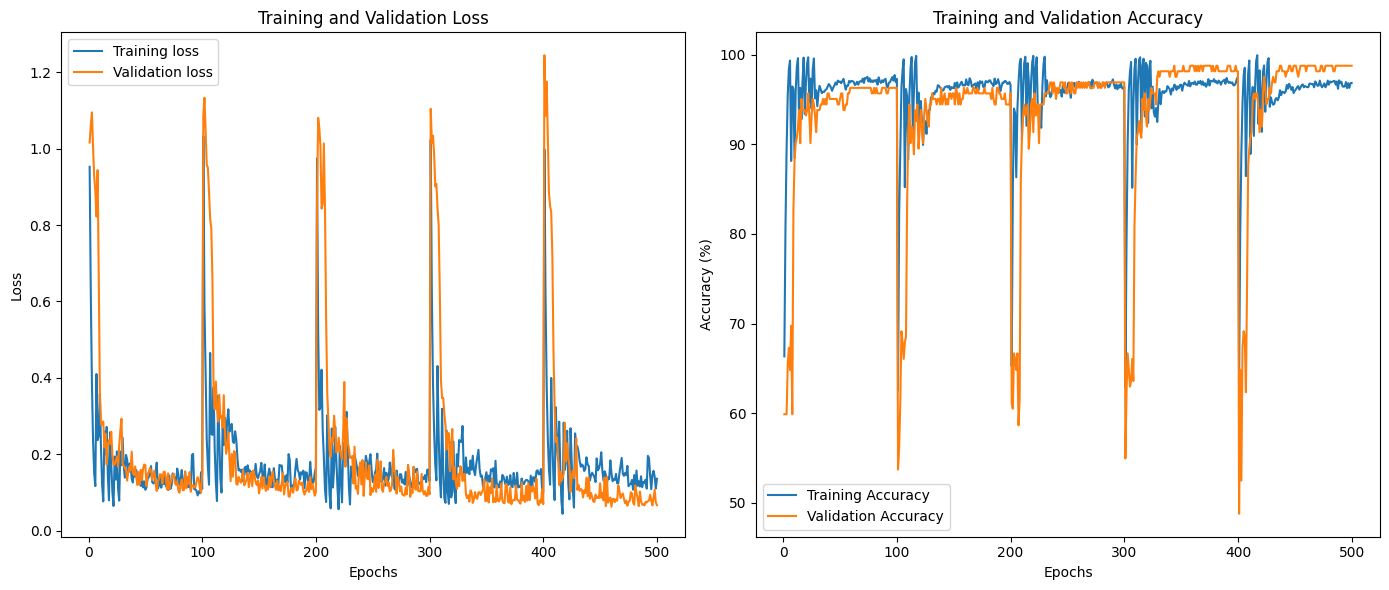

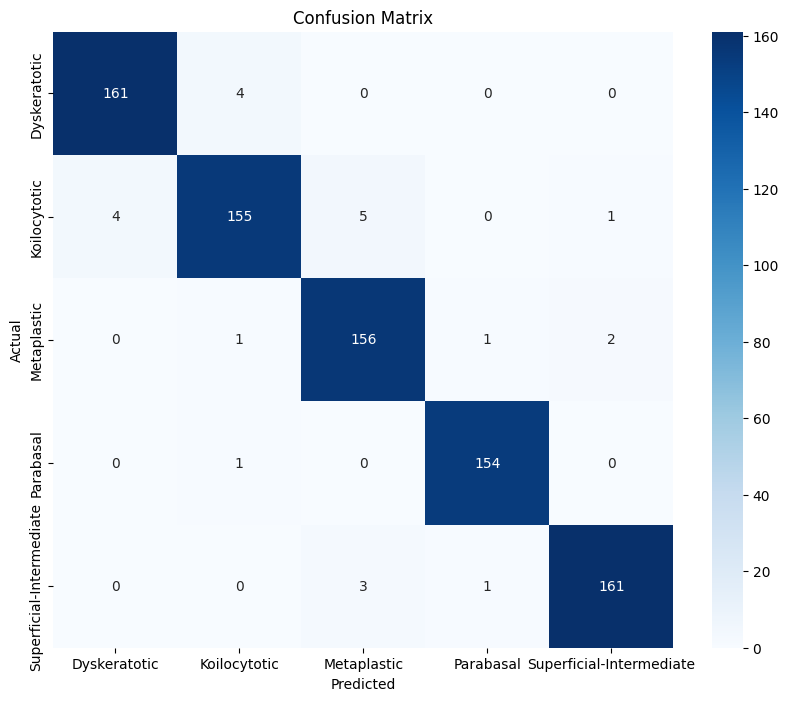

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os


def print_score(y_true, y_pred):
    print('------Weighted------')
    print('Weighted precision', precision_score(y_true, y_pred, average='weighted'))
    print('Weighted recall', recall_score(y_true, y_pred, average='weighted'))
    wf1 = f1_score(y_true, y_pred, average='weighted')
    print('Weighted f1-score', wf1)
    print('------Macro------')
    print('Macro precision', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall', recall_score(y_true, y_pred, average='macro'))
    maf1 = f1_score(y_true, y_pred, average='macro')
    print('Macro f1-score', maf1)
    return wf1, maf1


def is_image_file(filename):
    return filename.endswith('.bmp')


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 0.0, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with autocast():
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 0.0, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total


if __name__ == "__main__":
    dir = '/kaggle/input/sipakmed-dataset/SIPaKMeD dataset'
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(5).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            scheduler.step()
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)

        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
